# **Stable Diffusion time comparison**  


## Load packages.

In [2]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from multiprocessing.pool import ThreadPool as Pool
import cv2
import argparse
import numpy as np
import pandas

In [3]:
def res__(batches, function, split_parts=5):
    b_old = len(batches)//split_parts
    print("split parts", b_old)
    
    pl2 = Pool(b_old)
    results = pl2.map(function, batches[0:b_old])
    
    pl2.close()
    pl2.join()
    for i in range(1, split_parts):
        b_new = min(len(batches)//split_parts, len(batches)-i*len(batches)//split_parts)
        pl1 = Pool(b_new)
        results1 = pl1.map(function, batches[b_old:b_old + b_new])
        b_old = b_old + b_new
        results += results1
        pl1.close()
        pl1.join()
    return results
from pathlib import Path

def check_img(filename):
    path = Path(filename)
    if not path.is_file():
        return False
    try:
        im = Image.open(filename)
        im.verify()
        im.close()
        return True
    except: 
        print(filename,'corrupted')
        return False
# Computes percentage of the image batches of size batch_size that contain at least  one image with dominance of each color (Red, Green, Blue).
# Input: 
# image_folder -- target image folder that is used for computing statistics;
#
def compute_RGB_statistics(image_folder, batch_size=5, K=1):
    batches = []
    for ba in os.listdir(image_folder):
        if os.path.isdir(image_folder + ba):   
            batches.append(ba)
    #image_files = os.listdir(image_folder)
    num_files = 0
    s = 0
    ss = 0
    s_sum = 0
    
    def rg(ba):
    #for ba in batches:
     s_sum_local = 0
     s_local = 0
     ss_local = 0
     num_files_local = 0
        
     l = os.listdir(image_folder + ba)
     if len(l) == batch_size:    
        sr = 0
        sg = 0
        sb = 0

        
        for i in range(len(l)):
            f = l[i]
       
            if check_img(image_folder + ba + '/' + f):
                im = Image.open(image_folder + ba + '/' + f) 
                r,g,b = im.convert("RGB").split()
                if np.sum(r) > K * max(np.sum(g), np.sum(b)):
                    sr += 1
                if np.sum(g) > K * max(np.sum(r), np.sum(b)):    
                    sg += 1
                if np.sum(b) > K * max(np.sum(r), np.sum(g)):
                    sb += 1
        s_sum_local += 1
        
        if sr > 0 and sg > 0 and sb > 0:
            s_sum_local += 1
            s_local += 1
        if sr * sg > 0 or sr * sb > 0 or sg * sb > 0:
            ss_local += 1 
            s_sum_local += 1
        num_files_local += 1
     return s_sum_local, s_local, ss_local, num_files_local

    def res_(batches):
        return res__(batches, rg)
        
    results = res_(batches)
    
    s_sum = sum(res[0] for res in results)
    s = sum(res[1] for res in results)
    ss = sum(res[2] for res in results)
    num_files = sum(res[3] for res in results)
    if num_files > 1:
        sd_sum = math.sqrt(sum((res[0] - s_sum/num_files)**2 for res in results))/(num_files-1)
    else:
        sd_sum = 0

        
    print("Image folder name: ", image_folder, )
    print("Number of images: ", num_files)    
    print("Number of image batches of size " + str(batch_size) + " that contain at least one image with dominance of each color (Red, Green, Blue) is: " + str(s))
    print()
    print()
    if num_files > 0:
        return s / num_files * 100, num_files, ss/num_files * 100, s_sum/num_files, sd_sum
    
    return 0, 0, 0, 0, 0


def compute_RGB_statistics_average(image_folder, K = 1):
    sr = 0
    sg = 0
    sb = 0
    batches = []
    for ba in os.listdir(image_folder):
        if os.path.isdir(image_folder + ba):   
            batches.append(ba)
    #image_files = os.listdir(image_folder)
    num_files = 0
    
    #for ba in batches:
    def ravg(ba):
        l = os.listdir(image_folder + ba)
        num_files_loc = len(l)
        sr_loc = 0
        sg_loc = 0
        sb_loc = 0
        for i in range(len(l)):
            f = l[i]
            if check_img(image_folder + ba + '/' + f):
                im = Image.open(image_folder + ba + '/' + f) 
                r,g,b = im.convert("RGB").split()
                if np.sum(r) > K * max(np.sum(g), np.sum(b)):
                    sr_loc += 1
                if np.sum(g) > K * max(np.sum(r), np.sum(b)):    
                    sg_loc += 1
                if np.sum(b) > K * max(np.sum(r), np.sum(g)):
                    sb_loc += 1
        return sr_loc, sg_loc, sb_loc, num_files_loc
                    
    def res_(batches):
        return res__(batches, ravg)
    
    results = res_(batches)
    print(results)
    sr = sum(res[0] for res in results)
    sg = sum(res[1] for res in results)
    sb = sum(res[2] for res in results)
    num_files = sum(res[3] for res in results)
    
    sd_r = math.sqrt(sum((res[0] - sr/num_files)**2 for res in results)/(num_files-1))
    sd_g = math.sqrt(sum((res[1] - sg/num_files)**2 for res in results)/(num_files-1))
    sd_b = math.sqrt(sum((res[2] - sb/num_files)**2 for res in results)/(num_files-1))


    return sr / num_files * 100, sg / num_files * 100, sb / num_files * 100, sd_r, sd_g, sd_b

def run_batch(batch_size, image_folders, K=1, db=None):
    
    prompt_dic_5 = {}
    prompt_dic_5_ss = {}
    prompt_dic_5_num = {}
    prompt_dic_5_savg = {}
    prompt_dic_r = {}
    prompt_dic_g = {}
    prompt_dic_b = {}
    lf = { }
    sd_sum = {}
    sd_r = {}
    sd_g = {}
    sd_b = {}
    
    num_prompts = 0
    modes = set()
    
    d_str = ""
    if db != None:
        d_str = "_" + str(db)

    
    for img_folder in image_folders:
     if img_folder.find('batch_' + str(batch_size)) != -1 and os.path.isdir(img_folder) and img_folder.find('combined') == -1:
        flag = False
        prompt = img_folder.split('/')[-3].split('_')[0]
        #if prompt in ['face', 'cat', 'ornament']:
        flag = True

        if prompt not in prompt_dic_5.keys() and flag:
            prompt_dic_5[prompt] = {}
            prompt_dic_5_num[prompt] = {}
            prompt_dic_r[prompt] = {}
            prompt_dic_g[prompt] = {}
            prompt_dic_b[prompt] = {}
            prompt_dic_5_ss[prompt] = {}
            prompt_dic_5_savg[prompt] = {}
            lf[prompt] = {}
            sd_sum[prompt] = {}
            sd_r[prompt] = {}
            sd_g[prompt] = {}
            sd_b[prompt] = {}
            num_prompts += 1
        mode = img_folder.split('/')[-2]

        modes.add(mode)
        if flag:
            l = 0
            if mode in lf[prompt].keys():
                l = len(os.listdir(lf[prompt][mode]))
        
            if l < len(os.listdir(img_folder)):
                lf[prompt][mode] = img_folder
                prompt_dic_5[prompt][mode], prompt_dic_5_num[prompt][mode], prompt_dic_5_ss[prompt][mode], prompt_dic_5_savg[prompt][mode], sd_sum[prompt][mode] = compute_RGB_statistics(img_folder, batch_size, K=K)
                prompt_dic_r[prompt][mode],prompt_dic_g[prompt][mode],prompt_dic_b[prompt][mode], sd_r[prompt][mode], sd_g[prompt][mode], sd_b[prompt][mode] = compute_RGB_statistics_average(img_folder, K=K)
            
            num_modes = len(modes)
    
    for mode in modes:
     for k in prompt_dic_5.keys():
      if mode not in prompt_dic_5[k]:
        prompt_dic_5[k][mode] = -1
        prompt_dic_5_ss[k][mode] = -1
        prompt_dic_r[k][mode] = -1
        prompt_dic_g[k][mode] = -1
        prompt_dic_b[k][mode] = -1
        prompt_dic_5_savg[k][mode] = -1
    return prompt_dic_5, prompt_dic_5_num, prompt_dic_r, prompt_dic_g, prompt_dic_b, lf, num_prompts, modes, prompt_dic_5_ss, prompt_dic_5_savg, sd_sum, sd_r, sd_g, sd_b


In [4]:
prompt_dic_50_again, prompt_dic_50_num_again, prompt_dic_r_50_again, prompt_dic_g_50_again, prompt_dic_b_50_again, lf_50_again, num_prompts_50_again, modes_50_again, prompt_dic_50_ss_again, prompt_dic_50_savg_again, sd_sum_50_again, sd_r_50_again, sd_g_50_again, sd_b_50_again = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}
prompt_dic_50_K11_again, prompt_dic_50_K11_num_again, prompt_dic_r_50_K11_again, prompt_dic_g_50_K11_again, prompt_dic_b_50_K11_again, lf_50_K11_again, num_prompts_50_K11_again, modes_50_K11_again, prompt_dic_50_K11_ss_again, prompt_dic_50_K11_savg_again, sd_sum_50_K11_again, sd_r_50_K11_again, sd_g_50_K11_again, sd_b_50_K11_again =  {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}


In [13]:
experiments_folder = '/private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/'

for db  in [100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,100000]:
    image_folders = []
    for f in os.listdir(experiments_folder):
        if f.find('batch_50_' + str(db)) != -1 and  f.find('batch_50_' + str(db) + str(0)) == -1:
            e = experiments_folder + f
            for s in os.listdir(e):
                if len(os.listdir(e + '/' + s + '/')) > 10:
                    image_folders += [e + '/' + s + '/']
                    image_folders += [e.split('batch_50_')[0] + 'batch_50' + '/' + 'methodpure_random' + '/']
    
    
    prompt_dic_50_again[db], prompt_dic_50_num_again[db], prompt_dic_r_50_again[db], prompt_dic_g_50_again[db], prompt_dic_b_50_again[db], lf_50_again[db], num_prompts_50_again[db], modes_50_again[db], prompt_dic_50_ss_again[db], prompt_dic_50_savg_again[db], sd_sum_50_again[db], sd_r_50_again[db], sd_g_50_again[db], sd_b_50_again[db] = run_batch(50, image_folders, K=1, db=db)
    prompt_dic_50_K11_again[db], prompt_dic_50_K11_num_again[db], prompt_dic_r_50_K11_again[db], prompt_dic_g_50_K11_again[db], prompt_dic_b_50_K11_again[db], lf_50_K11_again[db], num_prompts_50_K11_again[db], modes_50_K11_again[db], prompt_dic_50_K11_ss_again[db], prompt_dic_50_K11_savg_again[db], sd_sum_50_K11_again[db], sd_r_50_K11_again[db], sd_g_50_K11_again[db], sd_b_50_K11_again[db] = run_batch(50, image_folders, K=1.1, db=db)
    

split parts 89
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50_100/methoddispersion_with_big_conv/
Number of images:  444
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 444


split parts 89
[(36, 10, 4, 50), (33, 12, 5, 50), (35, 6, 9, 50), (33, 6, 11, 50), (24, 7, 19, 50), (31, 9, 10, 50), (24, 6, 20, 50), (33, 9, 8, 50), (30, 10, 10, 50), (34, 5, 11, 50), (34, 7, 9, 50), (30, 8, 12, 50), (36, 6, 8, 50), (35, 6, 9, 50), (32, 10, 8, 50), (27, 7, 16, 50), (36, 3, 11, 50), (32, 8, 10, 50), (36, 8, 6, 50), (33, 7, 10, 50), (41, 2, 7, 50), (34, 9, 7, 50), (39, 3, 8, 50), (36, 6, 8, 50), (32, 9, 9, 50), (30, 11, 9, 50), (36, 9, 5, 50), (34, 10, 6, 50), (33, 7, 10, 50), (37, 8, 5, 50), (36, 4, 10, 50), (38, 6, 6, 50), (36, 9, 5, 50), (33, 8, 9, 50), (33, 9, 8, 50), (33, 9, 8, 50), (36, 5, 9, 50), (31, 9, 10, 50), (34, 5, 11, 50), (30, 9, 11, 50), (34

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50_100/methoddispersion_with_conv/
Number of images:  413
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 413


split parts 83
[(36, 5, 9, 50), (41, 4, 5, 50), (33, 10, 7, 50), (36, 5, 9, 50), (35, 6, 9, 50), (34, 8, 8, 50), (36, 5, 9, 50), (33, 8, 9, 50), (33, 8, 9, 50), (26, 6, 18, 50), (37, 6, 7, 50), (38, 4, 8, 50), (33, 6, 11, 50), (30, 7, 13, 50), (32, 7, 11, 50), (35, 7, 8, 50), (31, 6, 13, 50), (33, 8, 9, 50), (35, 7, 8, 50), (25, 9, 16, 50), (31, 8, 11, 50), (29, 9, 12, 50), (29, 9, 12, 50), (35, 10, 5, 50), (33, 8, 9, 50), (34, 9, 7, 50), (34, 8, 8, 50), (35, 9, 6, 50), (35, 9, 6, 50), (37, 6, 7, 50), (36, 4, 10, 50), (35, 8, 7, 50), (33, 8, 9, 50), (29, 8, 13, 50), (31, 6, 13, 50), (34, 7, 9, 50), (35, 7, 8, 50), (39, 6, 5, 50), (30, 9, 11, 50), (34, 6, 10, 50), (29, 11, 10, 50), (29, 11, 1

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50/methodpure_random/
Number of images:  312
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 291


split parts 65
[(41, 4, 5, 50), (46, 2, 2, 50), (40, 7, 3, 50), (44, 2, 4, 50), (44, 2, 4, 50), (46, 0, 4, 50), (39, 3, 8, 50), (46, 4, 0, 50), (46, 3, 1, 50), (36, 6, 8, 50), (43, 4, 3, 50), (39, 4, 7, 50), (44, 4, 2, 50), (28, 3, 0, 31), (41, 3, 6, 50), (41, 6, 3, 50), (40, 5, 5, 50), (46, 3, 1, 50), (41, 6, 3, 50), (43, 5, 2, 50), (32, 7, 3, 42), (41, 6, 3, 50), (44, 4, 2, 50), (39, 6, 5, 50), (46, 1, 3, 50), (42, 7, 1, 50), (43, 4, 3, 50), (44, 2, 4, 50), (44, 2, 4, 50), (41, 5, 4, 50), (48, 2, 0, 50), (40, 6, 4, 50), (48, 1, 1, 50), (43, 3, 4, 50), (45, 3, 2, 50), (41, 7, 2, 50), (44, 5, 1, 50), (47, 2, 1, 50), (22, 4, 0, 26), (42, 2, 6, 50), (42, 6, 2, 50), (43, 3, 4, 50), (44, 3, 3, 50), (42, 6, 2, 50), (45, 5, 0, 50), (43,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_100/methoddispersion_with_big_conv/
Number of images:  298
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 294


split parts 60
[(33, 11, 6, 50), (25, 18, 7, 50), (31, 14, 5, 50), (27, 20, 3, 50), (29, 16, 5, 50), (24, 22, 4, 50), (33, 13, 4, 50), (34, 14, 2, 50), (28, 18, 4, 50), (28, 18, 4, 50), (33, 14, 3, 50), (26, 17, 7, 50), (25, 20, 5, 50), (27, 19, 4, 50), (30, 12, 8, 50), (25, 22, 3, 50), (31, 18, 1, 50), (26, 18, 6, 50), (33, 14, 3, 50), (34, 12, 4, 50), (29, 18, 3, 50), (21, 23, 6, 50), (30, 15, 5, 50), (21, 26, 3, 50), (30, 16, 4, 50), (26, 21, 3, 50), (26, 18, 6, 50), (28, 20, 2, 50), (31, 13, 6, 50), (27, 17, 6, 50), (28, 19, 3, 50), (28, 18, 4, 50), (26, 22, 2, 50), (37, 13, 0, 50), (31, 16, 3, 50), (30, 14, 6, 50), (23, 24, 3, 50), (27, 15, 8, 50), (24, 21, 5, 50), (24, 21, 5, 50), (37, 12, 1, 50), (26, 19, 5

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_100/methoddispersion_with_conv/
Number of images:  279
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 278


split parts 56
[(28, 17, 5, 50), (27, 14, 9, 50), (23, 24, 3, 50), (30, 17, 3, 50), (30, 15, 5, 50), (34, 14, 2, 50), (28, 20, 2, 50), (35, 14, 1, 50), (21, 25, 4, 50), (27, 21, 2, 50), (29, 15, 6, 50), (31, 15, 4, 50), (27, 21, 2, 50), (27, 18, 5, 50), (27, 15, 8, 50), (31, 13, 6, 50), (27, 17, 6, 50), (27, 19, 4, 50), (31, 15, 4, 50), (24, 22, 4, 50), (33, 16, 1, 50), (25, 16, 9, 50), (29, 16, 5, 50), (30, 18, 2, 50), (27, 20, 3, 50), (25, 19, 6, 50), (32, 13, 5, 50), (27, 17, 6, 50), (28, 16, 6, 50), (26, 19, 5, 50), (21, 23, 6, 50), (23, 21, 6, 50), (30, 15, 5, 50), (28, 18, 4, 50), (27, 19, 4, 50), (27, 17, 6, 50), (31, 14, 5, 50), (31, 18, 1, 50), (25, 17, 8, 50), (28, 21, 1, 50), (17, 27, 6, 50), (27, 13, 10, 5

[(44, 0, 6, 50), (47, 0, 3, 50), (43, 4, 3, 50), (45, 2, 3, 50), (47, 0, 3, 50), (48, 0, 2, 50), (49, 0, 1, 50), (45, 0, 5, 50), (44, 1, 5, 50), (46, 1, 3, 50), (48, 0, 2, 50), (44, 0, 6, 50), (44, 2, 4, 50), (47, 0, 3, 50), (46, 0, 4, 50), (47, 0, 3, 50), (47, 1, 2, 50), (49, 0, 1, 50), (46, 1, 3, 50), (48, 0, 2, 50), (45, 0, 5, 50), (47, 1, 2, 50), (46, 0, 4, 50), (44, 0, 6, 50), (48, 0, 2, 50), (45, 1, 4, 50), (46, 0, 4, 50), (48, 0, 2, 50), (43, 1, 6, 50), (44, 1, 5, 50), (41, 1, 8, 50), (45, 2, 3, 50), (18, 0, 1, 19), (47, 0, 3, 50), (48, 0, 2, 50), (46, 0, 4, 50), (46, 1, 3, 50), (46, 0, 4, 50), (46, 0, 4, 50), (46, 1, 3, 50), (46, 0, 4, 50), (43, 1, 6, 50), (48, 0, 2, 50), (48, 0, 2, 50), (45, 0, 5, 50), (46, 1, 3, 50), (48, 0, 2, 50), (41, 1, 8, 50), (46, 0, 4, 50), (47, 0, 3, 50), (46, 1, 3, 50), (46, 1, 3, 50), (44, 0, 6, 50), (48, 0, 2, 50), (44, 0, 6, 50), (35, 0, 2, 37), (47, 1, 2, 50), (43, 1, 6, 50), (44, 2, 4, 50), (48, 1, 1, 50), (43, 1, 6, 50), (46, 0, 4, 50), (44, 0,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50/methodpure_random/
Number of images:  157
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 144


split parts 32
[(15, 0, 35, 50), (23, 0, 27, 50), (18, 4, 28, 50), (22, 4, 24, 50), (21, 6, 23, 50), (18, 1, 31, 50), (18, 4, 28, 50), (17, 2, 31, 50), (18, 1, 31, 50), (23, 2, 25, 50), (18, 3, 29, 50), (11, 3, 36, 50), (19, 2, 29, 50), (13, 1, 36, 50), (13, 3, 34, 50), (17, 0, 33, 50), (17, 2, 31, 50), (16, 3, 31, 50), (23, 4, 23, 50), (16, 4, 30, 50), (20, 1, 29, 50), (21, 7, 22, 50), (14, 2, 34, 50), (15, 1, 34, 50), (11, 2, 37, 50), (21, 2, 27, 50), (17, 4, 29, 50), (23, 2, 25, 50), (18, 4, 28, 50), (14, 5, 31, 50), (11, 3, 36, 50), (18, 3, 29, 50), (16, 4, 30, 50), (23, 1, 26, 50), (20, 3, 27, 50), (13, 0, 37, 50), (17, 2, 31, 50), (22, 1, 27, 50), (19, 2, 29, 50), (19, 6, 25, 50), (15, 3, 32, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_100/methoddispersion_with_conv/
Number of images:  133
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 107


split parts 27
[(37, 10, 3, 50), (35, 12, 3, 50), (45, 5, 0, 50), (45, 5, 0, 50), (41, 8, 1, 50), (41, 7, 2, 50), (42, 8, 0, 50), (43, 7, 0, 50), (37, 11, 2, 50), (33, 16, 1, 50), (40, 7, 3, 50), (39, 10, 1, 50), (42, 7, 1, 50), (37, 11, 2, 50), (39, 10, 1, 50), (37, 11, 2, 50), (37, 13, 0, 50), (38, 10, 2, 50), (37, 8, 5, 50), (40, 10, 0, 50), (36, 11, 3, 50), (42, 8, 0, 50), (37, 11, 2, 50), (41, 7, 2, 50), (43, 6, 1, 50), (43, 6, 1, 50), (36, 13, 1, 50), (35, 15, 0, 50), (39, 7, 4, 50), (37, 8, 5, 50), (42, 7, 1, 50), (43, 6, 1, 50), (35, 14, 1, 50), (37, 11, 2, 50), (43, 7, 0, 50), (43, 7, 0, 50), (40, 8, 2, 50), (38, 11, 1, 50), (39, 10, 1, 50), (37, 13, 0, 50), (33, 16, 1, 50), (39, 7, 4, 50), (34, 16, 0, 50), (3

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_100/methoddispersion_with_conv/
Number of images:  284
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 268


split parts 57
[(37, 10, 3, 50), (37, 12, 1, 50), (39, 11, 0, 50), (36, 12, 2, 50), (38, 11, 1, 50), (35, 11, 4, 50), (36, 12, 2, 50), (37, 9, 4, 50), (38, 9, 3, 50), (38, 10, 2, 50), (39, 7, 4, 50), (37, 9, 4, 50), (43, 5, 2, 50), (38, 8, 4, 50), (41, 5, 4, 50), (39, 7, 4, 50), (34, 12, 4, 50), (33, 14, 3, 50), (42, 6, 2, 50), (34, 14, 2, 50), (29, 19, 2, 50), (33, 13, 4, 50), (36, 12, 2, 50), (36, 11, 3, 50), (31, 15, 4, 50), (29, 18, 3, 50), (35, 12, 3, 50), (32, 15, 3, 50), (38, 12, 0, 50), (36, 11, 3, 50), (37, 8, 5, 50), (43, 5, 2, 50), (34, 14, 2, 50), (41, 7, 2, 50), (36, 11, 3, 50), (40, 8, 2, 50), (35, 13, 2, 50), (38, 8, 4, 50), (35, 13, 2, 50), (34, 15, 1, 50), (39, 9, 2, 50), (33, 11, 6, 50), (37, 8, 5, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_100/methoddispersion_with_big_conv/
Number of images:  289
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 271


split parts 58
[(36, 10, 4, 50), (36, 11, 3, 50), (38, 10, 2, 50), (32, 14, 4, 50), (36, 13, 1, 50), (27, 18, 5, 50), (38, 10, 2, 50), (38, 9, 3, 50), (39, 8, 3, 50), (39, 10, 1, 50), (33, 13, 4, 50), (38, 10, 2, 50), (45, 2, 3, 50), (36, 11, 3, 50), (35, 12, 3, 50), (36, 11, 3, 50), (36, 12, 2, 50), (38, 10, 2, 50), (39, 10, 1, 50), (32, 14, 4, 50), (41, 7, 2, 50), (33, 12, 5, 50), (36, 11, 3, 50), (48, 1, 1, 50), (35, 14, 1, 50), (37, 9, 4, 50), (38, 9, 3, 50), (35, 12, 3, 50), (28, 16, 6, 50), (35, 8, 7, 50), (35, 10, 5, 50), (29, 18, 3, 50), (43, 4, 3, 50), (36, 11, 3, 50), (38, 10, 2, 50), (33, 13, 4, 50), (43, 5, 2, 50), (37, 12, 1, 50), (36, 8, 6, 50), (39, 8, 3, 50), (39, 10, 1, 50), (33, 13, 4, 50), (36,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50/methodpure_random/
Number of images:  295
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 282


split parts 62
[(33, 14, 3, 50), (35, 13, 2, 50), (13, 12, 1, 26), (31, 17, 2, 50), (26, 20, 4, 50), (25, 21, 4, 50), (31, 18, 1, 50), (33, 14, 3, 50), (17, 11, 2, 30), (32, 13, 5, 50), (30, 18, 2, 50), (28, 19, 3, 50), (24, 18, 1, 43), (31, 16, 3, 50), (22, 14, 2, 38), (27, 20, 3, 50), (22, 18, 10, 50), (30, 17, 3, 50), (26, 23, 1, 50), (26, 18, 6, 50), (35, 14, 1, 50), (27, 21, 2, 50), (24, 17, 9, 50), (30, 18, 2, 50), (8, 3, 1, 12), (10, 16, 3, 29), (27, 20, 3, 50), (20, 22, 8, 50), (30, 15, 5, 50), (28, 22, 0, 50), (30, 18, 2, 50), (22, 26, 2, 50), (22, 23, 5, 50), (22, 9, 0, 31), (29, 15, 6, 50), (34, 13, 3, 50), (32, 16, 2, 50), (29, 18, 3, 50), (20, 26, 4, 50), (28, 20, 2, 50), (32, 17, 1, 50), (25, 18, 2, 45), (25, 19

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50_100/methoddispersion_with_conv/
Number of images:  418
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 142


split parts 84
[(46, 1, 3, 50), (42, 0, 8, 50), (42, 0, 8, 50), (41, 2, 7, 50), (40, 0, 10, 50), (38, 0, 12, 50), (45, 0, 5, 50), (43, 2, 5, 50), (44, 0, 6, 50), (43, 0, 7, 50), (47, 0, 3, 50), (41, 0, 9, 50), (45, 0, 5, 50), (48, 0, 2, 50), (45, 0, 5, 50), (44, 0, 6, 50), (42, 1, 7, 50), (43, 0, 7, 50), (42, 0, 8, 50), (46, 0, 4, 50), (44, 1, 5, 50), (44, 0, 6, 50), (44, 0, 6, 50), (36, 1, 13, 50), (44, 0, 6, 50), (41, 0, 9, 50), (43, 2, 5, 50), (45, 0, 5, 50), (44, 0, 6, 50), (48, 0, 2, 50), (44, 0, 6, 50), (41, 1, 8, 50), (41, 2, 7, 50), (44, 0, 6, 50), (48, 0, 2, 50), (44, 0, 6, 50), (43, 1, 6, 50), (41, 2, 7, 50), (41, 0, 9, 50), (45, 0, 5, 50), (43, 0, 7, 50), (45, 0, 5, 50), (42, 0, 8, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50_100/methoddispersion_with_big_conv/
Number of images:  413
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 149


split parts 83
[(45, 1, 4, 50), (44, 0, 6, 50), (45, 0, 5, 50), (47, 0, 3, 50), (44, 0, 6, 50), (44, 0, 6, 50), (43, 0, 7, 50), (46, 0, 4, 50), (45, 1, 4, 50), (44, 0, 6, 50), (40, 0, 10, 50), (43, 0, 7, 50), (45, 0, 5, 50), (46, 0, 4, 50), (42, 0, 8, 50), (40, 1, 9, 50), (43, 0, 7, 50), (42, 0, 8, 50), (47, 1, 2, 50), (41, 0, 9, 50), (43, 0, 7, 50), (43, 0, 7, 50), (46, 1, 3, 50), (46, 0, 4, 50), (44, 2, 4, 50), (43, 0, 7, 50), (48, 0, 2, 50), (39, 0, 11, 50), (43, 2, 5, 50), (46, 1, 3, 50), (43, 0, 7, 50), (45, 0, 5, 50), (46, 1, 3, 50), (40, 0, 10, 50), (41, 1, 8, 50), (42, 0, 8, 50), (44, 1, 5, 50), (43, 0, 7, 50), (44, 0, 6, 50), (42, 0, 8, 50), (39, 0, 11, 50), (44, 0, 6, 50), (40, 1

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50/methodpure_random/
Number of images:  174
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 46


split parts 36
[(12, 5, 0, 50), (7, 1, 0, 50), (19, 1, 0, 50), (14, 1, 0, 50), (11, 1, 0, 50), (14, 1, 0, 50), (10, 2, 0, 50), (14, 1, 1, 50), (9, 2, 1, 50), (13, 2, 1, 50), (10, 2, 0, 50), (17, 1, 0, 50), (11, 2, 0, 50), (15, 0, 0, 50), (13, 2, 0, 50), (9, 1, 1, 50), (10, 0, 0, 50), (9, 0, 2, 50), (10, 0, 0, 50), (12, 1, 1, 50), (10, 0, 2, 50), (13, 0, 0, 50), (11, 0, 0, 50), (8, 1, 0, 50), (15, 1, 1, 50), (8, 2, 0, 50), (10, 1, 0, 50), (11, 1, 1, 50), (10, 3, 0, 50), (15, 0, 2, 50), (4, 0, 0, 19), (10, 2, 0, 50), (9, 1, 0, 50), (11, 2, 0, 50), (10, 0, 1, 50), (16, 1, 0, 50), (2, 0, 0, 12), (12, 1, 0, 50), (16, 1, 1, 50), (11, 2, 1, 50), (16, 2, 1, 50), (10, 1, 1, 50), (12, 0, 0, 50), (16, 2, 0, 50), (10

split parts 76
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50_100/methoddispersion_with_big_conv/
Number of images:  380
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 176


split parts 76
[(31, 2, 1, 50), (31, 1, 1, 50), (31, 1, 0, 50), (32, 1, 2, 50), (36, 1, 1, 50), (38, 1, 0, 50), (37, 0, 0, 50), (35, 1, 1, 50), (40, 0, 0, 50), (37, 2, 0, 50), (31, 2, 0, 50), (39, 2, 0, 50), (27, 4, 2, 50), (36, 1, 0, 50), (31, 1, 1, 50), (31, 0, 1, 50), (34, 1, 0, 50), (24, 2, 2, 50), (35, 1, 0, 50), (27, 2, 3, 50), (34, 0, 0, 50), (31, 1, 1, 50), (38, 1, 1, 50), (37, 0, 1, 50), (29, 5, 1, 50), (34, 0, 0, 50), (33, 2, 2, 50), (25, 2, 3, 50), (33, 1, 3, 50), (34, 2, 2, 50), (33, 2, 0, 50), (34, 1, 1, 50), (30, 5, 4, 50), (28, 0, 1, 50), (38, 0, 1, 50), (33, 1, 2, 50), (32, 1, 4, 50), (31, 0, 0, 50), (35, 1, 3, 50), (36, 0, 0, 50), (30, 2, 2, 50), (32, 1, 0, 50), (31, 0, 3, 50), (34,

split parts 81
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50_100/methoddispersion_with_conv/
Number of images:  404
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 173


split parts 81
[(30, 1, 1, 50), (33, 3, 1, 50), (38, 1, 1, 50), (30, 1, 1, 50), (33, 1, 3, 50), (27, 1, 3, 50), (38, 0, 0, 50), (37, 1, 2, 50), (35, 1, 2, 50), (34, 1, 2, 50), (38, 0, 2, 50), (32, 3, 4, 50), (27, 0, 0, 50), (28, 2, 1, 50), (37, 0, 2, 50), (33, 2, 0, 50), (34, 2, 0, 50), (29, 1, 0, 50), (30, 0, 2, 50), (36, 2, 0, 50), (29, 2, 0, 50), (31, 2, 2, 50), (25, 3, 1, 50), (33, 0, 0, 50), (35, 1, 0, 50), (32, 1, 2, 50), (25, 1, 1, 50), (36, 1, 1, 50), (34, 0, 0, 50), (41, 0, 1, 50), (37, 0, 1, 50), (38, 0, 0, 50), (33, 0, 1, 50), (39, 0, 2, 50), (36, 1, 2, 50), (25, 1, 1, 50), (36, 1, 1, 50), (35, 0, 0, 50), (34, 1, 0, 50), (32, 2, 0, 50), (31, 2, 0, 50), (36, 1, 0, 50), (37, 1, 1, 50), (27, 2, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50/methodpure_random/
Number of images:  305
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 219


split parts 64
[(9, 2, 2, 50), (9, 5, 1, 50), (7, 6, 3, 50), (8, 3, 4, 50), (9, 3, 0, 50), (11, 1, 2, 50), (9, 6, 3, 50), (12, 2, 2, 50), (9, 5, 1, 50), (9, 6, 3, 50), (11, 3, 2, 50), (11, 3, 3, 50), (12, 3, 2, 50), (9, 2, 1, 50), (8, 4, 1, 50), (7, 5, 0, 50), (6, 2, 0, 50), (13, 3, 0, 50), (11, 4, 1, 50), (12, 2, 1, 50), (11, 4, 0, 50), (9, 3, 3, 50), (5, 2, 1, 50), (7, 5, 2, 50), (13, 4, 3, 50), (12, 1, 0, 50), (10, 6, 2, 50), (11, 4, 0, 50), (9, 3, 1, 50), (11, 7, 0, 50), (9, 2, 1, 43), (15, 4, 2, 50), (8, 2, 3, 50), (6, 6, 0, 50), (12, 2, 0, 50), (11, 1, 4, 50), (4, 4, 1, 50), (17, 7, 0, 50), (5, 7, 2, 50), (8, 5, 2, 50), (8, 7, 3, 50), (14, 3, 4, 50), (10, 3, 1, 50), (12, 3, 0, 50), (7, 2, 4, 50), (11, 6, 1, 50), (13, 2, 1, 5

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50_100/methoddispersion_with_big_conv/
Number of images:  160
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 32
[(16, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (13, 1, 0, 50), (15, 0, 0, 50), (16, 1, 0, 50), (15, 0, 0, 50), (10, 0, 0, 50), (16, 0, 0, 50), (11, 0, 0, 50), (14, 0, 0, 50), (21, 0, 0, 50), (18, 0, 0, 50), (12, 0, 0, 50), (19, 0, 0, 50), (14, 0, 0, 50), (10, 1, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (12, 1, 0, 50), (14, 0, 0, 50), (11, 0, 0, 50), (22, 0, 0, 50), (16, 0, 0, 50), (16, 0, 0, 50), (14, 0, 0, 50), (20, 0, 0, 50), (16, 0, 0, 50), (10, 0, 0, 50), (13, 0, 0, 50), (12, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (13, 0, 0, 50), (17, 0, 0, 50), (18, 0, 0, 50), (14, 0, 0, 50), (14, 0, 0, 50), (17, 0, 1, 50), (20, 0, 0, 50), (22, 0, 0, 50), (12, 0, 0, 50)

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50/methodpure_random/
Number of images:  157
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 6


split parts 32
[(1, 0, 5, 50), (2, 0, 7, 50), (2, 0, 4, 50), (2, 1, 3, 50), (4, 0, 2, 50), (3, 0, 3, 50), (6, 0, 3, 50), (3, 0, 7, 50), (1, 0, 5, 50), (3, 0, 2, 50), (3, 0, 5, 50), (1, 0, 5, 50), (5, 0, 8, 50), (1, 0, 5, 50), (2, 0, 11, 50), (5, 0, 8, 50), (1, 0, 9, 50), (3, 0, 6, 50), (3, 0, 5, 50), (1, 0, 8, 50), (3, 0, 6, 50), (2, 0, 4, 50), (2, 0, 6, 50), (2, 0, 5, 50), (0, 0, 4, 50), (4, 0, 3, 50), (2, 1, 4, 50), (4, 0, 5, 50), (4, 0, 7, 50), (2, 0, 5, 50), (2, 0, 6, 50), (5, 0, 3, 50), (5, 0, 5, 50), (2, 0, 4, 50), (5, 0, 1, 50), (1, 0, 9, 50), (3, 0, 4, 50), (4, 0, 4, 50), (2, 0, 2, 50), (2, 0, 4, 50), (1, 0, 3, 50), (3, 0, 4, 50), (1, 0, 4, 50), (3, 0, 4, 50), (4, 1, 2, 50), (3, 0, 7, 50), (3,

[(21, 2, 0, 50), (15, 4, 0, 50), (20, 0, 0, 50), (21, 2, 0, 50), (28, 1, 0, 50), (19, 0, 0, 50), (17, 1, 0, 50), (20, 2, 0, 50), (16, 4, 0, 50), (16, 6, 0, 50), (19, 2, 0, 50), (18, 2, 1, 50), (16, 2, 0, 50), (17, 4, 0, 50), (15, 3, 0, 50), (14, 1, 0, 50), (20, 3, 0, 50), (16, 4, 0, 50), (18, 2, 0, 50), (15, 2, 0, 50), (20, 2, 0, 50), (14, 1, 0, 50), (15, 3, 0, 50), (20, 3, 0, 50), (22, 1, 0, 50), (24, 1, 0, 50), (15, 4, 0, 50), (16, 3, 0, 50), (20, 2, 1, 50), (14, 1, 0, 50), (21, 2, 0, 50), (20, 1, 0, 50), (16, 4, 1, 50), (17, 1, 0, 50), (18, 3, 0, 50), (12, 1, 0, 50), (13, 2, 0, 50), (17, 1, 0, 50), (14, 3, 0, 50), (12, 5, 0, 50), (18, 2, 0, 50), (18, 1, 1, 50), (11, 4, 0, 50), (12, 1, 1, 50), (21, 2, 1, 50), (9, 2, 0, 50), (9, 3, 0, 50), (20, 3, 0, 50), (17, 1, 0, 50), (20, 2, 0, 50), (18, 3, 0, 50), (14, 3, 0, 50), (21, 2, 0, 50), (14, 1, 1, 50), (19, 3, 0, 50), (21, 2, 0, 50), (23, 0, 0, 50), (16, 0, 0, 50), (15, 3, 0, 50), (16, 5, 0, 50), (23, 1, 0, 50), (14, 1, 0, 50), (16, 2, 0

split parts 57
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_100/methoddispersion_with_conv/
Number of images:  284
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 80


split parts 57
[(18, 4, 1, 50), (18, 3, 0, 50), (21, 2, 0, 50), (23, 4, 0, 50), (20, 2, 1, 50), (18, 3, 0, 50), (23, 3, 1, 50), (23, 2, 0, 50), (22, 2, 1, 50), (23, 3, 0, 50), (26, 3, 0, 50), (13, 1, 1, 50), (26, 1, 0, 50), (20, 2, 3, 50), (23, 1, 0, 50), (23, 2, 1, 50), (17, 4, 0, 50), (22, 6, 1, 50), (20, 2, 0, 50), (21, 2, 1, 50), (11, 3, 0, 50), (19, 3, 2, 50), (16, 5, 0, 50), (20, 0, 1, 50), (17, 4, 0, 50), (15, 4, 0, 50), (16, 4, 1, 50), (18, 7, 0, 50), (20, 4, 0, 50), (22, 3, 0, 50), (26, 0, 0, 50), (27, 2, 0, 50), (19, 4, 0, 50), (21, 1, 0, 50), (18, 2, 0, 50), (22, 3, 0, 50), (21, 2, 0, 50), (14, 2, 0, 50), (20, 3, 0, 50), (19, 2, 0, 50), (18, 4, 0, 50), (16, 3, 1, 50), (25, 3, 1, 50), (23, 4, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_100/methoddispersion_with_big_conv/
Number of images:  289
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 76


split parts 58
[(21, 1, 0, 50), (19, 3, 1, 50), (15, 4, 0, 50), (23, 6, 0, 50), (18, 3, 0, 50), (17, 3, 2, 50), (24, 4, 0, 50), (23, 1, 0, 50), (19, 2, 0, 50), (25, 3, 0, 50), (17, 6, 1, 50), (17, 2, 0, 50), (24, 1, 0, 50), (22, 1, 0, 50), (22, 4, 0, 50), (20, 1, 1, 50), (19, 4, 1, 50), (19, 3, 0, 50), (23, 4, 0, 50), (19, 4, 0, 50), (22, 2, 0, 50), (21, 2, 0, 50), (19, 4, 0, 50), (21, 0, 0, 50), (15, 5, 0, 50), (19, 2, 2, 50), (23, 4, 0, 50), (14, 4, 0, 50), (15, 5, 1, 50), (22, 4, 0, 50), (21, 1, 0, 50), (12, 3, 0, 50), (23, 3, 0, 50), (25, 2, 0, 50), (25, 3, 0, 50), (24, 7, 0, 50), (26, 1, 0, 50), (20, 3, 1, 50), (22, 1, 1, 50), (23, 1, 0, 50), (22, 2, 0, 50), (11, 3, 0, 50), (21, 2, 0, 50), (20, 5, 0, 50), (23

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50/methodpure_random/
Number of images:  295
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 222


split parts 62
[(21, 9, 1, 50), (22, 7, 1, 50), (12, 2, 1, 26), (17, 6, 0, 50), (16, 9, 1, 50), (13, 7, 2, 50), (18, 7, 1, 50), (19, 9, 2, 50), (10, 5, 0, 30), (14, 8, 4, 50), (15, 11, 1, 50), (19, 10, 0, 50), (15, 5, 1, 43), (15, 8, 2, 50), (15, 7, 0, 38), (15, 8, 0, 50), (13, 10, 3, 50), (17, 8, 2, 50), (11, 10, 1, 50), (18, 5, 0, 50), (18, 9, 0, 50), (15, 10, 1, 50), (12, 8, 1, 50), (13, 9, 1, 50), (6, 2, 0, 12), (5, 8, 2, 29), (19, 10, 1, 50), (14, 8, 2, 50), (13, 7, 2, 50), (14, 8, 0, 50), (14, 11, 0, 50), (15, 14, 2, 50), (11, 6, 1, 50), (14, 6, 0, 31), (9, 8, 4, 50), (19, 5, 1, 50), (19, 5, 1, 50), (18, 7, 1, 50), (15, 9, 1, 50), (15, 8, 1, 50), (19, 11, 1, 50), (16, 9, 2, 45), (16, 9, 3, 50), (17, 6, 4, 50), (16, 4, 1

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50_100/methoddispersion_with_conv/
Number of images:  418
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 84
[(23, 0, 0, 50), (18, 0, 0, 50), (22, 0, 0, 50), (16, 0, 0, 50), (22, 0, 0, 50), (17, 0, 0, 50), (21, 0, 0, 50), (20, 0, 0, 50), (22, 0, 0, 50), (19, 0, 0, 50), (21, 0, 0, 50), (19, 0, 0, 50), (21, 0, 0, 50), (21, 0, 0, 50), (18, 0, 0, 50), (23, 0, 0, 50), (20, 0, 0, 50), (22, 0, 0, 50), (25, 0, 0, 50), (20, 0, 0, 50), (19, 0, 0, 50), (17, 0, 0, 50), (21, 0, 0, 50), (22, 0, 0, 50), (27, 0, 0, 50), (22, 0, 0, 50), (20, 1, 0, 50), (24, 0, 0, 50), (22, 0, 0, 50), (26, 0, 0, 50), (21, 0, 0, 50), (19, 0, 0, 50), (25, 0, 0, 50), (19, 0, 0, 50), (22, 0, 0, 50), (21, 0, 0, 50), (19, 0, 0, 50), (22, 0, 0, 50), (20, 0, 0, 50), (21, 0, 0, 50), (20, 0, 0, 50), (20, 0, 0, 50), (18, 0, 0, 50), 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50_100/methoddispersion_with_big_conv/
Number of images:  413
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 83
[(24, 0, 0, 50), (18, 0, 0, 50), (23, 0, 0, 50), (26, 0, 0, 50), (19, 0, 0, 50), (22, 0, 0, 50), (23, 0, 0, 50), (19, 0, 0, 50), (25, 0, 0, 50), (20, 0, 0, 50), (15, 0, 0, 50), (24, 0, 0, 50), (24, 0, 0, 50), (21, 0, 0, 50), (18, 0, 0, 50), (20, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (25, 0, 0, 50), (20, 0, 0, 50), (31, 0, 0, 50), (21, 0, 0, 50), (27, 0, 0, 50), (27, 0, 0, 50), (18, 1, 0, 50), (16, 0, 0, 50), (27, 0, 0, 50), (16, 0, 0, 50), (29, 0, 0, 50), (25, 0, 0, 50), (24, 0, 0, 50), (19, 0, 0, 50), (22, 0, 0, 50), (26, 0, 0, 50), (23, 0, 1, 50), (13, 0, 0, 50), (20, 0, 1, 50), (28, 0, 0, 50), (24, 0, 0, 50), (20, 0, 0, 50), (21, 0, 0, 50), (19, 0, 0, 50), (23, 0, 0, 5

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50/methodpure_random/
Number of images:  312
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 291


split parts 65
[(41, 4, 5, 50), (46, 2, 2, 50), (40, 7, 3, 50), (44, 2, 4, 50), (44, 2, 4, 50), (46, 0, 4, 50), (39, 3, 8, 50), (46, 4, 0, 50), (46, 3, 1, 50), (36, 6, 8, 50), (43, 4, 3, 50), (39, 4, 7, 50), (44, 4, 2, 50), (28, 3, 0, 31), (41, 3, 6, 50), (41, 6, 3, 50), (40, 5, 5, 50), (46, 3, 1, 50), (41, 6, 3, 50), (43, 5, 2, 50), (32, 7, 3, 42), (41, 6, 3, 50), (44, 4, 2, 50), (39, 6, 5, 50), (46, 1, 3, 50), (42, 7, 1, 50), (43, 4, 3, 50), (44, 2, 4, 50), (44, 2, 4, 50), (41, 5, 4, 50), (48, 2, 0, 50), (40, 6, 4, 50), (48, 1, 1, 50), (43, 3, 4, 50), (45, 3, 2, 50), (41, 7, 2, 50), (44, 5, 1, 50), (47, 2, 1, 50), (22, 4, 0, 26), (42, 2, 6, 50), (42, 6, 2, 50), (43, 3, 4, 50), (44, 3, 3, 50), (42, 6, 2, 50), (45, 5, 0, 50), (43,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50_500/methoddispersion_with_conv/
Number of images:  355
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 345


split parts 71
[(18, 2, 30, 50), (16, 1, 33, 50), (19, 5, 26, 50), (18, 2, 30, 50), (17, 3, 30, 50), (11, 4, 35, 50), (22, 0, 28, 50), (18, 1, 31, 50), (11, 3, 36, 50), (16, 4, 30, 50), (19, 3, 28, 50), (15, 3, 32, 50), (19, 5, 26, 50), (19, 5, 26, 50), (12, 7, 31, 50), (20, 7, 23, 50), (22, 1, 27, 50), (21, 2, 27, 50), (20, 4, 26, 50), (15, 3, 32, 50), (17, 4, 29, 50), (20, 5, 25, 50), (10, 3, 37, 50), (17, 1, 32, 50), (14, 6, 30, 50), (15, 1, 34, 50), (19, 5, 26, 50), (22, 3, 25, 50), (19, 4, 27, 50), (20, 2, 28, 50), (20, 4, 26, 50), (17, 3, 30, 50), (24, 3, 23, 50), (21, 2, 27, 50), (24, 3, 23, 50), (11, 5, 34, 50), (19, 2, 29, 50), (19, 3, 28, 50), (23, 2, 25, 50), (20, 6, 24, 50),

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50_500/methoddispersion_with_big_conv/
Number of images:  382
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 379


split parts 77
[(20, 2, 28, 50), (15, 2, 33, 50), (20, 1, 29, 50), (19, 5, 26, 50), (19, 5, 26, 50), (20, 3, 27, 50), (18, 5, 27, 50), (25, 2, 23, 50), (15, 4, 31, 50), (23, 4, 23, 50), (27, 2, 21, 50), (20, 2, 28, 50), (14, 4, 32, 50), (23, 2, 25, 50), (15, 3, 32, 50), (22, 5, 23, 50), (13, 7, 30, 50), (14, 3, 33, 50), (16, 5, 29, 50), (16, 3, 31, 50), (16, 5, 29, 50), (17, 7, 26, 50), (13, 2, 35, 50), (14, 4, 32, 50), (18, 4, 28, 50), (16, 4, 30, 50), (20, 2, 28, 50), (17, 2, 31, 50), (21, 3, 26, 50), (13, 5, 32, 50), (17, 5, 28, 50), (14, 5, 31, 50), (11, 6, 33, 50), (13, 6, 31, 50), (21, 2, 27, 50), (17, 3, 30, 50), (19, 4, 27, 50), (18, 7, 25, 50), (14, 4, 32, 50), (26, 4, 20, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50/methodpure_random/
Number of images:  134
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 23


split parts 28
[(44, 0, 6, 50), (41, 0, 9, 50), (41, 0, 9, 50), (44, 1, 5, 50), (42, 0, 8, 50), (44, 1, 5, 50), (47, 0, 3, 50), (44, 1, 5, 50), (39, 2, 9, 50), (45, 0, 5, 50), (40, 1, 9, 50), (45, 1, 4, 50), (42, 1, 7, 50), (39, 1, 10, 50), (41, 0, 9, 50), (46, 0, 4, 50), (39, 1, 10, 50), (43, 0, 7, 50), (47, 0, 3, 50), (46, 0, 4, 50), (39, 0, 11, 50), (42, 0, 8, 50), (47, 1, 2, 50), (47, 0, 3, 50), (37, 1, 12, 50), (45, 0, 5, 50), (43, 0, 7, 50), (40, 1, 9, 50), (40, 0, 10, 50), (41, 0, 9, 50), (43, 0, 7, 50), (41, 0, 9, 50), (45, 0, 5, 50), (40, 0, 10, 50), (45, 0, 5, 50), (42, 0, 8, 50), (42, 0, 8, 50), (42, 0, 8, 50), (46, 0, 4, 50), (46, 0, 4, 50), (43, 0, 7, 50), (45, 0, 5, 50), (40, 0, 10, 50), (44, 

split parts 89
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_500/methoddispersion_with_conv/
Number of images:  445
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 439


split parts 89
[(26, 17, 7, 50), (27, 17, 6, 50), (28, 16, 6, 50), (27, 13, 10, 50), (22, 22, 6, 50), (23, 18, 9, 50), (31, 17, 2, 50), (24, 21, 5, 50), (25, 22, 3, 50), (28, 17, 5, 50), (24, 19, 7, 50), (31, 15, 4, 50), (29, 14, 7, 50), (31, 16, 3, 50), (29, 18, 3, 50), (23, 21, 6, 50), (26, 20, 4, 50), (30, 17, 3, 50), (21, 22, 7, 50), (22, 27, 1, 50), (28, 12, 10, 50), (30, 10, 10, 50), (34, 13, 3, 50), (20, 26, 4, 50), (28, 18, 4, 50), (29, 19, 2, 50), (24, 23, 3, 50), (30, 16, 4, 50), (25, 15, 10, 50), (29, 19, 2, 50), (28, 21, 1, 50), (28, 16, 6, 50), (31, 15, 4, 50), (28, 21, 1, 50), (22, 23, 5, 50), (20, 25, 5, 50), (26, 19, 5, 50), (32, 18, 0, 50), (25, 21, 4, 50), (23, 23, 4, 50), (29, 16, 5, 

split parts 88
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_500/methoddispersion_with_big_conv/
Number of images:  440
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 436


split parts 88
[(32, 15, 3, 50), (22, 24, 4, 50), (27, 19, 4, 50), (31, 13, 6, 50), (31, 16, 3, 50), (30, 16, 4, 50), (28, 11, 11, 50), (25, 16, 9, 50), (23, 17, 10, 50), (33, 14, 3, 50), (33, 9, 8, 50), (26, 20, 4, 50), (30, 13, 7, 50), (28, 16, 6, 50), (23, 26, 1, 50), (28, 17, 5, 50), (33, 10, 7, 50), (28, 18, 4, 50), (31, 16, 3, 50), (23, 24, 3, 50), (37, 9, 4, 50), (28, 17, 5, 50), (27, 22, 1, 50), (26, 15, 9, 50), (28, 20, 2, 50), (31, 19, 0, 50), (27, 17, 6, 50), (21, 21, 8, 50), (23, 25, 2, 50), (26, 18, 6, 50), (30, 13, 7, 50), (28, 17, 5, 50), (31, 14, 5, 50), (26, 20, 4, 50), (29, 16, 5, 50), (27, 15, 8, 50), (31, 15, 4, 50), (25, 20, 5, 50), (30, 15, 5, 50), (22, 22, 6, 50), (26, 18, 6, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50/methodpure_random/
Number of images:  68
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 28


split parts 14
[(44, 0, 6, 50), (47, 0, 3, 50), (43, 4, 3, 50), (45, 2, 3, 50), (47, 0, 3, 50), (48, 0, 2, 50), (49, 0, 1, 50), (45, 0, 5, 50), (44, 1, 5, 50), (46, 1, 3, 50), (48, 0, 2, 50), (44, 0, 6, 50), (44, 2, 4, 50), (47, 0, 3, 50), (46, 0, 4, 50), (47, 0, 3, 50), (47, 1, 2, 50), (49, 0, 1, 50), (46, 1, 3, 50), (48, 0, 2, 50), (45, 0, 5, 50), (47, 1, 2, 50), (46, 0, 4, 50), (44, 0, 6, 50), (48, 0, 2, 50), (45, 1, 4, 50), (46, 0, 4, 50), (48, 0, 2, 50), (43, 1, 6, 50), (44, 1, 5, 50), (41, 1, 8, 50), (45, 2, 3, 50), (18, 0, 1, 19), (47, 0, 3, 50), (48, 0, 2, 50), (46, 0, 4, 50), (46, 1, 3, 50), (46, 0, 4, 50), (46, 0, 4, 50), (46, 1, 3, 50), (46, 0, 4, 50), (43, 1, 6, 50), (48, 0, 2, 50), (48, 0, 2, 50),

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50/methodpure_random/
Number of images:  174
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 174


split parts 36
[(32, 13, 5, 50), (31, 3, 16, 50), (37, 5, 8, 50), (40, 4, 6, 50), (29, 5, 16, 50), (36, 5, 9, 50), (29, 7, 14, 50), (37, 5, 8, 50), (29, 10, 11, 50), (32, 9, 9, 50), (37, 5, 8, 50), (34, 4, 12, 50), (31, 10, 9, 50), (29, 6, 15, 50), (34, 4, 12, 50), (31, 4, 15, 50), (35, 5, 10, 50), (29, 6, 15, 50), (32, 9, 9, 50), (33, 5, 12, 50), (26, 12, 12, 50), (39, 3, 8, 50), (33, 5, 12, 50), (29, 7, 14, 50), (33, 8, 9, 50), (27, 8, 15, 50), (37, 4, 9, 50), (37, 4, 9, 50), (32, 8, 10, 50), (38, 5, 7, 50), (14, 2, 3, 19), (32, 9, 9, 50), (33, 7, 10, 50), (33, 8, 9, 50), (32, 1, 17, 50), (40, 4, 6, 50), (8, 2, 2, 12), (34, 7, 9, 50), (38, 4, 8, 50), (36, 6, 8, 50), (37, 4, 9, 50), (37, 4, 9, 50), (34,

split parts 63
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50/methodpure_random/
Number of images:  305
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 292


split parts 63
[(36, 12, 2, 50), (40, 10, 0, 50), (38, 9, 3, 50), (38, 9, 3, 50), (40, 9, 1, 50), (39, 10, 1, 50), (36, 7, 7, 50), (32, 13, 5, 50), (37, 8, 5, 50), (34, 12, 4, 50), (40, 9, 1, 50), (36, 13, 1, 50), (41, 6, 3, 50), (37, 12, 1, 50), (39, 10, 1, 50), (36, 12, 2, 50), (39, 7, 4, 50), (37, 11, 2, 50), (36, 8, 6, 50), (37, 6, 5, 48), (42, 6, 2, 50), (32, 13, 5, 50), (39, 3, 8, 50), (34, 11, 3, 48), (41, 8, 1, 50), (38, 10, 2, 50), (33, 11, 6, 50), (37, 9, 4, 50), (23, 4, 4, 31), (37, 4, 2, 43), (41, 7, 2, 50), (38, 6, 6, 50), (38, 11, 1, 50), (33, 12, 5, 50), (44, 6, 0, 50), (43, 4, 3, 50), (39, 7, 4, 50), (41, 4, 5, 50), (38, 9, 3, 50), (35, 13, 2, 50), (38, 9, 3, 50), (39, 7, 4, 50), (38, 9, 3, 50), (42

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_500/methoddispersion_with_conv/
Number of images:  123
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 121


split parts 25
[(26, 24, 0, 50), (29, 18, 3, 50), (23, 20, 7, 50), (25, 24, 1, 50), (34, 14, 2, 50), (24, 21, 5, 50), (28, 17, 5, 50), (29, 17, 4, 50), (28, 19, 3, 50), (28, 18, 4, 50), (24, 18, 8, 50), (30, 16, 4, 50), (28, 18, 4, 50), (23, 22, 5, 50), (27, 20, 3, 50), (23, 22, 5, 50), (26, 20, 4, 50), (23, 24, 3, 50), (25, 20, 5, 50), (22, 21, 7, 50), (30, 18, 2, 50), (30, 18, 2, 50), (26, 18, 6, 50), (25, 22, 3, 50), (34, 14, 2, 50), (33, 15, 2, 50), (26, 15, 9, 50), (21, 25, 4, 50), (23, 20, 7, 50), (31, 14, 5, 50), (27, 17, 6, 50), (33, 17, 0, 50), (24, 22, 4, 50), (29, 19, 2, 50), (29, 19, 2, 50), (27, 18, 5, 50), (21, 26, 3, 50), (27, 20, 3, 50), (31, 17, 2, 50), (30, 14, 6, 50), (33, 14, 3, 50), (24, 23, 

[(32, 13, 5, 50), (27, 19, 4, 50), (28, 18, 4, 50), (25, 21, 4, 50), (26, 18, 6, 50), (30, 16, 4, 50), (24, 20, 6, 50), (30, 15, 5, 50), (29, 18, 3, 50), (27, 18, 5, 50), (27, 22, 1, 50), (23, 23, 4, 50), (26, 19, 5, 50), (22, 25, 3, 50), (26, 19, 5, 50), (27, 19, 4, 50), (22, 22, 6, 50), (26, 19, 5, 50), (25, 24, 1, 50), (22, 24, 4, 50), (31, 16, 3, 50), (25, 24, 1, 50), (28, 17, 5, 50), (23, 24, 3, 50), (37, 12, 1, 50), (21, 24, 5, 50), (25, 18, 7, 50), (23, 20, 7, 50), (29, 16, 5, 50), (28, 20, 2, 50), (24, 21, 5, 50), (27, 20, 3, 50), (22, 25, 3, 50), (26, 21, 3, 50), (28, 18, 4, 50), (27, 19, 4, 50), (28, 18, 4, 50), (33, 16, 1, 50), (26, 21, 3, 50), (25, 22, 3, 50), (23, 25, 2, 50), (30, 18, 2, 50), (31, 16, 3, 50), (30, 15, 5, 50), (31, 15, 4, 50), (27, 17, 6, 50), (26, 21, 3, 50), (29, 19, 2, 50), (22, 22, 6, 50), (33, 11, 6, 50), (30, 17, 3, 50), (21, 28, 1, 50), (29, 17, 4, 50), (24, 26, 0, 50), (31, 14, 5, 50), (23, 21, 6, 50), (31, 15, 4, 50), (27, 22, 1, 50), (23, 23, 4, 5

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_500/methoddispersion_with_big_conv/
Number of images:  224
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 206


split parts 45
[(39, 10, 1, 50), (36, 12, 2, 50), (43, 6, 1, 50), (30, 14, 6, 50), (30, 18, 2, 50), (39, 9, 2, 50), (42, 7, 1, 50), (43, 5, 2, 50), (37, 13, 0, 50), (41, 7, 2, 50), (39, 7, 4, 50), (36, 13, 1, 50), (37, 12, 1, 50), (40, 10, 0, 50), (37, 12, 1, 50), (37, 9, 4, 50), (40, 10, 0, 50), (38, 11, 1, 50), (39, 10, 1, 50), (38, 11, 1, 50), (39, 7, 4, 50), (40, 6, 4, 50), (44, 5, 1, 50), (36, 12, 2, 50), (35, 14, 1, 50), (43, 5, 2, 50), (38, 8, 4, 50), (38, 10, 2, 50), (32, 14, 4, 50), (41, 9, 0, 50), (43, 7, 0, 50), (41, 7, 2, 50), (36, 11, 3, 50), (39, 8, 3, 50), (33, 14, 3, 50), (40, 9, 1, 50), (44, 4, 2, 50), (38, 9, 3, 50), (36, 13, 1, 50), (42, 7, 1, 50), (39, 7, 4, 50), (39, 8, 3, 50), (38, 7, 5, 50), 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50/methodpure_random/
Number of images:  312
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 118


split parts 65
[(26, 0, 2, 50), (40, 0, 0, 50), (31, 0, 1, 50), (29, 0, 1, 50), (36, 1, 1, 50), (35, 0, 0, 50), (30, 1, 1, 50), (36, 1, 0, 50), (31, 1, 0, 50), (27, 1, 2, 50), (35, 2, 1, 50), (28, 2, 2, 50), (36, 1, 0, 50), (22, 0, 0, 31), (31, 0, 2, 50), (31, 2, 1, 50), (26, 0, 2, 50), (39, 1, 1, 50), (32, 2, 1, 50), (34, 2, 0, 50), (26, 1, 2, 42), (31, 1, 2, 50), (31, 0, 1, 50), (32, 2, 1, 50), (29, 1, 0, 50), (32, 3, 1, 50), (34, 3, 1, 50), (39, 0, 1, 50), (34, 0, 1, 50), (24, 1, 2, 50), (39, 1, 0, 50), (28, 3, 2, 50), (36, 0, 0, 50), (33, 0, 0, 50), (34, 1, 2, 50), (31, 2, 0, 50), (33, 2, 1, 50), (28, 0, 0, 50), (18, 0, 0, 26), (32, 2, 2, 50), (31, 1, 0, 50), (36, 0, 1, 50), (31, 2, 1, 50), (28, 1, 0, 50), (38, 1, 0, 50), (36,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50_500/methoddispersion_with_conv/
Number of images:  355
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 15


split parts 71
[(1, 0, 2, 50), (2, 0, 6, 50), (3, 0, 5, 50), (2, 0, 2, 50), (4, 0, 4, 50), (1, 0, 5, 50), (5, 0, 6, 50), (2, 0, 4, 50), (2, 0, 5, 50), (2, 0, 5, 50), (3, 0, 5, 50), (1, 0, 6, 50), (1, 0, 7, 50), (1, 0, 4, 50), (1, 0, 5, 50), (4, 1, 4, 50), (2, 0, 4, 50), (1, 0, 6, 50), (5, 0, 3, 50), (3, 0, 5, 50), (4, 0, 4, 50), (3, 0, 4, 50), (1, 0, 9, 50), (4, 0, 3, 50), (1, 0, 5, 50), (2, 0, 3, 50), (3, 0, 6, 50), (4, 0, 5, 50), (5, 0, 9, 50), (2, 0, 2, 50), (3, 0, 5, 50), (3, 0, 5, 50), (3, 0, 1, 50), (1, 0, 5, 50), (5, 0, 6, 50), (4, 0, 6, 50), (5, 0, 5, 50), (2, 1, 7, 50), (2, 0, 6, 50), (2, 0, 6, 50), (4, 0, 2, 50), (7, 0, 5, 50), (3, 0, 5, 50), (6, 0, 6, 50), (2, 0, 5, 50), (2, 0

split parts 77
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50_500/methoddispersion_with_big_conv/
Number of images:  382
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 29


split parts 77
[(3, 0, 11, 50), (4, 0, 4, 50), (2, 0, 5, 50), (2, 0, 7, 50), (4, 0, 4, 50), (3, 0, 4, 50), (3, 0, 6, 50), (6, 0, 8, 50), (3, 0, 5, 50), (6, 0, 1, 50), (6, 0, 4, 50), (3, 0, 13, 50), (4, 0, 3, 50), (4, 0, 7, 50), (3, 0, 7, 50), (3, 1, 4, 50), (4, 0, 10, 50), (1, 0, 6, 50), (5, 0, 5, 50), (4, 1, 4, 50), (1, 0, 5, 50), (1, 0, 1, 50), (2, 0, 6, 50), (2, 0, 6, 50), (4, 0, 6, 50), (1, 0, 1, 50), (4, 0, 5, 50), (2, 0, 4, 50), (2, 0, 5, 50), (0, 0, 7, 50), (1, 0, 5, 50), (3, 1, 8, 50), (2, 0, 5, 50), (3, 1, 6, 50), (5, 0, 3, 50), (4, 0, 5, 50), (3, 0, 3, 50), (1, 0, 6, 50), (3, 0, 5, 50), (6, 0, 2, 50), (3, 0, 4, 50), (2, 0, 6, 50), (2, 0, 4, 50), (2, 0, 7, 50)

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50/methodpure_random/
Number of images:  134
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 28
[(22, 0, 0, 50), (16, 0, 0, 50), (24, 0, 0, 50), (22, 0, 0, 50), (17, 0, 0, 50), (27, 0, 0, 50), (17, 0, 0, 50), (23, 0, 0, 50), (25, 0, 0, 50), (20, 0, 0, 50), (24, 0, 0, 50), (26, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (20, 0, 0, 50), (17, 0, 0, 50), (11, 0, 0, 50), (23, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (18, 0, 0, 50), (18, 0, 0, 50), (27, 0, 0, 50), (19, 0, 0, 50), (15, 0, 0, 50), (20, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (18, 0, 0, 50), (17, 0, 0, 50), (17, 0, 0, 50), (21, 0, 0, 50), (17, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (22, 0, 0, 50), (21, 0, 0, 50), (22, 0, 0, 50), (26, 0, 0, 50), (22, 0, 0, 50), (18, 0, 0, 50), (23, 0, 0, 50), (25, 0, 0, 50

split parts 89
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_500/methoddispersion_with_conv/
Number of images:  445
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 327


split parts 89
[(8, 3, 4, 50), (8, 2, 1, 50), (8, 3, 2, 50), (12, 2, 3, 50), (5, 8, 3, 50), (7, 6, 4, 50), (11, 4, 1, 50), (7, 5, 1, 50), (6, 5, 0, 50), (10, 4, 2, 50), (9, 11, 5, 50), (11, 3, 1, 50), (14, 1, 3, 50), (9, 6, 1, 50), (7, 4, 1, 50), (8, 4, 2, 50), (8, 5, 0, 50), (7, 3, 0, 50), (8, 11, 2, 50), (8, 8, 1, 50), (9, 2, 5, 50), (16, 3, 4, 50), (10, 3, 1, 50), (7, 10, 1, 50), (9, 5, 2, 50), (8, 7, 0, 50), (6, 5, 1, 50), (17, 3, 2, 50), (5, 6, 2, 50), (11, 4, 1, 50), (10, 8, 0, 50), (9, 6, 0, 50), (9, 4, 1, 50), (7, 4, 0, 50), (6, 9, 1, 50), (8, 8, 1, 50), (9, 4, 1, 50), (15, 4, 0, 50), (6, 9, 2, 50), (7, 5, 3, 50), (11, 5, 1, 50), (7, 5, 1, 50), (13, 5, 0, 50), (7, 5, 3, 50), (13, 5, 2, 50), (11,

split parts 88
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_500/methoddispersion_with_big_conv/
Number of images:  440
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 346


split parts 88
[(6, 5, 0, 50), (10, 7, 1, 50), (6, 8, 1, 50), (12, 4, 2, 50), (10, 2, 1, 50), (10, 2, 1, 50), (12, 1, 4, 50), (8, 5, 4, 50), (6, 2, 6, 50), (12, 6, 1, 50), (10, 4, 3, 50), (6, 6, 1, 50), (10, 3, 4, 50), (12, 5, 2, 50), (7, 9, 0, 50), (8, 6, 1, 50), (10, 4, 2, 50), (8, 9, 3, 50), (8, 6, 0, 50), (7, 7, 0, 50), (8, 6, 1, 50), (11, 5, 1, 50), (13, 4, 0, 50), (8, 2, 4, 50), (9, 5, 0, 50), (10, 10, 0, 50), (6, 5, 2, 50), (8, 9, 1, 50), (10, 12, 1, 50), (10, 3, 1, 50), (9, 3, 0, 50), (10, 4, 2, 50), (15, 5, 2, 50), (8, 9, 1, 50), (5, 10, 2, 50), (10, 4, 3, 50), (14, 3, 2, 50), (4, 6, 2, 50), (7, 5, 1, 50), (4, 6, 3, 50), (6, 5, 2, 50), (5, 2, 0, 50), (9, 2, 2, 50), (12, 9, 1, 50), (12, 3, 2

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50/methodpure_random/
Number of images:  68
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 14
[(15, 0, 0, 50), (18, 0, 0, 50), (18, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (15, 0, 0, 50), (19, 0, 0, 50), (11, 0, 0, 50), (8, 0, 0, 50), (10, 0, 0, 50), (12, 0, 0, 50), (9, 0, 0, 50), (13, 0, 0, 50), (12, 0, 0, 50), (16, 0, 0, 50), (14, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (12, 0, 0, 50), (14, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (14, 0, 0, 50), (12, 0, 0, 50), (21, 0, 0, 50), (14, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (11, 0, 0, 50), (13, 0, 0, 50), (14, 0, 0, 50), (18, 0, 0, 50), (6, 0, 0, 19), (13, 0, 0, 50), (18, 0, 0, 50), (13, 0, 0, 50), (12, 0, 0, 50), (17, 0, 0, 50), (10, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (9, 0, 0, 50), (13, 0, 0, 50), (16, 0, 0, 50), (11,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50/methodpure_random/
Number of images:  174
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 46


split parts 36
[(12, 5, 0, 50), (7, 1, 0, 50), (19, 1, 0, 50), (14, 1, 0, 50), (11, 1, 0, 50), (14, 1, 0, 50), (10, 2, 0, 50), (14, 1, 1, 50), (9, 2, 1, 50), (13, 2, 1, 50), (10, 2, 0, 50), (17, 1, 0, 50), (11, 2, 0, 50), (15, 0, 0, 50), (13, 2, 0, 50), (9, 1, 1, 50), (10, 0, 0, 50), (9, 0, 2, 50), (10, 0, 0, 50), (12, 1, 1, 50), (10, 0, 2, 50), (13, 0, 0, 50), (11, 0, 0, 50), (8, 1, 0, 50), (15, 1, 1, 50), (8, 2, 0, 50), (10, 1, 0, 50), (11, 1, 1, 50), (10, 3, 0, 50), (15, 0, 2, 50), (4, 0, 0, 19), (10, 2, 0, 50), (9, 1, 0, 50), (11, 2, 0, 50), (10, 0, 1, 50), (16, 1, 0, 50), (2, 0, 0, 12), (12, 1, 0, 50), (16, 1, 1, 50), (11, 2, 1, 50), (16, 2, 1, 50), (10, 1, 1, 50), (12, 0, 0, 50), (16, 2, 0, 50), (10

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50/methodpure_random/
Number of images:  305
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 75


split parts 63
[(17, 6, 0, 50), (19, 2, 0, 50), (20, 1, 0, 50), (18, 4, 0, 50), (24, 3, 0, 50), (23, 1, 0, 50), (17, 0, 1, 50), (20, 3, 0, 50), (18, 1, 0, 50), (22, 6, 0, 50), (24, 0, 0, 50), (23, 1, 0, 50), (21, 3, 0, 50), (20, 3, 0, 50), (24, 2, 0, 50), (22, 4, 0, 50), (24, 2, 0, 50), (19, 3, 0, 50), (16, 4, 1, 50), (24, 2, 1, 48), (15, 4, 0, 50), (14, 2, 0, 50), (23, 0, 1, 50), (14, 2, 0, 48), (22, 4, 0, 50), (17, 4, 0, 50), (23, 1, 0, 50), (18, 1, 0, 50), (17, 0, 0, 31), (21, 0, 0, 43), (27, 2, 1, 50), (16, 0, 1, 50), (25, 5, 1, 50), (20, 2, 2, 50), (27, 1, 0, 50), (23, 2, 0, 50), (26, 0, 0, 50), (25, 0, 1, 50), (21, 3, 0, 50), (22, 2, 0, 50), (20, 2, 0, 50), (24, 3, 0, 50), (20, 3, 1, 50), (22, 1, 0, 50), (22, 1, 0, 50), (22,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_500/methoddispersion_with_conv/
Number of images:  123
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 99


split parts 25
[(16, 8, 0, 50), (18, 12, 0, 50), (11, 10, 4, 50), (16, 16, 1, 50), (20, 7, 1, 50), (14, 13, 0, 50), (14, 10, 2, 50), (19, 7, 1, 50), (16, 9, 3, 50), (18, 7, 3, 50), (18, 10, 1, 50), (17, 5, 3, 50), (14, 7, 2, 50), (13, 6, 2, 50), (19, 9, 1, 50), (18, 10, 3, 50), (17, 4, 1, 50), (10, 11, 2, 50), (13, 11, 3, 50), (12, 14, 3, 50), (12, 8, 1, 50), (14, 7, 1, 50), (15, 11, 3, 50), (11, 12, 0, 50), (24, 6, 1, 50), (25, 9, 0, 50), (15, 6, 4, 50), (14, 15, 3, 50), (15, 8, 3, 50), (16, 8, 2, 50), (14, 8, 4, 50), (12, 13, 0, 50), (14, 13, 4, 50), (19, 9, 0, 50), (15, 8, 2, 50), (16, 10, 2, 50), (11, 13, 0, 50), (14, 9, 2, 50), (18, 9, 1, 50), (18, 7, 2, 50), (15, 5, 3, 50), (15, 10, 3, 50), (14, 13, 0, 50), 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_500/methoddispersion_with_conv/
Number of images:  240
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 37


split parts 48
[(16, 5, 0, 50), (20, 2, 0, 50), (16, 3, 0, 50), (15, 2, 2, 50), (20, 3, 0, 50), (17, 2, 0, 50), (13, 1, 0, 50), (13, 1, 0, 50), (23, 1, 0, 50), (20, 3, 0, 50), (16, 1, 0, 50), (20, 2, 0, 50), (14, 2, 1, 50), (14, 2, 1, 50), (14, 1, 0, 50), (18, 2, 0, 50), (20, 0, 0, 50), (22, 5, 0, 50), (16, 4, 0, 50), (17, 1, 0, 50), (19, 3, 0, 50), (24, 3, 0, 50), (20, 1, 0, 50), (16, 1, 0, 50), (11, 1, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (13, 2, 1, 50), (10, 2, 0, 50), (19, 3, 0, 50), (11, 2, 0, 50), (18, 0, 0, 50), (9, 3, 2, 50), (12, 1, 0, 50), (13, 2, 0, 50), (19, 2, 0, 50), (11, 3, 0, 50), (17, 0, 1, 50), (19, 1, 0, 50), (16, 1, 0, 50), (13, 4, 0, 50), (20, 3, 0, 50), (16, 5, 0, 50), (16, 2, 0, 50), (11, 3, 0,

split parts 45
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_500/methoddispersion_with_big_conv/
Number of images:  224
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 42


split parts 45
[(16, 4, 0, 50), (19, 5, 0, 50), (21, 3, 0, 50), (14, 2, 1, 50), (16, 3, 0, 50), (20, 1, 0, 50), (23, 2, 0, 50), (24, 3, 0, 50), (13, 1, 0, 50), (17, 1, 0, 50), (16, 2, 0, 50), (14, 5, 0, 50), (14, 2, 0, 50), (19, 2, 0, 50), (16, 1, 0, 50), (11, 1, 0, 50), (16, 2, 0, 50), (17, 4, 0, 50), (16, 3, 0, 50), (18, 3, 0, 50), (15, 2, 1, 50), (16, 2, 0, 50), (18, 0, 0, 50), (18, 3, 0, 50), (19, 8, 0, 50), (27, 2, 0, 50), (21, 4, 1, 50), (21, 4, 0, 50), (15, 3, 1, 50), (22, 4, 0, 50), (16, 0, 0, 50), (17, 4, 0, 50), (16, 3, 0, 50), (23, 2, 0, 50), (10, 3, 1, 50), (15, 1, 0, 50), (18, 1, 0, 50), (17, 2, 1, 50), (12, 4, 0, 50), (19, 1, 0, 50), (19, 0, 0, 50), (19, 1, 0, 50), (17, 1, 0, 50), (14, 0

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50_1000/methoddispersion_with_big_conv/
Number of images:  180
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 77


split parts 36
[(47, 0, 3, 50), (49, 0, 1, 50), (45, 1, 4, 50), (45, 2, 3, 50), (48, 0, 2, 50), (46, 0, 4, 50), (48, 1, 1, 50), (48, 0, 2, 50), (43, 2, 5, 50), (49, 0, 1, 50), (49, 1, 0, 50), (46, 1, 3, 50), (50, 0, 0, 50), (49, 0, 1, 50), (44, 1, 5, 50), (45, 1, 4, 50), (44, 0, 6, 50), (49, 0, 1, 50), (46, 1, 3, 50), (48, 1, 1, 50), (47, 1, 2, 50), (46, 2, 2, 50), (46, 0, 4, 50), (46, 0, 4, 50), (46, 0, 4, 50), (45, 0, 5, 50), (46, 1, 3, 50), (46, 1, 3, 50), (47, 1, 2, 50), (48, 0, 2, 50), (47, 0, 3, 50), (47, 1, 2, 50), (47, 0, 3, 50), (46, 0, 4, 50), (48, 0, 2, 50), (45, 3, 2, 50), (46, 0, 4, 50), (44, 1, 5, 50), (48, 1, 1, 50), (46, 1, 3, 50), (48, 2, 0, 50), (45, 1, 4, 50), (49, 0, 1, 5

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50/methodpure_random/
Number of images:  134
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 23


split parts 28
[(44, 0, 6, 50), (41, 0, 9, 50), (41, 0, 9, 50), (44, 1, 5, 50), (42, 0, 8, 50), (44, 1, 5, 50), (47, 0, 3, 50), (44, 1, 5, 50), (39, 2, 9, 50), (45, 0, 5, 50), (40, 1, 9, 50), (45, 1, 4, 50), (42, 1, 7, 50), (39, 1, 10, 50), (41, 0, 9, 50), (46, 0, 4, 50), (39, 1, 10, 50), (43, 0, 7, 50), (47, 0, 3, 50), (46, 0, 4, 50), (39, 0, 11, 50), (42, 0, 8, 50), (47, 1, 2, 50), (47, 0, 3, 50), (37, 1, 12, 50), (45, 0, 5, 50), (43, 0, 7, 50), (40, 1, 9, 50), (40, 0, 10, 50), (41, 0, 9, 50), (43, 0, 7, 50), (41, 0, 9, 50), (45, 0, 5, 50), (40, 0, 10, 50), (45, 0, 5, 50), (42, 0, 8, 50), (42, 0, 8, 50), (42, 0, 8, 50), (46, 0, 4, 50), (46, 0, 4, 50), (43, 0, 7, 50), (45, 0, 5, 50), (40, 0, 10, 50), (44, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_1000/methoddispersion_with_conv/
Number of images:  280
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 241


split parts 56
[(40, 9, 1, 50), (39, 9, 2, 50), (37, 10, 3, 50), (39, 10, 1, 50), (41, 8, 1, 50), (40, 9, 1, 50), (44, 5, 1, 50), (40, 10, 0, 50), (39, 8, 3, 50), (36, 12, 2, 50), (32, 12, 6, 50), (41, 9, 0, 50), (37, 8, 5, 50), (36, 9, 5, 50), (37, 12, 1, 50), (38, 8, 4, 50), (38, 9, 3, 50), (36, 13, 1, 50), (37, 13, 0, 50), (35, 13, 2, 50), (42, 7, 1, 50), (37, 11, 2, 50), (40, 7, 3, 50), (35, 12, 3, 50), (44, 5, 1, 50), (39, 8, 3, 50), (34, 13, 3, 50), (39, 7, 4, 50), (46, 3, 1, 50), (35, 13, 2, 50), (40, 9, 1, 50), (40, 9, 1, 50), (41, 6, 3, 50), (35, 13, 2, 50), (39, 9, 2, 50), (40, 9, 1, 50), (31, 17, 2, 50), (41, 8, 1, 50), (41, 7, 2, 50), (45, 5, 0, 50), (34, 7, 9, 50), (36, 13, 1, 50), (41, 7, 2, 50), (35, 15

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_1000/methoddispersion_with_big_conv/
Number of images:  289
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 257


split parts 58
[(35, 13, 2, 50), (35, 14, 1, 50), (37, 11, 2, 50), (38, 9, 3, 50), (41, 7, 2, 50), (34, 13, 3, 50), (38, 12, 0, 50), (37, 9, 4, 50), (38, 11, 1, 50), (44, 6, 0, 50), (38, 11, 1, 50), (40, 9, 1, 50), (36, 10, 4, 50), (37, 10, 3, 50), (33, 14, 3, 50), (41, 8, 1, 50), (43, 6, 1, 50), (41, 9, 0, 50), (43, 6, 1, 50), (43, 4, 3, 50), (38, 11, 1, 50), (35, 13, 2, 50), (40, 8, 2, 50), (41, 8, 1, 50), (43, 5, 2, 50), (41, 8, 1, 50), (39, 10, 1, 50), (42, 5, 3, 50), (36, 13, 1, 50), (42, 8, 0, 50), (44, 5, 1, 50), (37, 11, 2, 50), (41, 7, 2, 50), (36, 14, 0, 50), (42, 5, 3, 50), (35, 13, 2, 50), (38, 10, 2, 50), (40, 8, 2, 50), (43, 4, 3, 50), (41, 9, 0, 50), (43, 6, 1, 50), (40, 8, 2, 50), (36, 9, 5, 50), (

split parts 63
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50/methodpure_random/
Number of images:  305
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 292


split parts 63
[(36, 12, 2, 50), (40, 10, 0, 50), (38, 9, 3, 50), (38, 9, 3, 50), (40, 9, 1, 50), (39, 10, 1, 50), (36, 7, 7, 50), (32, 13, 5, 50), (37, 8, 5, 50), (34, 12, 4, 50), (40, 9, 1, 50), (36, 13, 1, 50), (41, 6, 3, 50), (37, 12, 1, 50), (39, 10, 1, 50), (36, 12, 2, 50), (39, 7, 4, 50), (37, 11, 2, 50), (36, 8, 6, 50), (37, 6, 5, 48), (42, 6, 2, 50), (32, 13, 5, 50), (39, 3, 8, 50), (34, 11, 3, 48), (41, 8, 1, 50), (38, 10, 2, 50), (33, 11, 6, 50), (37, 9, 4, 50), (23, 4, 4, 31), (37, 4, 2, 43), (41, 7, 2, 50), (38, 6, 6, 50), (38, 11, 1, 50), (33, 12, 5, 50), (44, 6, 0, 50), (43, 4, 3, 50), (39, 7, 4, 50), (41, 4, 5, 50), (38, 9, 3, 50), (35, 13, 2, 50), (38, 9, 3, 50), (39, 7, 4, 50), (38, 9, 3, 50), (42

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50_1000/methoddispersion_with_conv/
Number of images:  666
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 666


split parts 134
[(34, 6, 10, 50), (34, 8, 8, 50), (31, 8, 11, 50), (39, 7, 4, 50), (32, 5, 13, 50), (31, 6, 13, 50), (33, 9, 8, 50), (31, 6, 13, 50), (30, 10, 10, 50), (34, 5, 11, 50), (36, 8, 6, 50), (39, 6, 5, 50), (30, 6, 14, 50), (26, 10, 14, 50), (34, 4, 12, 50), (27, 12, 11, 50), (33, 8, 9, 50), (33, 7, 10, 50), (27, 11, 12, 50), (36, 8, 6, 50), (34, 5, 11, 50), (29, 9, 12, 50), (34, 5, 11, 50), (37, 3, 10, 50), (34, 7, 9, 50), (32, 7, 11, 50), (30, 11, 9, 50), (31, 9, 10, 50), (32, 11, 7, 50), (35, 6, 9, 50), (30, 5, 15, 50), (34, 5, 11, 50), (31, 6, 13, 50), (29, 12, 9, 50), (31, 10, 9, 50), (40, 5, 5, 50), (35, 4, 11, 50), (35, 2, 13, 50), (40, 6, 4, 50), (41, 3, 6, 50), (34, 7, 9,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50/methodpure_random/
Number of images:  174
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 174


split parts 36
[(32, 13, 5, 50), (31, 3, 16, 50), (37, 5, 8, 50), (40, 4, 6, 50), (29, 5, 16, 50), (36, 5, 9, 50), (29, 7, 14, 50), (37, 5, 8, 50), (29, 10, 11, 50), (32, 9, 9, 50), (37, 5, 8, 50), (34, 4, 12, 50), (31, 10, 9, 50), (29, 6, 15, 50), (34, 4, 12, 50), (31, 4, 15, 50), (35, 5, 10, 50), (29, 6, 15, 50), (32, 9, 9, 50), (33, 5, 12, 50), (26, 12, 12, 50), (39, 3, 8, 50), (33, 5, 12, 50), (29, 7, 14, 50), (33, 8, 9, 50), (27, 8, 15, 50), (37, 4, 9, 50), (37, 4, 9, 50), (32, 8, 10, 50), (38, 5, 7, 50), (14, 2, 3, 19), (32, 9, 9, 50), (33, 7, 10, 50), (33, 8, 9, 50), (32, 1, 17, 50), (40, 4, 6, 50), (8, 2, 2, 12), (34, 7, 9, 50), (38, 4, 8, 50), (36, 6, 8, 50), (37, 4, 9, 50), (37, 4, 9, 50), (34,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_1000/methoddispersion_with_conv/
Number of images:  395
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 389


split parts 79
[(22, 23, 5, 50), (22, 24, 4, 50), (31, 17, 2, 50), (29, 16, 5, 50), (35, 11, 4, 50), (28, 19, 3, 50), (31, 16, 3, 50), (21, 26, 3, 50), (27, 22, 1, 50), (28, 19, 3, 50), (23, 24, 3, 50), (26, 18, 6, 50), (29, 17, 4, 50), (24, 22, 4, 50), (33, 15, 2, 50), (31, 14, 5, 50), (29, 19, 2, 50), (25, 22, 3, 50), (29, 17, 4, 50), (21, 24, 5, 50), (22, 24, 4, 50), (29, 19, 2, 50), (29, 19, 2, 50), (30, 17, 3, 50), (29, 19, 2, 50), (31, 16, 3, 50), (28, 17, 5, 50), (30, 18, 2, 50), (25, 22, 3, 50), (32, 17, 1, 50), (26, 22, 2, 50), (20, 25, 5, 50), (29, 19, 2, 50), (32, 12, 6, 50), (23, 24, 3, 50), (27, 18, 5, 50), (33, 15, 2, 50), (25, 19, 6, 50), (28, 20, 2, 50), (28, 15, 7, 50), (28, 20, 2, 50), (24, 21,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_1000/methoddispersion_with_big_conv/
Number of images:  383
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 373


split parts 77
[(30, 18, 2, 50), (27, 19, 4, 50), (28, 20, 2, 50), (28, 17, 5, 50), (24, 22, 4, 50), (23, 22, 5, 50), (24, 20, 6, 50), (29, 17, 4, 50), (31, 15, 4, 50), (31, 16, 3, 50), (22, 25, 3, 50), (26, 19, 5, 50), (25, 22, 3, 50), (29, 19, 2, 50), (32, 14, 4, 50), (29, 17, 4, 50), (28, 18, 4, 50), (29, 16, 5, 50), (26, 22, 2, 50), (30, 18, 2, 50), (27, 21, 2, 50), (27, 20, 3, 50), (24, 22, 4, 50), (28, 21, 1, 50), (29, 16, 5, 50), (27, 18, 5, 50), (26, 20, 4, 50), (31, 14, 5, 50), (32, 15, 3, 50), (23, 24, 3, 50), (27, 19, 4, 50), (27, 18, 5, 50), (27, 21, 2, 50), (25, 21, 4, 50), (27, 22, 1, 50), (31, 18, 1, 50), (25, 21, 4, 50), (27, 21, 2, 50), (32, 17, 1, 50), (28, 21, 1, 50), (39, 7, 4, 50), (24, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50/methodpure_random/
Number of images:  305
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 303


split parts 64
[(33, 14, 3, 50), (33, 12, 5, 50), (28, 18, 4, 50), (31, 11, 8, 50), (35, 12, 3, 50), (32, 12, 6, 50), (29, 17, 4, 50), (30, 15, 5, 50), (34, 13, 3, 50), (31, 13, 6, 50), (31, 14, 5, 50), (34, 11, 5, 50), (32, 12, 6, 50), (27, 19, 4, 50), (32, 16, 2, 50), (30, 17, 3, 50), (29, 17, 4, 50), (39, 9, 2, 50), (34, 14, 2, 50), (32, 16, 2, 50), (29, 20, 1, 50), (31, 9, 10, 50), (29, 13, 8, 50), (29, 17, 4, 50), (28, 12, 10, 50), (37, 9, 4, 50), (36, 10, 4, 50), (31, 15, 4, 50), (35, 11, 4, 50), (28, 18, 4, 50), (28, 12, 3, 43), (30, 15, 5, 50), (28, 15, 7, 50), (24, 19, 7, 50), (34, 11, 5, 50), (31, 6, 13, 50), (26, 20, 4, 50), (30, 16, 4, 50), (30, 16, 4, 50), (27, 15, 8, 50), (31, 15, 4, 50), (31, 10, 9, 50), (28, 14, 8,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50/methodpure_random/
Number of images:  157
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 6


split parts 32
[(1, 0, 5, 50), (2, 0, 7, 50), (2, 0, 4, 50), (2, 1, 3, 50), (4, 0, 2, 50), (3, 0, 3, 50), (6, 0, 3, 50), (3, 0, 7, 50), (1, 0, 5, 50), (3, 0, 2, 50), (3, 0, 5, 50), (1, 0, 5, 50), (5, 0, 8, 50), (1, 0, 5, 50), (2, 0, 11, 50), (5, 0, 8, 50), (1, 0, 9, 50), (3, 0, 6, 50), (3, 0, 5, 50), (1, 0, 8, 50), (3, 0, 6, 50), (2, 0, 4, 50), (2, 0, 6, 50), (2, 0, 5, 50), (0, 0, 4, 50), (4, 0, 3, 50), (2, 1, 4, 50), (4, 0, 5, 50), (4, 0, 7, 50), (2, 0, 5, 50), (2, 0, 6, 50), (5, 0, 3, 50), (5, 0, 5, 50), (2, 0, 4, 50), (5, 0, 1, 50), (1, 0, 9, 50), (3, 0, 4, 50), (4, 0, 4, 50), (2, 0, 2, 50), (2, 0, 4, 50), (1, 0, 3, 50), (3, 0, 4, 50), (1, 0, 4, 50), (3, 0, 4, 50), (4, 1, 2, 50), (3, 0, 7, 50), (3,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50/methodpure_random/
Number of images:  174
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 46


split parts 36
[(12, 5, 0, 50), (7, 1, 0, 50), (19, 1, 0, 50), (14, 1, 0, 50), (11, 1, 0, 50), (14, 1, 0, 50), (10, 2, 0, 50), (14, 1, 1, 50), (9, 2, 1, 50), (13, 2, 1, 50), (10, 2, 0, 50), (17, 1, 0, 50), (11, 2, 0, 50), (15, 0, 0, 50), (13, 2, 0, 50), (9, 1, 1, 50), (10, 0, 0, 50), (9, 0, 2, 50), (10, 0, 0, 50), (12, 1, 1, 50), (10, 0, 2, 50), (13, 0, 0, 50), (11, 0, 0, 50), (8, 1, 0, 50), (15, 1, 1, 50), (8, 2, 0, 50), (10, 1, 0, 50), (11, 1, 1, 50), (10, 3, 0, 50), (15, 0, 2, 50), (4, 0, 0, 19), (10, 2, 0, 50), (9, 1, 0, 50), (11, 2, 0, 50), (10, 0, 1, 50), (16, 1, 0, 50), (2, 0, 0, 12), (12, 1, 0, 50), (16, 1, 1, 50), (11, 2, 1, 50), (16, 2, 1, 50), (10, 1, 1, 50), (12, 0, 0, 50), (16, 2, 0, 50), (10

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_5500/methoddispersion_with_conv/
Number of images:  104
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 72


split parts 21
[(9, 4, 1, 50), (9, 3, 2, 50), (8, 5, 2, 50), (12, 6, 1, 50), (7, 6, 4, 50), (10, 4, 2, 50), (8, 5, 0, 50), (12, 5, 2, 50), (12, 7, 1, 50), (10, 8, 1, 50), (10, 5, 3, 50), (9, 7, 1, 50), (11, 6, 0, 50), (12, 3, 1, 50), (10, 4, 0, 50), (9, 7, 0, 50), (10, 4, 2, 50), (6, 6, 2, 50), (12, 5, 0, 50), (5, 8, 0, 50), (11, 9, 1, 50), (6, 5, 3, 50), (3, 6, 2, 50), (9, 4, 0, 50), (8, 7, 1, 50), (7, 7, 1, 50), (10, 6, 0, 50), (8, 3, 1, 50), (13, 4, 1, 50), (12, 3, 1, 50), (4, 5, 2, 50), (14, 2, 1, 50), (6, 6, 2, 50), (9, 6, 1, 50), (6, 8, 1, 50), (8, 8, 1, 50), (6, 6, 0, 50), (7, 3, 2, 50), (12, 7, 1, 50), (8, 3, 1, 50), (9, 3, 0, 50), (10, 4, 2, 50), (6, 4, 4, 50), (9, 6, 0, 50), (12, 2, 0, 50), (7, 5, 2, 50), (9

split parts 84
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50_5500/methoddispersion_with_conv/
Number of images:  420
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 4


split parts 84
[(15, 0, 0, 50), (16, 0, 0, 50), (13, 0, 0, 50), (17, 0, 1, 50), (10, 0, 0, 50), (15, 0, 0, 50), (17, 0, 1, 50), (11, 0, 0, 50), (16, 0, 1, 50), (13, 0, 0, 50), (12, 0, 1, 50), (10, 1, 0, 50), (21, 0, 0, 50), (14, 0, 0, 50), (11, 0, 0, 50), (14, 0, 0, 50), (16, 1, 0, 50), (11, 0, 0, 50), (15, 0, 0, 50), (11, 0, 0, 50), (14, 0, 0, 50), (16, 0, 0, 50), (20, 0, 0, 50), (20, 0, 0, 50), (14, 0, 0, 50), (18, 0, 0, 50), (16, 0, 0, 50), (11, 1, 0, 50), (15, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (17, 0, 0, 50), (13, 0, 0, 50), (21, 0, 0, 50), (13, 0, 0, 50), (13, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (14, 0, 0, 50), (14, 0, 0, 50), (15, 0, 0, 50), (1

split parts 82
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50_5500/methoddispersion_with_big_conv/
Number of images:  409
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 2


split parts 82
[(21, 0, 0, 50), (11, 0, 0, 50), (17, 0, 0, 50), (18, 0, 0, 50), (14, 0, 0, 50), (15, 1, 0, 50), (13, 0, 0, 50), (19, 0, 0, 50), (16, 0, 0, 50), (7, 0, 0, 50), (13, 0, 0, 50), (10, 1, 0, 50), (14, 0, 0, 50), (8, 0, 0, 50), (14, 0, 0, 50), (19, 0, 0, 50), (10, 0, 0, 50), (12, 0, 0, 50), (9, 0, 0, 50), (7, 0, 0, 50), (19, 1, 0, 50), (10, 1, 0, 50), (15, 0, 0, 50), (18, 1, 0, 50), (17, 0, 0, 50), (12, 0, 0, 50), (13, 0, 0, 50), (20, 0, 1, 50), (12, 0, 0, 50), (10, 0, 0, 50), (9, 0, 0, 50), (14, 0, 1, 50), (13, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (17, 0, 0, 50), (18, 0, 0, 50), (15, 0, 0, 50), (18, 0, 0, 50), (21, 0, 0, 50), (13, 0, 0, 50), (17, 0, 0, 50), (18

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50/methodpure_random/
Number of images:  134
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 28
[(22, 0, 0, 50), (16, 0, 0, 50), (24, 0, 0, 50), (22, 0, 0, 50), (17, 0, 0, 50), (27, 0, 0, 50), (17, 0, 0, 50), (23, 0, 0, 50), (25, 0, 0, 50), (20, 0, 0, 50), (24, 0, 0, 50), (26, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (20, 0, 0, 50), (17, 0, 0, 50), (11, 0, 0, 50), (23, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (18, 0, 0, 50), (18, 0, 0, 50), (27, 0, 0, 50), (19, 0, 0, 50), (15, 0, 0, 50), (20, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (18, 0, 0, 50), (17, 0, 0, 50), (17, 0, 0, 50), (21, 0, 0, 50), (17, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (22, 0, 0, 50), (21, 0, 0, 50), (22, 0, 0, 50), (26, 0, 0, 50), (22, 0, 0, 50), (18, 0, 0, 50), (23, 0, 0, 50), (25, 0, 0, 50

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50/methodpure_random/
Number of images:  312
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 118


split parts 65
[(26, 0, 2, 50), (40, 0, 0, 50), (31, 0, 1, 50), (29, 0, 1, 50), (36, 1, 1, 50), (35, 0, 0, 50), (30, 1, 1, 50), (36, 1, 0, 50), (31, 1, 0, 50), (27, 1, 2, 50), (35, 2, 1, 50), (28, 2, 2, 50), (36, 1, 0, 50), (22, 0, 0, 31), (31, 0, 2, 50), (31, 2, 1, 50), (26, 0, 2, 50), (39, 1, 1, 50), (32, 2, 1, 50), (34, 2, 0, 50), (26, 1, 2, 42), (31, 1, 2, 50), (31, 0, 1, 50), (32, 2, 1, 50), (29, 1, 0, 50), (32, 3, 1, 50), (34, 3, 1, 50), (39, 0, 1, 50), (34, 0, 1, 50), (24, 1, 2, 50), (39, 1, 0, 50), (28, 3, 2, 50), (36, 0, 0, 50), (33, 0, 0, 50), (34, 1, 2, 50), (31, 2, 0, 50), (33, 2, 1, 50), (28, 0, 0, 50), (18, 0, 0, 26), (32, 2, 2, 50), (31, 1, 0, 50), (36, 0, 1, 50), (31, 2, 1, 50), (28, 1, 0, 50), (38, 1, 0, 50), (36,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50/methodpure_random/
Number of images:  305
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 75


split parts 63
[(17, 6, 0, 50), (19, 2, 0, 50), (20, 1, 0, 50), (18, 4, 0, 50), (24, 3, 0, 50), (23, 1, 0, 50), (17, 0, 1, 50), (20, 3, 0, 50), (18, 1, 0, 50), (22, 6, 0, 50), (24, 0, 0, 50), (23, 1, 0, 50), (21, 3, 0, 50), (20, 3, 0, 50), (24, 2, 0, 50), (22, 4, 0, 50), (24, 2, 0, 50), (19, 3, 0, 50), (16, 4, 1, 50), (24, 2, 1, 48), (15, 4, 0, 50), (14, 2, 0, 50), (23, 0, 1, 50), (14, 2, 0, 48), (22, 4, 0, 50), (17, 4, 0, 50), (23, 1, 0, 50), (18, 1, 0, 50), (17, 0, 0, 31), (21, 0, 0, 43), (27, 2, 1, 50), (16, 0, 1, 50), (25, 5, 1, 50), (20, 2, 2, 50), (27, 1, 0, 50), (23, 2, 0, 50), (26, 0, 0, 50), (25, 0, 1, 50), (21, 3, 0, 50), (22, 2, 0, 50), (20, 2, 0, 50), (24, 3, 0, 50), (20, 3, 1, 50), (22, 1, 0, 50), (22, 1, 0, 50), (22,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50/methodpure_random/
Number of images:  305
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 303


split parts 64
[(33, 14, 3, 50), (33, 12, 5, 50), (28, 18, 4, 50), (31, 11, 8, 50), (35, 12, 3, 50), (32, 12, 6, 50), (29, 17, 4, 50), (30, 15, 5, 50), (34, 13, 3, 50), (31, 13, 6, 50), (31, 14, 5, 50), (34, 11, 5, 50), (32, 12, 6, 50), (27, 19, 4, 50), (32, 16, 2, 50), (30, 17, 3, 50), (29, 17, 4, 50), (39, 9, 2, 50), (34, 14, 2, 50), (32, 16, 2, 50), (29, 20, 1, 50), (31, 9, 10, 50), (29, 13, 8, 50), (29, 17, 4, 50), (28, 12, 10, 50), (37, 9, 4, 50), (36, 10, 4, 50), (31, 15, 4, 50), (35, 11, 4, 50), (28, 18, 4, 50), (28, 12, 3, 43), (30, 15, 5, 50), (28, 15, 7, 50), (24, 19, 7, 50), (34, 11, 5, 50), (31, 6, 13, 50), (26, 20, 4, 50), (30, 16, 4, 50), (30, 16, 4, 50), (27, 15, 8, 50), (31, 15, 4, 50), (31, 10, 9, 50), (28, 14, 8,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_6000/methoddispersion_with_conv/
Number of images:  145
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 139


split parts 29
[(32, 15, 3, 50), (31, 19, 0, 50), (27, 20, 3, 50), (27, 17, 6, 50), (29, 16, 5, 50), (24, 21, 5, 50), (28, 15, 7, 50), (27, 18, 5, 50), (31, 15, 4, 50), (23, 20, 7, 50), (27, 23, 0, 50), (28, 18, 4, 50), (25, 21, 4, 50), (26, 21, 3, 50), (32, 13, 5, 50), (26, 22, 2, 50), (24, 22, 4, 50), (25, 22, 3, 50), (28, 17, 5, 50), (33, 14, 3, 50), (30, 18, 2, 50), (23, 23, 4, 50), (27, 20, 3, 50), (29, 17, 4, 50), (22, 24, 4, 50), (26, 23, 1, 50), (28, 20, 2, 50), (26, 21, 3, 50), (29, 18, 3, 50), (26, 23, 1, 50), (33, 15, 2, 50), (29, 18, 3, 50), (17, 25, 8, 50), (30, 18, 2, 50), (29, 20, 1, 50), (24, 20, 6, 50), (24, 23, 3, 50), (30, 16, 4, 50), (31, 16, 3, 50), (28, 21, 1, 50), (29, 19, 2, 50), (29, 19,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_6000/methoddispersion_with_big_conv/
Number of images:  180
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 175


split parts 36
[(26, 19, 5, 50), (28, 18, 4, 50), (25, 23, 2, 50), (24, 20, 6, 50), (29, 19, 2, 50), (22, 25, 3, 50), (28, 18, 4, 50), (30, 19, 1, 50), (18, 29, 3, 50), (25, 24, 1, 50), (25, 21, 4, 50), (30, 18, 2, 50), (27, 20, 3, 50), (31, 14, 5, 50), (25, 23, 2, 50), (26, 18, 6, 50), (24, 22, 4, 50), (27, 22, 1, 50), (30, 20, 0, 50), (23, 25, 2, 50), (25, 19, 6, 50), (26, 22, 2, 50), (28, 19, 3, 50), (25, 21, 4, 50), (31, 18, 1, 50), (30, 13, 7, 50), (22, 22, 6, 50), (24, 23, 3, 50), (21, 25, 4, 50), (28, 12, 10, 50), (26, 20, 4, 50), (34, 12, 4, 50), (31, 17, 2, 50), (24, 22, 4, 50), (25, 22, 3, 50), (26, 23, 1, 50), (27, 20, 3, 50), (28, 19, 3, 50), (27, 20, 3, 50), (25, 20, 5, 50), (30, 19, 1, 50), (28

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50/methodpure_random/
Number of images:  68
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 28


split parts 14
[(44, 0, 6, 50), (47, 0, 3, 50), (43, 4, 3, 50), (45, 2, 3, 50), (47, 0, 3, 50), (48, 0, 2, 50), (49, 0, 1, 50), (45, 0, 5, 50), (44, 1, 5, 50), (46, 1, 3, 50), (48, 0, 2, 50), (44, 0, 6, 50), (44, 2, 4, 50), (47, 0, 3, 50), (46, 0, 4, 50), (47, 0, 3, 50), (47, 1, 2, 50), (49, 0, 1, 50), (46, 1, 3, 50), (48, 0, 2, 50), (45, 0, 5, 50), (47, 1, 2, 50), (46, 0, 4, 50), (44, 0, 6, 50), (48, 0, 2, 50), (45, 1, 4, 50), (46, 0, 4, 50), (48, 0, 2, 50), (43, 1, 6, 50), (44, 1, 5, 50), (41, 1, 8, 50), (45, 2, 3, 50), (18, 0, 1, 19), (47, 0, 3, 50), (48, 0, 2, 50), (46, 0, 4, 50), (46, 1, 3, 50), (46, 0, 4, 50), (46, 0, 4, 50), (46, 1, 3, 50), (46, 0, 4, 50), (43, 1, 6, 50), (48, 0, 2, 50), (48, 0, 2, 50),

[(36, 5, 9, 50), (32, 12, 6, 50), (34, 7, 9, 50), (29, 7, 14, 50), (31, 8, 11, 50), (30, 8, 12, 50), (34, 7, 9, 50), (31, 8, 11, 50), (34, 3, 13, 50), (33, 11, 6, 50), (36, 4, 10, 50), (37, 7, 6, 50), (32, 8, 10, 50), (31, 7, 12, 50), (38, 8, 4, 50), (35, 8, 7, 50), (34, 8, 8, 50), (35, 5, 10, 50), (31, 13, 6, 50), (36, 7, 7, 50), (43, 3, 4, 50), (35, 8, 7, 50), (29, 13, 8, 50), (36, 7, 7, 50), (35, 6, 9, 50), (29, 8, 13, 50), (36, 5, 9, 50), (32, 9, 9, 50), (26, 8, 16, 50), (26, 10, 14, 50), (33, 6, 11, 50), (33, 5, 12, 50), (36, 6, 8, 50), (33, 6, 11, 50), (35, 1, 14, 50), (36, 7, 7, 50), (39, 3, 8, 50), (33, 7, 10, 50), (35, 7, 8, 50), (31, 8, 11, 50), (30, 10, 10, 50), (32, 10, 8, 50), (36, 5, 9, 50), (35, 8, 7, 50), (36, 3, 11, 50), (30, 10, 10, 50), (32, 7, 11, 50), (39, 2, 9, 50), (32, 7, 11, 50), (41, 6, 3, 50), (32, 10, 8, 50), (36, 4, 10, 50), (31, 4, 15, 50), (37, 4, 9, 50), (34, 6, 10, 50), (32, 10, 8, 50), (29, 7, 14, 50), (36, 8, 6, 50), (32, 10, 8, 50), (36, 9, 5, 50), (

[(35, 8, 7, 50), (37, 6, 7, 50), (31, 8, 11, 50), (30, 7, 13, 50), (30, 10, 10, 50), (35, 6, 9, 50), (30, 6, 14, 50), (36, 7, 7, 50), (32, 8, 10, 50), (33, 7, 10, 50), (37, 3, 10, 50), (28, 10, 12, 50), (25, 14, 11, 50), (36, 6, 8, 50), (34, 6, 10, 50), (28, 6, 16, 50), (41, 4, 5, 50), (39, 4, 7, 50), (37, 6, 7, 50), (32, 8, 10, 50), (34, 6, 10, 50), (33, 10, 7, 50), (32, 8, 10, 50), (35, 7, 8, 50), (32, 10, 8, 50), (33, 8, 9, 50), (33, 15, 2, 50), (36, 6, 8, 50), (34, 6, 10, 50), (31, 7, 12, 50), (40, 6, 4, 50), (31, 10, 9, 50), (30, 14, 6, 50), (34, 10, 6, 50), (32, 6, 12, 50), (36, 5, 9, 50), (26, 9, 15, 50), (29, 11, 10, 50), (35, 8, 7, 50), (39, 5, 6, 50), (40, 3, 7, 50), (34, 6, 10, 50), (36, 6, 8, 50), (36, 1, 13, 50), (29, 10, 11, 50), (36, 5, 9, 50), (29, 9, 12, 50), (39, 6, 5, 50), (36, 5, 9, 50), (27, 10, 13, 50), (35, 6, 9, 50), (29, 11, 10, 50), (35, 6, 9, 50), (36, 8, 6, 50), (36, 5, 9, 50), (29, 7, 14, 50), (36, 4, 10, 50), (30, 12, 8, 50), (36, 5, 9, 50), (33, 7, 10, 50

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50/methodpure_random/
Number of images:  305
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 292


split parts 63
[(36, 12, 2, 50), (40, 10, 0, 50), (38, 9, 3, 50), (38, 9, 3, 50), (40, 9, 1, 50), (39, 10, 1, 50), (36, 7, 7, 50), (32, 13, 5, 50), (37, 8, 5, 50), (34, 12, 4, 50), (40, 9, 1, 50), (36, 13, 1, 50), (41, 6, 3, 50), (37, 12, 1, 50), (39, 10, 1, 50), (36, 12, 2, 50), (39, 7, 4, 50), (37, 11, 2, 50), (36, 8, 6, 50), (37, 6, 5, 48), (42, 6, 2, 50), (32, 13, 5, 50), (39, 3, 8, 50), (34, 11, 3, 48), (41, 8, 1, 50), (38, 10, 2, 50), (33, 11, 6, 50), (37, 9, 4, 50), (23, 4, 4, 31), (37, 4, 2, 43), (41, 7, 2, 50), (38, 6, 6, 50), (38, 11, 1, 50), (33, 12, 5, 50), (44, 6, 0, 50), (43, 4, 3, 50), (39, 7, 4, 50), (41, 4, 5, 50), (38, 9, 3, 50), (35, 13, 2, 50), (38, 9, 3, 50), (39, 7, 4, 50), (38, 9, 3, 50), (42, 8, 0, 50), (4

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50_6000/methoddispersion_with_big_conv/
Number of images:  90
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 90


split parts 18
[(16, 5, 29, 50), (13, 2, 35, 50), (18, 6, 26, 50), (14, 5, 31, 50), (22, 1, 27, 50), (21, 6, 23, 50), (17, 5, 28, 50), (18, 4, 28, 50), (18, 4, 28, 50), (17, 7, 26, 50), (16, 4, 30, 50), (21, 5, 24, 50), (16, 3, 31, 50), (25, 4, 21, 50), (17, 9, 24, 50), (15, 5, 30, 50), (10, 3, 37, 50), (16, 6, 28, 50), (19, 5, 26, 50), (19, 3, 28, 50), (16, 2, 32, 50), (15, 1, 34, 50), (13, 4, 33, 50), (19, 3, 28, 50), (18, 2, 30, 50), (16, 3, 31, 50), (15, 5, 30, 50), (12, 4, 34, 50), (16, 4, 30, 50), (22, 3, 25, 50), (20, 3, 27, 50), (17, 2, 31, 50), (19, 2, 29, 50), (21, 4, 25, 50), (19, 2, 29, 50), (21, 1, 28, 50), (13, 5, 32, 50), (15, 2, 33, 50), (14, 5, 31, 50), (19, 3, 28, 5

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50/methodpure_random/
Number of images:  296
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 255


split parts 62
[(23, 3, 1, 27), (44, 6, 0, 50), (46, 1, 3, 50), (42, 7, 1, 50), (41, 7, 2, 50), (42, 6, 2, 50), (42, 6, 2, 50), (45, 4, 1, 50), (44, 4, 2, 50), (40, 7, 3, 50), (10, 2, 1, 13), (0, 0, 0, 0), (44, 5, 1, 50), (40, 8, 2, 50), (37, 5, 0, 42), (40, 6, 4, 50), (45, 5, 0, 50), (42, 6, 2, 50), (44, 5, 1, 50), (8, 3, 0, 11), (38, 8, 4, 50), (42, 6, 2, 50), (39, 10, 1, 50), (38, 10, 2, 50), (43, 6, 1, 50), (38, 11, 1, 50), (38, 9, 3, 50), (42, 6, 2, 50), (45, 5, 0, 50), (38, 9, 3, 50), (42, 4, 4, 50), (45, 3, 2, 50), (37, 8, 5, 50), (38, 8, 4, 50), (40, 8, 2, 50), (39, 9, 2, 50), (39, 9, 2, 50), (41, 7, 2, 50), (40, 7, 3, 50), (37, 9, 4, 50), (39, 9, 2, 50), (41, 9, 0, 50), (44, 5, 1, 50), (36, 10, 4, 50), (36, 12, 2, 50), (6,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50_6000/methoddispersion_with_conv/
Number of images:  240
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 225


split parts 48
[(45, 4, 1, 50), (41, 3, 6, 50), (41, 6, 3, 50), (48, 0, 2, 50), (43, 5, 2, 50), (41, 6, 3, 50), (42, 6, 2, 50), (43, 2, 5, 50), (42, 4, 4, 50), (43, 4, 3, 50), (43, 6, 1, 50), (44, 6, 0, 50), (44, 3, 3, 50), (43, 6, 1, 50), (43, 4, 3, 50), (46, 3, 1, 50), (41, 5, 4, 50), (44, 4, 2, 50), (43, 4, 3, 50), (42, 5, 3, 50), (45, 3, 2, 50), (37, 9, 4, 50), (41, 7, 2, 50), (42, 3, 5, 50), (42, 7, 1, 50), (47, 3, 0, 50), (40, 7, 3, 50), (42, 4, 4, 50), (41, 4, 5, 50), (42, 3, 5, 50), (45, 4, 1, 50), (41, 4, 5, 50), (38, 5, 7, 50), (44, 1, 5, 50), (41, 3, 6, 50), (44, 6, 0, 50), (41, 3, 6, 50), (44, 2, 4, 50), (41, 3, 6, 50), (47, 1, 2, 50), (45, 3, 2, 50), (44, 4, 2, 50), (39, 10, 1, 50), (41, 6, 3, 50), (43, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50_6000/methoddispersion_with_big_conv/
Number of images:  218
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 211


split parts 44
[(45, 2, 3, 50), (39, 9, 2, 50), (45, 3, 2, 50), (45, 5, 0, 50), (39, 6, 5, 50), (43, 5, 2, 50), (44, 3, 3, 50), (45, 3, 2, 50), (46, 1, 3, 50), (43, 4, 3, 50), (43, 4, 3, 50), (42, 5, 3, 50), (34, 11, 5, 50), (43, 4, 3, 50), (43, 4, 3, 50), (41, 6, 3, 50), (46, 1, 3, 50), (41, 5, 4, 50), (41, 5, 4, 50), (43, 0, 7, 50), (37, 9, 4, 50), (44, 3, 3, 50), (43, 3, 4, 50), (40, 7, 3, 50), (40, 4, 6, 50), (42, 6, 2, 50), (40, 4, 6, 50), (43, 5, 2, 50), (40, 7, 3, 50), (45, 2, 3, 50), (46, 1, 3, 50), (42, 6, 2, 50), (40, 6, 4, 50), (43, 3, 4, 50), (42, 5, 3, 50), (42, 4, 4, 50), (44, 3, 3, 50), (43, 3, 4, 50), (46, 2, 2, 50), (46, 3, 1, 50), (41, 8, 1, 50), (42, 4, 4, 50), (42, 5, 3, 50), (45, 2, 3, 50), (

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50/methodpure_random/
Number of images:  134
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 23


split parts 28
[(44, 0, 6, 50), (41, 0, 9, 50), (41, 0, 9, 50), (44, 1, 5, 50), (42, 0, 8, 50), (44, 1, 5, 50), (47, 0, 3, 50), (44, 1, 5, 50), (39, 2, 9, 50), (45, 0, 5, 50), (40, 1, 9, 50), (45, 1, 4, 50), (42, 1, 7, 50), (39, 1, 10, 50), (41, 0, 9, 50), (46, 0, 4, 50), (39, 1, 10, 50), (43, 0, 7, 50), (47, 0, 3, 50), (46, 0, 4, 50), (39, 0, 11, 50), (42, 0, 8, 50), (47, 1, 2, 50), (47, 0, 3, 50), (37, 1, 12, 50), (45, 0, 5, 50), (43, 0, 7, 50), (40, 1, 9, 50), (40, 0, 10, 50), (41, 0, 9, 50), (43, 0, 7, 50), (41, 0, 9, 50), (45, 0, 5, 50), (40, 0, 10, 50), (45, 0, 5, 50), (42, 0, 8, 50), (42, 0, 8, 50), (42, 0, 8, 50), (46, 0, 4, 50), (46, 0, 4, 50), (43, 0, 7, 50), (45, 0, 5, 50), (40, 0, 10, 50), (44, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_6000/methoddispersion_with_conv/
Number of images:  242
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 187


split parts 49
[(7, 5, 1, 50), (13, 4, 2, 50), (8, 2, 1, 50), (7, 7, 3, 50), (8, 0, 1, 50), (3, 6, 2, 50), (11, 6, 2, 50), (9, 5, 3, 50), (12, 8, 1, 50), (8, 8, 4, 50), (9, 4, 2, 50), (9, 2, 2, 50), (11, 3, 0, 50), (6, 5, 2, 50), (8, 2, 1, 50), (7, 9, 0, 50), (12, 9, 2, 50), (9, 3, 3, 50), (11, 4, 1, 50), (8, 4, 4, 50), (8, 11, 2, 50), (8, 5, 0, 50), (6, 7, 1, 50), (7, 9, 1, 50), (6, 3, 2, 50), (8, 8, 1, 50), (15, 3, 1, 50), (11, 3, 0, 50), (8, 4, 1, 50), (10, 5, 2, 50), (8, 2, 5, 50), (10, 3, 2, 50), (11, 3, 2, 50), (8, 5, 1, 50), (9, 10, 1, 50), (9, 6, 2, 50), (12, 3, 1, 50), (7, 6, 1, 50), (9, 6, 1, 50), (6, 8, 3, 50), (5, 5, 0, 50), (7, 6, 1, 50), (7, 4, 1, 50), (9, 3, 2, 50), (6, 3, 2, 50), (4, 5, 0, 50), (10, 2

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_6000/methoddispersion_with_big_conv/
Number of images:  265
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 211


split parts 53
[(11, 9, 2, 50), (9, 6, 1, 50), (5, 7, 2, 50), (13, 4, 0, 50), (10, 2, 0, 50), (7, 7, 1, 50), (7, 6, 2, 50), (10, 1, 1, 50), (11, 4, 0, 50), (14, 4, 4, 50), (6, 5, 1, 50), (13, 8, 2, 50), (7, 5, 2, 50), (12, 5, 1, 50), (10, 4, 0, 50), (9, 7, 1, 50), (11, 4, 1, 50), (8, 9, 1, 50), (8, 7, 0, 50), (14, 3, 0, 50), (12, 2, 2, 50), (9, 5, 0, 50), (7, 4, 3, 50), (7, 3, 2, 50), (10, 7, 2, 50), (9, 6, 0, 50), (9, 3, 2, 50), (11, 8, 0, 50), (11, 8, 1, 50), (10, 5, 2, 50), (15, 3, 1, 50), (10, 4, 5, 50), (13, 1, 3, 50), (4, 9, 0, 50), (7, 7, 0, 50), (4, 9, 1, 50), (14, 3, 2, 50), (7, 3, 0, 50), (9, 5, 0, 50), (10, 5, 0, 50), (5, 7, 3, 50), (6, 7, 2, 50), (5, 4, 1, 50), (13, 1, 1, 50), (9, 3, 3, 50), (5, 7, 2,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_6000/methoddispersion_with_big_conv/
Number of images:  180
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 137


split parts 36
[(8, 11, 1, 50), (12, 11, 3, 50), (14, 9, 1, 50), (14, 9, 1, 50), (16, 7, 1, 50), (14, 15, 1, 50), (11, 8, 0, 50), (13, 9, 0, 50), (12, 12, 2, 50), (15, 9, 1, 50), (14, 10, 0, 50), (16, 10, 1, 50), (19, 9, 1, 50), (21, 7, 4, 50), (15, 11, 0, 50), (13, 9, 2, 50), (10, 11, 1, 50), (18, 10, 1, 50), (23, 9, 0, 50), (19, 12, 1, 50), (13, 9, 2, 50), (11, 9, 2, 50), (15, 7, 2, 50), (14, 11, 2, 50), (21, 13, 0, 50), (20, 7, 2, 50), (14, 15, 1, 50), (11, 9, 2, 50), (8, 11, 3, 50), (19, 5, 0, 50), (16, 8, 0, 50), (20, 4, 0, 50), (20, 10, 0, 50), (11, 12, 2, 50), (13, 9, 2, 50), (16, 7, 0, 50), (18, 10, 3, 50), (16, 9, 1, 50), (13, 10, 1, 50), (14, 9, 0, 50), (15, 12, 0, 50), (18, 6, 0, 50), (20, 10, 0, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50/methodpure_random/
Number of images:  68
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 14
[(15, 0, 0, 50), (18, 0, 0, 50), (18, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (15, 0, 0, 50), (19, 0, 0, 50), (11, 0, 0, 50), (8, 0, 0, 50), (10, 0, 0, 50), (12, 0, 0, 50), (9, 0, 0, 50), (13, 0, 0, 50), (12, 0, 0, 50), (16, 0, 0, 50), (14, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (12, 0, 0, 50), (14, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (14, 0, 0, 50), (12, 0, 0, 50), (21, 0, 0, 50), (14, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (11, 0, 0, 50), (13, 0, 0, 50), (14, 0, 0, 50), (18, 0, 0, 50), (6, 0, 0, 19), (13, 0, 0, 50), (18, 0, 0, 50), (13, 0, 0, 50), (12, 0, 0, 50), (17, 0, 0, 50), (10, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (9, 0, 0, 50), (13, 0, 0, 50), (16, 0, 0, 50), (11,

[(13, 1, 0, 50), (11, 2, 0, 50), (14, 3, 0, 50), (10, 1, 1, 50), (12, 1, 2, 50), (8, 1, 0, 50), (19, 1, 1, 50), (10, 3, 0, 50), (14, 1, 1, 50), (15, 3, 1, 50), (12, 3, 1, 50), (12, 1, 3, 50), (11, 2, 1, 50), (13, 2, 0, 50), (13, 1, 2, 50), (10, 1, 0, 50), (12, 3, 0, 50), (17, 1, 0, 50), (12, 3, 1, 50), (11, 1, 0, 50), (17, 1, 0, 50), (17, 0, 0, 50), (8, 4, 1, 50), (12, 3, 1, 50), (11, 2, 0, 50), (10, 1, 0, 50), (13, 1, 1, 50), (15, 2, 0, 50), (6, 2, 1, 50), (11, 3, 0, 50), (15, 0, 1, 50), (11, 1, 0, 50), (13, 0, 0, 50), (13, 0, 0, 50), (17, 0, 0, 50), (12, 0, 0, 50), (9, 0, 0, 50), (8, 2, 0, 50), (18, 1, 1, 50), (12, 2, 0, 50), (14, 2, 0, 50), (8, 0, 0, 50), (10, 0, 3, 50), (16, 4, 0, 50), (10, 0, 0, 50), (11, 1, 0, 50), (8, 3, 0, 50), (14, 0, 0, 50), (12, 1, 1, 50), (16, 2, 1, 50), (10, 1, 2, 50), (11, 1, 0, 50), (4, 1, 3, 50), (11, 1, 0, 50), (15, 0, 1, 50), (10, 2, 0, 50), (6, 3, 0, 50), (13, 0, 0, 50), (10, 3, 0, 50), (16, 3, 0, 50), (6, 1, 0, 50), (12, 3, 0, 50), (10, 1, 3, 50), (

split parts 41
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_6000/methoddispersion_with_conv/
Number of images:  204
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 56


split parts 41
[(12, 4, 2, 50), (20, 4, 1, 50), (15, 6, 0, 50), (19, 3, 2, 50), (20, 1, 1, 50), (16, 7, 0, 50), (19, 2, 0, 50), (17, 2, 0, 50), (21, 3, 0, 50), (17, 1, 0, 50), (16, 6, 0, 50), (25, 3, 0, 50), (17, 4, 1, 50), (24, 4, 0, 50), (20, 2, 2, 50), (24, 3, 0, 50), (23, 3, 0, 50), (16, 4, 1, 50), (19, 1, 0, 50), (23, 3, 0, 50), (25, 1, 0, 50), (17, 2, 0, 50), (24, 2, 1, 50), (20, 3, 2, 50), (17, 3, 1, 50), (25, 1, 0, 50), (19, 3, 0, 50), (20, 2, 1, 50), (25, 1, 0, 50), (18, 0, 0, 50), (21, 3, 1, 50), (21, 3, 0, 50), (16, 0, 0, 50), (20, 2, 2, 50), (20, 3, 0, 50), (18, 5, 0, 50), (19, 4, 0, 50), (22, 7, 0, 50), (13, 4, 1, 50), (16, 4, 0, 50), (17, 3, 0, 50), (21, 5, 0, 50), (23, 3, 1, 50), (23, 2,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_6000/methoddispersion_with_big_conv/
Number of images:  224
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 56


split parts 45
[(18, 3, 0, 50), (27, 1, 0, 50), (25, 3, 0, 50), (18, 4, 0, 50), (23, 3, 0, 50), (18, 1, 1, 50), (23, 4, 0, 50), (18, 4, 1, 50), (19, 1, 0, 50), (16, 3, 2, 50), (18, 6, 0, 50), (19, 5, 1, 50), (17, 2, 0, 50), (20, 4, 0, 50), (20, 3, 1, 50), (24, 2, 0, 50), (21, 3, 1, 50), (14, 2, 2, 50), (19, 1, 2, 50), (17, 2, 0, 50), (17, 2, 0, 50), (19, 1, 3, 50), (20, 2, 0, 50), (22, 4, 1, 50), (20, 5, 0, 50), (20, 5, 0, 50), (17, 2, 1, 50), (23, 4, 0, 50), (25, 5, 0, 50), (24, 5, 0, 50), (28, 1, 0, 50), (20, 2, 0, 50), (17, 2, 0, 50), (24, 2, 0, 50), (21, 0, 0, 50), (22, 2, 1, 50), (24, 5, 0, 50), (24, 6, 0, 50), (16, 2, 0, 50), (23, 1, 0, 50), (20, 3, 2, 50), (20, 4, 0, 50), (18, 1, 0, 50), (22, 4, 0, 50), (1

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50_6000/methoddispersion_with_conv/
Number of images:  100
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 6


split parts 20
[(2, 0, 7, 50), (4, 0, 5, 50), (1, 0, 7, 50), (2, 0, 6, 50), (1, 0, 5, 50), (1, 0, 5, 50), (5, 0, 9, 50), (2, 0, 8, 50), (4, 2, 3, 50), (1, 0, 9, 50), (1, 0, 6, 50), (2, 1, 2, 50), (3, 0, 6, 50), (5, 0, 8, 50), (1, 0, 2, 50), (1, 0, 7, 50), (4, 0, 5, 50), (2, 0, 7, 50), (4, 1, 1, 50), (4, 0, 8, 50), (3, 0, 3, 50), (2, 0, 7, 50), (3, 0, 8, 50), (2, 0, 9, 50), (1, 0, 5, 50), (5, 0, 4, 50), (2, 0, 3, 50), (4, 0, 3, 50), (2, 0, 6, 50), (4, 0, 2, 50), (6, 0, 4, 50), (5, 0, 6, 50), (0, 0, 5, 50), (1, 0, 7, 50), (3, 0, 11, 50), (3, 0, 4, 50), (5, 0, 5, 50), (4, 0, 1, 50), (3, 0, 3, 50), (2, 0, 11, 50), (2, 0, 4, 50), (2, 0, 11, 50), (5, 0, 3, 50), (1, 0, 7, 50), (2, 0, 5, 50), (2

split parts 55
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_6000/methoddispersion_with_big_conv/
Number of images:  274
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 37


split parts 55
[(17, 0, 0, 50), (14, 1, 0, 50), (10, 0, 0, 50), (16, 7, 0, 50), (20, 3, 0, 50), (13, 3, 0, 50), (22, 3, 0, 50), (15, 1, 0, 50), (13, 2, 0, 50), (14, 2, 0, 50), (18, 2, 0, 50), (15, 3, 0, 50), (16, 5, 0, 50), (16, 4, 0, 50), (18, 3, 0, 50), (18, 1, 0, 50), (23, 0, 0, 50), (20, 1, 0, 50), (15, 1, 0, 50), (11, 2, 0, 50), (12, 4, 0, 50), (10, 2, 0, 50), (19, 4, 0, 50), (14, 2, 0, 50), (16, 2, 0, 50), (15, 2, 0, 50), (15, 3, 0, 50), (16, 3, 0, 50), (17, 2, 1, 50), (16, 2, 0, 50), (16, 1, 0, 50), (18, 4, 1, 50), (14, 2, 0, 50), (14, 1, 0, 50), (20, 3, 0, 50), (23, 2, 1, 50), (16, 3, 0, 50), (23, 2, 0, 50), (14, 1, 0, 50), (19, 2, 0, 50), (22, 2, 0, 50), (16, 4, 0, 50), (16, 0, 0, 50), (17, 

split parts 65
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50/methodpure_random/
Number of images:  312
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 118


split parts 65
[(26, 0, 2, 50), (40, 0, 0, 50), (31, 0, 1, 50), (29, 0, 1, 50), (36, 1, 1, 50), (35, 0, 0, 50), (30, 1, 1, 50), (36, 1, 0, 50), (31, 1, 0, 50), (27, 1, 2, 50), (35, 2, 1, 50), (28, 2, 2, 50), (36, 1, 0, 50), (22, 0, 0, 31), (31, 0, 2, 50), (31, 2, 1, 50), (26, 0, 2, 50), (39, 1, 1, 50), (32, 2, 1, 50), (34, 2, 0, 50), (26, 1, 2, 42), (31, 1, 2, 50), (31, 0, 1, 50), (32, 2, 1, 50), (29, 1, 0, 50), (32, 3, 1, 50), (34, 3, 1, 50), (39, 0, 1, 50), (34, 0, 1, 50), (24, 1, 2, 50), (39, 1, 0, 50), (28, 3, 2, 50), (36, 0, 0, 50), (33, 0, 0, 50), (34, 1, 2, 50), (31, 2, 0, 50), (33, 2, 1, 50), (28, 0, 0, 50), (18, 0, 0, 26), (32, 2, 2, 50), (31, 1, 0, 50), (36, 0, 1, 50), (31, 2, 1, 50), (28, 1, 0, 50), (38, 

split parts 58
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50_6000/methoddispersion_with_conv/
Number of images:  290
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 1


split parts 58
[(19, 0, 0, 50), (27, 0, 0, 50), (21, 0, 0, 50), (21, 0, 0, 50), (18, 0, 0, 50), (20, 0, 0, 50), (25, 0, 0, 50), (24, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (20, 0, 0, 50), (18, 0, 0, 50), (22, 0, 0, 50), (20, 0, 0, 50), (24, 0, 0, 50), (26, 0, 0, 50), (20, 0, 0, 50), (20, 0, 0, 50), (24, 0, 0, 50), (19, 0, 0, 50), (19, 0, 0, 50), (26, 0, 0, 50), (20, 0, 0, 50), (24, 0, 0, 50), (21, 0, 0, 50), (25, 0, 0, 50), (17, 0, 0, 50), (21, 0, 0, 50), (21, 0, 0, 50), (18, 0, 0, 50), (20, 0, 0, 50), (23, 0, 0, 50), (16, 0, 0, 50), (26, 0, 0, 50), (27, 0, 0, 50), (25, 0, 0, 50), (21, 0, 0, 50), (18, 0, 0, 50), (24, 0, 0, 50), (21, 0, 0, 50), 

split parts 36
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_6500/methoddispersion_with_conv/
Number of images:  180
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 156


split parts 36
[(34, 12, 4, 50), (38, 11, 1, 50), (35, 13, 2, 50), (43, 5, 2, 50), (44, 4, 2, 50), (39, 10, 1, 50), (39, 11, 0, 50), (35, 11, 4, 50), (39, 8, 3, 50), (39, 7, 4, 50), (40, 5, 5, 50), (41, 6, 3, 50), (40, 8, 2, 50), (40, 8, 2, 50), (44, 5, 1, 50), (40, 8, 2, 50), (37, 12, 1, 50), (37, 10, 3, 50), (40, 9, 1, 50), (38, 7, 5, 50), (37, 9, 4, 50), (38, 9, 3, 50), (38, 8, 4, 50), (38, 9, 3, 50), (32, 13, 5, 50), (40, 6, 4, 50), (42, 5, 3, 50), (39, 9, 2, 50), (41, 6, 3, 50), (43, 5, 2, 50), (37, 11, 2, 50), (38, 9, 3, 50), (38, 12, 0, 50), (34, 11, 5, 50), (38, 10, 2, 50), (41, 8, 1, 50), (41, 7, 2, 50), (36, 13, 1, 50), (36, 10, 4, 50), (39, 9, 2, 50), (42, 5, 3, 50), (35, 12, 3, 50), (39, 9, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_6500/methoddispersion_with_big_conv/
Number of images:  174
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 157


split parts 35
[(38, 8, 4, 50), (41, 8, 1, 50), (41, 9, 0, 50), (39, 8, 3, 50), (33, 15, 2, 50), (43, 6, 1, 50), (41, 9, 0, 50), (35, 13, 2, 50), (40, 10, 0, 50), (35, 14, 1, 50), (38, 10, 2, 50), (39, 7, 4, 50), (39, 9, 2, 50), (39, 9, 2, 50), (38, 9, 3, 50), (40, 9, 1, 50), (41, 8, 1, 50), (38, 10, 2, 50), (39, 8, 3, 50), (34, 14, 2, 50), (40, 9, 1, 50), (35, 15, 0, 50), (41, 5, 4, 50), (37, 12, 1, 50), (37, 10, 3, 50), (34, 9, 7, 50), (37, 11, 2, 50), (39, 8, 3, 50), (39, 8, 3, 50), (41, 5, 4, 50), (42, 5, 3, 50), (37, 11, 2, 50), (37, 10, 3, 50), (41, 7, 2, 50), (34, 11, 5, 50), (37, 9, 4, 50), (39, 8, 3, 50), (39, 7, 4, 50), (42, 8, 0, 50), (28, 16, 6, 50), (32, 14, 4, 50), (40, 9, 1, 50), (38, 11, 1, 50), (3

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50/methodpure_random/
Number of images:  134
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 23


split parts 28
[(44, 0, 6, 50), (41, 0, 9, 50), (41, 0, 9, 50), (44, 1, 5, 50), (42, 0, 8, 50), (44, 1, 5, 50), (47, 0, 3, 50), (44, 1, 5, 50), (39, 2, 9, 50), (45, 0, 5, 50), (40, 1, 9, 50), (45, 1, 4, 50), (42, 1, 7, 50), (39, 1, 10, 50), (41, 0, 9, 50), (46, 0, 4, 50), (39, 1, 10, 50), (43, 0, 7, 50), (47, 0, 3, 50), (46, 0, 4, 50), (39, 0, 11, 50), (42, 0, 8, 50), (47, 1, 2, 50), (47, 0, 3, 50), (37, 1, 12, 50), (45, 0, 5, 50), (43, 0, 7, 50), (40, 1, 9, 50), (40, 0, 10, 50), (41, 0, 9, 50), (43, 0, 7, 50), (41, 0, 9, 50), (45, 0, 5, 50), (40, 0, 10, 50), (45, 0, 5, 50), (42, 0, 8, 50), (42, 0, 8, 50), (42, 0, 8, 50), (46, 0, 4, 50), (46, 0, 4, 50), (43, 0, 7, 50), (45, 0, 5, 50), (40, 0, 10, 50), (44, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50_6500/methoddispersion_with_conv/
Number of images:  155
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 83


split parts 31
[(46, 0, 4, 50), (45, 0, 5, 50), (44, 1, 5, 50), (45, 1, 4, 50), (44, 2, 4, 50), (47, 0, 3, 50), (49, 0, 1, 50), (44, 1, 5, 50), (49, 0, 1, 50), (47, 1, 2, 50), (43, 2, 5, 50), (49, 0, 1, 50), (45, 1, 4, 50), (48, 0, 2, 50), (46, 2, 2, 50), (46, 1, 3, 50), (48, 1, 1, 50), (44, 2, 4, 50), (46, 0, 4, 50), (45, 1, 4, 50), (47, 2, 1, 50), (45, 1, 4, 50), (45, 1, 4, 50), (47, 0, 3, 50), (48, 0, 2, 50), (48, 0, 2, 50), (46, 0, 4, 50), (49, 1, 0, 50), (46, 2, 2, 50), (40, 1, 9, 50), (46, 0, 4, 50), (48, 0, 2, 50), (49, 0, 1, 50), (47, 1, 2, 50), (45, 1, 4, 50), (47, 0, 3, 50), (47, 0, 3, 50), (44, 1, 5, 50), (44, 2, 4, 50), (49, 0, 1, 50), (44, 0, 6, 50), (46, 1, 3, 50), (47, 0, 3, 50), 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50/methodpure_random/
Number of images:  157
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 144


split parts 32
[(15, 0, 35, 50), (23, 0, 27, 50), (18, 4, 28, 50), (22, 4, 24, 50), (21, 6, 23, 50), (18, 1, 31, 50), (18, 4, 28, 50), (17, 2, 31, 50), (18, 1, 31, 50), (23, 2, 25, 50), (18, 3, 29, 50), (11, 3, 36, 50), (19, 2, 29, 50), (13, 1, 36, 50), (13, 3, 34, 50), (17, 0, 33, 50), (17, 2, 31, 50), (16, 3, 31, 50), (23, 4, 23, 50), (16, 4, 30, 50), (20, 1, 29, 50), (21, 7, 22, 50), (14, 2, 34, 50), (15, 1, 34, 50), (11, 2, 37, 50), (21, 2, 27, 50), (17, 4, 29, 50), (23, 2, 25, 50), (18, 4, 28, 50), (14, 5, 31, 50), (11, 3, 36, 50), (18, 3, 29, 50), (16, 4, 30, 50), (23, 1, 26, 50), (20, 3, 27, 50), (13, 0, 37, 50), (17, 2, 31, 50), (22, 1, 27, 50), (19, 2, 29, 50), (19, 6, 25, 50), (15, 3, 32, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50/methodpure_random/
Number of images:  312
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 291


split parts 65
[(41, 4, 5, 50), (46, 2, 2, 50), (40, 7, 3, 50), (44, 2, 4, 50), (44, 2, 4, 50), (46, 0, 4, 50), (39, 3, 8, 50), (46, 4, 0, 50), (46, 3, 1, 50), (36, 6, 8, 50), (43, 4, 3, 50), (39, 4, 7, 50), (44, 4, 2, 50), (28, 3, 0, 31), (41, 3, 6, 50), (41, 6, 3, 50), (40, 5, 5, 50), (46, 3, 1, 50), (41, 6, 3, 50), (43, 5, 2, 50), (32, 7, 3, 42), (41, 6, 3, 50), (44, 4, 2, 50), (39, 6, 5, 50), (46, 1, 3, 50), (42, 7, 1, 50), (43, 4, 3, 50), (44, 2, 4, 50), (44, 2, 4, 50), (41, 5, 4, 50), (48, 2, 0, 50), (40, 6, 4, 50), (48, 1, 1, 50), (43, 3, 4, 50), (45, 3, 2, 50), (41, 7, 2, 50), (44, 5, 1, 50), (47, 2, 1, 50), (22, 4, 0, 26), (42, 2, 6, 50), (42, 6, 2, 50), (43, 3, 4, 50), (44, 3, 3, 50), (42, 6, 2, 50), (45, 5, 0, 50), (43,

split parts 100
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50_6500/methoddispersion_with_conv/
Number of images:  498
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 497


split parts 100
[(36, 6, 8, 50), (33, 7, 10, 50), (31, 10, 9, 50), (32, 4, 14, 50), (39, 4, 7, 50), (29, 12, 9, 50), (36, 8, 6, 50), (33, 7, 10, 50), (38, 8, 4, 50), (37, 4, 9, 50), (32, 14, 4, 50), (34, 7, 9, 50), (34, 9, 7, 50), (34, 6, 10, 50), (31, 13, 6, 50), (29, 5, 16, 50), (38, 7, 5, 50), (35, 9, 6, 50), (32, 7, 11, 50), (33, 10, 7, 50), (29, 14, 7, 50), (33, 10, 7, 50), (35, 12, 3, 50), (34, 6, 10, 50), (30, 7, 13, 50), (31, 9, 10, 50), (31, 5, 14, 50), (34, 6, 10, 50), (32, 8, 10, 50), (36, 5, 9, 50), (29, 14, 7, 50), (37, 4, 9, 50), (37, 6, 7, 50), (34, 11, 5, 50), (31, 9, 10, 50), (35, 7, 8, 50), (38, 5, 7, 50), (33, 10, 7, 50), (35, 8, 7, 50), (30, 10, 10, 50), 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50/methodpure_random/
Number of images:  174
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 174


split parts 36
[(32, 13, 5, 50), (31, 3, 16, 50), (37, 5, 8, 50), (40, 4, 6, 50), (29, 5, 16, 50), (36, 5, 9, 50), (29, 7, 14, 50), (37, 5, 8, 50), (29, 10, 11, 50), (32, 9, 9, 50), (37, 5, 8, 50), (34, 4, 12, 50), (31, 10, 9, 50), (29, 6, 15, 50), (34, 4, 12, 50), (31, 4, 15, 50), (35, 5, 10, 50), (29, 6, 15, 50), (32, 9, 9, 50), (33, 5, 12, 50), (26, 12, 12, 50), (39, 3, 8, 50), (33, 5, 12, 50), (29, 7, 14, 50), (33, 8, 9, 50), (27, 8, 15, 50), (37, 4, 9, 50), (37, 4, 9, 50), (32, 8, 10, 50), (38, 5, 7, 50), (14, 2, 3, 19), (32, 9, 9, 50), (33, 7, 10, 50), (33, 8, 9, 50), (32, 1, 17, 50), (40, 4, 6, 50), (8, 2, 2, 12), (34, 7, 9, 50), (38, 4, 8, 50), (36, 6, 8, 50), (37, 4, 9, 50), (37, 4, 9, 50), (34,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_6500/methoddispersion_with_big_conv/
Number of images:  291
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 280


split parts 59
[(33, 13, 4, 50), (38, 8, 4, 50), (38, 11, 1, 50), (36, 13, 1, 50), (37, 11, 2, 50), (42, 4, 4, 50), (37, 11, 2, 50), (34, 12, 4, 50), (31, 13, 6, 50), (36, 8, 6, 50), (37, 11, 2, 50), (36, 10, 4, 50), (34, 12, 4, 50), (30, 17, 3, 50), (33, 13, 4, 50), (35, 13, 2, 50), (39, 9, 2, 50), (34, 10, 6, 50), (36, 13, 1, 50), (40, 8, 2, 50), (44, 4, 2, 50), (36, 14, 0, 50), (33, 16, 1, 50), (33, 16, 1, 50), (36, 11, 3, 50), (35, 14, 1, 50), (35, 13, 2, 50), (35, 10, 5, 50), (36, 8, 6, 50), (37, 11, 2, 50), (39, 9, 2, 50), (35, 12, 3, 50), (33, 14, 3, 50), (37, 13, 0, 50), (34, 10, 6, 50), (32, 16, 2, 50), (35, 12, 3, 50), (35, 13, 2, 50), (40, 8, 2, 50), (34, 14, 2, 50), (37, 8, 5, 50), (40, 10, 0, 50), (

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_6500/methoddispersion_with_conv/
Number of images:  259
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 247


split parts 52
[(37, 11, 2, 50), (39, 7, 4, 50), (41, 7, 2, 50), (39, 9, 2, 50), (37, 11, 2, 50), (40, 7, 3, 50), (40, 9, 1, 50), (36, 12, 2, 50), (40, 8, 2, 50), (35, 12, 3, 50), (37, 12, 1, 50), (38, 10, 2, 50), (37, 12, 1, 50), (42, 6, 2, 50), (37, 12, 1, 50), (37, 12, 1, 50), (43, 6, 1, 50), (34, 11, 5, 50), (34, 9, 7, 50), (40, 6, 4, 50), (39, 9, 2, 50), (41, 7, 2, 50), (36, 14, 0, 50), (31, 13, 6, 50), (39, 7, 4, 50), (39, 8, 3, 50), (38, 11, 1, 50), (42, 7, 1, 50), (38, 8, 4, 50), (35, 12, 3, 50), (33, 11, 6, 50), (40, 8, 2, 50), (38, 11, 1, 50), (37, 11, 2, 50), (30, 13, 7, 50), (38, 9, 3, 50), (37, 13, 0, 50), (36, 12, 2, 50), (35, 13, 2, 50), (44, 3, 3, 50), (40, 8, 2, 50), (37, 12, 1, 50), (41, 8, 1, 50),

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_6500/methoddispersion_with_big_conv/
Number of images:  115
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 113


split parts 23
[(30, 17, 3, 50), (21, 25, 4, 50), (33, 15, 2, 50), (28, 15, 7, 50), (26, 21, 3, 50), (25, 21, 4, 50), (29, 13, 8, 50), (27, 22, 1, 50), (28, 18, 4, 50), (29, 18, 3, 50), (31, 15, 4, 50), (26, 21, 3, 50), (31, 15, 4, 50), (25, 21, 4, 50), (24, 23, 3, 50), (30, 16, 4, 50), (24, 18, 8, 50), (29, 19, 2, 50), (21, 23, 6, 50), (30, 15, 5, 50), (23, 20, 7, 50), (28, 17, 5, 50), (30, 18, 2, 50), (28, 16, 6, 50), (35, 12, 3, 50), (32, 16, 2, 50), (20, 26, 4, 50), (27, 20, 3, 50), (25, 17, 8, 50), (33, 14, 3, 50), (29, 18, 3, 50), (34, 14, 2, 50), (21, 24, 5, 50), (26, 23, 1, 50), (25, 20, 5, 50), (17, 29, 4, 50), (30, 13, 7, 50), (25, 20, 5, 50), (33, 15, 2, 50), (29, 18, 3, 50), (31, 14, 5, 50), (29,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_6500/methoddispersion_with_big_conv/
Number of images:  130
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 130


split parts 26
[(31, 16, 3, 50), (31, 18, 1, 50), (30, 17, 3, 50), (28, 19, 3, 50), (29, 15, 6, 50), (31, 15, 4, 50), (24, 22, 4, 50), (26, 16, 8, 50), (24, 21, 5, 50), (33, 15, 2, 50), (28, 20, 2, 50), (27, 19, 4, 50), (25, 22, 3, 50), (30, 15, 5, 50), (30, 18, 2, 50), (29, 17, 4, 50), (28, 18, 4, 50), (33, 14, 3, 50), (31, 15, 4, 50), (30, 13, 7, 50), (29, 15, 6, 50), (26, 20, 4, 50), (30, 16, 4, 50), (28, 20, 2, 50), (32, 11, 7, 50), (30, 16, 4, 50), (26, 19, 5, 50), (30, 17, 3, 50), (28, 15, 7, 50), (26, 18, 6, 50), (32, 16, 2, 50), (32, 17, 1, 50), (30, 19, 1, 50), (25, 22, 3, 50), (23, 23, 4, 50), (23, 25, 2, 50), (36, 10, 4, 50), (25, 20, 5, 50), (24, 24, 2, 50), (34, 13, 3, 50), (32, 15, 3, 50), (27, 16, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_6500/methoddispersion_with_big_conv/
Number of images:  174
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 31


split parts 35
[(14, 4, 1, 50), (15, 3, 0, 50), (17, 2, 0, 50), (16, 2, 1, 50), (14, 5, 0, 50), (21, 2, 0, 50), (23, 1, 0, 50), (15, 6, 1, 50), (13, 2, 0, 50), (17, 3, 0, 50), (17, 0, 1, 50), (15, 3, 1, 50), (12, 1, 0, 50), (19, 4, 0, 50), (12, 3, 0, 50), (22, 1, 0, 50), (16, 1, 0, 50), (19, 3, 0, 50), (13, 1, 1, 50), (12, 7, 0, 50), (17, 2, 0, 50), (18, 6, 0, 50), (18, 2, 0, 50), (15, 5, 0, 50), (18, 3, 0, 50), (11, 3, 0, 50), (19, 2, 0, 50), (19, 2, 2, 50), (13, 4, 0, 50), (13, 3, 0, 50), (25, 0, 0, 50), (17, 3, 0, 50), (21, 1, 0, 50), (18, 1, 0, 50), (15, 3, 1, 50), (19, 3, 1, 50), (19, 0, 0, 50), (18, 4, 1, 50), (22, 3, 0, 50), (8, 4, 0, 50), (12, 2, 0, 50), (14, 2, 0, 50), (12, 4, 0, 50), (17, 3, 0, 50), (18, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50/methodpure_random/
Number of images:  134
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 28
[(22, 0, 0, 50), (16, 0, 0, 50), (24, 0, 0, 50), (22, 0, 0, 50), (17, 0, 0, 50), (27, 0, 0, 50), (17, 0, 0, 50), (23, 0, 0, 50), (25, 0, 0, 50), (20, 0, 0, 50), (24, 0, 0, 50), (26, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (20, 0, 0, 50), (17, 0, 0, 50), (11, 0, 0, 50), (23, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (18, 0, 0, 50), (18, 0, 0, 50), (27, 0, 0, 50), (19, 0, 0, 50), (15, 0, 0, 50), (20, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (18, 0, 0, 50), (17, 0, 0, 50), (17, 0, 0, 50), (21, 0, 0, 50), (17, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (22, 0, 0, 50), (21, 0, 0, 50), (22, 0, 0, 50), (26, 0, 0, 50), (22, 0, 0, 50), (18, 0, 0, 50), (23, 0, 0, 50), (25, 0, 0, 50

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50_6500/methoddispersion_with_conv/
Number of images:  155
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 4


split parts 31
[(12, 0, 0, 50), (9, 0, 0, 50), (14, 0, 0, 50), (9, 0, 0, 50), (13, 0, 0, 50), (14, 0, 0, 50), (11, 0, 0, 50), (14, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (17, 0, 0, 50), (16, 0, 0, 50), (16, 0, 1, 50), (15, 0, 0, 50), (16, 0, 0, 50), (19, 0, 0, 50), (10, 0, 0, 50), (16, 0, 0, 50), (12, 0, 0, 50), (12, 0, 0, 50), (16, 0, 0, 50), (16, 0, 0, 50), (8, 0, 0, 50), (14, 0, 0, 50), (18, 0, 0, 50), (20, 0, 0, 50), (14, 0, 1, 50), (20, 0, 0, 50), (10, 0, 0, 50), (16, 0, 0, 50), (12, 0, 0, 50), (17, 0, 0, 50), (18, 0, 0, 50), (19, 0, 0, 50), (11, 0, 0, 50), (18, 0, 0, 50), (18, 0, 0, 50), (12, 0, 1, 50), (14, 0, 0, 50), (17, 0, 0, 50), (10, 0, 0, 50), (8, 1, 1, 50), (14, 0, 0, 50), (11, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50/methodpure_random/
Number of images:  157
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 6


split parts 32
[(1, 0, 5, 50), (2, 0, 7, 50), (2, 0, 4, 50), (2, 1, 3, 50), (4, 0, 2, 50), (3, 0, 3, 50), (6, 0, 3, 50), (3, 0, 7, 50), (1, 0, 5, 50), (3, 0, 2, 50), (3, 0, 5, 50), (1, 0, 5, 50), (5, 0, 8, 50), (1, 0, 5, 50), (2, 0, 11, 50), (5, 0, 8, 50), (1, 0, 9, 50), (3, 0, 6, 50), (3, 0, 5, 50), (1, 0, 8, 50), (3, 0, 6, 50), (2, 0, 4, 50), (2, 0, 6, 50), (2, 0, 5, 50), (0, 0, 4, 50), (4, 0, 3, 50), (2, 1, 4, 50), (4, 0, 5, 50), (4, 0, 7, 50), (2, 0, 5, 50), (2, 0, 6, 50), (5, 0, 3, 50), (5, 0, 5, 50), (2, 0, 4, 50), (5, 0, 1, 50), (1, 0, 9, 50), (3, 0, 4, 50), (4, 0, 4, 50), (2, 0, 2, 50), (2, 0, 4, 50), (1, 0, 3, 50), (3, 0, 4, 50), (1, 0, 4, 50), (3, 0, 4, 50), (4, 1, 2, 50), (3, 0, 7, 50), (3,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50/methodpure_random/
Number of images:  312
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 118


split parts 65
[(26, 0, 2, 50), (40, 0, 0, 50), (31, 0, 1, 50), (29, 0, 1, 50), (36, 1, 1, 50), (35, 0, 0, 50), (30, 1, 1, 50), (36, 1, 0, 50), (31, 1, 0, 50), (27, 1, 2, 50), (35, 2, 1, 50), (28, 2, 2, 50), (36, 1, 0, 50), (22, 0, 0, 31), (31, 0, 2, 50), (31, 2, 1, 50), (26, 0, 2, 50), (39, 1, 1, 50), (32, 2, 1, 50), (34, 2, 0, 50), (26, 1, 2, 42), (31, 1, 2, 50), (31, 0, 1, 50), (32, 2, 1, 50), (29, 1, 0, 50), (32, 3, 1, 50), (34, 3, 1, 50), (39, 0, 1, 50), (34, 0, 1, 50), (24, 1, 2, 50), (39, 1, 0, 50), (28, 3, 2, 50), (36, 0, 0, 50), (33, 0, 0, 50), (34, 1, 2, 50), (31, 2, 0, 50), (33, 2, 1, 50), (28, 0, 0, 50), (18, 0, 0, 26), (32, 2, 2, 50), (31, 1, 0, 50), (36, 0, 1, 50), (31, 2, 1, 50), (28, 1, 0, 50), (38, 1, 0, 50), (36,

split parts 100
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50_6500/methoddispersion_with_conv/
Number of images:  498
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 155


split parts 100
[(8, 0, 0, 50), (8, 1, 1, 50), (12, 4, 0, 50), (11, 1, 0, 50), (11, 1, 0, 50), (9, 0, 0, 50), (13, 2, 1, 50), (9, 1, 0, 50), (11, 3, 0, 50), (11, 1, 1, 50), (10, 6, 0, 50), (11, 1, 1, 50), (13, 3, 0, 50), (9, 1, 0, 50), (11, 2, 0, 50), (10, 0, 0, 50), (14, 4, 0, 50), (15, 0, 0, 50), (8, 2, 1, 50), (11, 2, 1, 50), (11, 3, 0, 50), (10, 1, 0, 50), (8, 2, 0, 50), (13, 1, 2, 50), (6, 2, 0, 50), (10, 1, 1, 50), (14, 1, 2, 50), (11, 1, 0, 50), (14, 1, 0, 50), (12, 3, 0, 50), (8, 2, 0, 50), (13, 0, 2, 50), (6, 2, 0, 50), (10, 1, 1, 50), (13, 3, 2, 50), (13, 1, 0, 50), (15, 1, 1, 50), (9, 2, 2, 50), (13, 1, 1, 50), (10, 1, 1, 50), (13, 1, 0, 50), (10, 1, 0, 50), (18, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50/methodpure_random/
Number of images:  174
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 46


split parts 36
[(12, 5, 0, 50), (7, 1, 0, 50), (19, 1, 0, 50), (14, 1, 0, 50), (11, 1, 0, 50), (14, 1, 0, 50), (10, 2, 0, 50), (14, 1, 1, 50), (9, 2, 1, 50), (13, 2, 1, 50), (10, 2, 0, 50), (17, 1, 0, 50), (11, 2, 0, 50), (15, 0, 0, 50), (13, 2, 0, 50), (9, 1, 1, 50), (10, 0, 0, 50), (9, 0, 2, 50), (10, 0, 0, 50), (12, 1, 1, 50), (10, 0, 2, 50), (13, 0, 0, 50), (11, 0, 0, 50), (8, 1, 0, 50), (15, 1, 1, 50), (8, 2, 0, 50), (10, 1, 0, 50), (11, 1, 1, 50), (10, 3, 0, 50), (15, 0, 2, 50), (4, 0, 0, 19), (10, 2, 0, 50), (9, 1, 0, 50), (11, 2, 0, 50), (10, 0, 1, 50), (16, 1, 0, 50), (2, 0, 0, 12), (12, 1, 0, 50), (16, 1, 1, 50), (11, 2, 1, 50), (16, 2, 1, 50), (10, 1, 1, 50), (12, 0, 0, 50), (16, 2, 0, 50), (10

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_6500/methoddispersion_with_big_conv/
Number of images:  291
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 83


split parts 59
[(14, 4, 0, 50), (23, 2, 0, 50), (24, 5, 1, 50), (16, 5, 0, 50), (25, 3, 0, 50), (19, 1, 1, 50), (23, 1, 1, 50), (14, 4, 0, 50), (15, 5, 2, 50), (18, 2, 3, 50), (18, 3, 0, 50), (19, 0, 0, 50), (16, 5, 0, 50), (13, 8, 1, 50), (13, 1, 0, 50), (19, 5, 0, 50), (23, 1, 0, 50), (17, 4, 1, 50), (23, 6, 0, 50), (25, 2, 0, 50), (20, 1, 0, 50), (15, 7, 0, 50), (21, 7, 0, 50), (18, 3, 0, 50), (17, 1, 0, 50), (17, 2, 0, 50), (17, 3, 0, 50), (20, 3, 0, 50), (21, 2, 0, 50), (17, 5, 0, 50), (21, 0, 0, 50), (17, 3, 0, 50), (19, 6, 0, 50), (15, 1, 0, 50), (18, 3, 1, 50), (17, 3, 0, 50), (17, 5, 1, 50), (20, 3, 0, 50), (17, 2, 0, 50), (18, 5, 0, 50), (19, 4, 0, 50), (20, 5, 0, 50), (25, 4, 0, 50), (18, 1, 3, 50), (1

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_6500/methoddispersion_with_conv/
Number of images:  259
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 61


split parts 52
[(22, 4, 1, 50), (22, 1, 1, 50), (21, 3, 0, 50), (22, 2, 1, 50), (22, 4, 1, 50), (16, 2, 0, 50), (24, 2, 0, 50), (18, 1, 0, 50), (19, 3, 0, 50), (18, 3, 2, 50), (21, 6, 0, 50), (15, 2, 0, 50), (21, 3, 0, 50), (25, 2, 0, 50), (18, 2, 0, 50), (20, 2, 0, 50), (21, 1, 0, 50), (19, 4, 1, 50), (22, 1, 0, 50), (24, 2, 1, 50), (21, 4, 0, 50), (24, 2, 0, 50), (15, 5, 0, 50), (18, 4, 0, 50), (23, 4, 0, 50), (24, 2, 0, 50), (22, 4, 0, 50), (25, 3, 1, 50), (19, 1, 1, 50), (20, 4, 1, 50), (19, 1, 1, 50), (19, 4, 0, 50), (21, 4, 0, 50), (20, 3, 0, 50), (20, 4, 1, 50), (18, 2, 0, 50), (27, 2, 0, 50), (20, 1, 0, 50), (22, 3, 0, 50), (24, 1, 0, 50), (22, 1, 0, 50), (18, 3, 0, 50), (23, 1, 0, 50), (12, 4, 1, 50), (19, 1

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_6500/methoddispersion_with_big_conv/
Number of images:  115
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 92


split parts 23
[(19, 8, 1, 50), (8, 12, 2, 50), (18, 8, 1, 50), (12, 8, 4, 50), (16, 8, 0, 50), (16, 12, 2, 50), (17, 5, 5, 50), (17, 11, 1, 50), (17, 11, 1, 50), (16, 5, 1, 50), (21, 7, 1, 50), (16, 11, 1, 50), (22, 3, 2, 50), (13, 7, 2, 50), (15, 11, 2, 50), (15, 7, 2, 50), (14, 10, 3, 50), (17, 9, 0, 50), (7, 14, 2, 50), (14, 8, 3, 50), (15, 12, 2, 50), (13, 6, 1, 50), (18, 12, 1, 50), (13, 8, 1, 50), (19, 5, 1, 50), (21, 7, 2, 50), (10, 13, 4, 50), (17, 8, 1, 50), (15, 3, 2, 50), (21, 9, 0, 50), (12, 6, 0, 50), (21, 8, 1, 50), (15, 7, 0, 50), (13, 16, 1, 50), (14, 9, 2, 50), (10, 15, 0, 50), (20, 5, 5, 50), (15, 10, 4, 50), (21, 3, 0, 50), (18, 7, 1, 50), (16, 8, 3, 50), (21, 9, 2, 50), (11, 11, 1, 50), (

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_6500/methoddispersion_with_big_conv/
Number of images:  130
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 97


split parts 26
[(7, 8, 2, 50), (13, 5, 0, 50), (10, 8, 0, 50), (9, 7, 1, 50), (4, 7, 3, 50), (8, 2, 2, 50), (10, 5, 0, 50), (10, 7, 2, 50), (5, 3, 3, 50), (11, 5, 0, 50), (8, 5, 0, 50), (7, 11, 0, 50), (6, 3, 1, 50), (9, 5, 4, 50), (6, 2, 0, 50), (7, 7, 0, 50), (10, 6, 2, 50), (14, 9, 0, 50), (11, 2, 2, 50), (11, 2, 1, 50), (11, 3, 3, 50), (12, 3, 1, 50), (11, 4, 1, 50), (8, 4, 0, 50), (9, 2, 1, 50), (9, 4, 3, 50), (11, 3, 2, 50), (10, 3, 0, 50), (10, 0, 3, 50), (12, 9, 1, 50), (14, 7, 0, 50), (7, 5, 1, 50), (9, 6, 0, 50), (11, 10, 1, 50), (7, 10, 1, 50), (5, 7, 1, 50), (11, 4, 2, 50), (10, 4, 1, 50), (7, 6, 0, 50), (12, 1, 1, 50), (8, 6, 2, 50), (9, 2, 5, 50), (12, 4, 0, 50), (4, 5, 3, 50), (13, 4, 0, 50), (7, 4,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50_7000/methoddispersion_with_big_conv/
Number of images:  110
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 106


split parts 22
[(40, 7, 3, 50), (46, 1, 3, 50), (43, 3, 4, 50), (43, 5, 2, 50), (43, 4, 3, 50), (46, 3, 1, 50), (38, 9, 3, 50), (45, 1, 4, 50), (39, 5, 6, 50), (43, 2, 5, 50), (41, 5, 4, 50), (41, 3, 6, 50), (43, 5, 2, 50), (42, 4, 4, 50), (42, 4, 4, 50), (44, 4, 2, 50), (41, 5, 4, 50), (42, 6, 2, 50), (45, 3, 2, 50), (45, 4, 1, 50), (45, 1, 4, 50), (41, 6, 3, 50), (43, 5, 2, 50), (46, 3, 1, 50), (38, 6, 6, 50), (44, 4, 2, 50), (45, 2, 3, 50), (35, 7, 8, 50), (45, 3, 2, 50), (43, 6, 1, 50), (40, 8, 2, 50), (42, 5, 3, 50), (39, 9, 2, 50), (40, 9, 1, 50), (44, 4, 2, 50), (42, 5, 3, 50), (39, 4, 7, 50), (42, 4, 4, 50), (43, 3, 4, 50), (38, 9, 3, 50), (44, 4, 2, 50), (42, 6, 2, 50), (39, 4, 7, 50), (41, 7, 2, 50), (4

[(33, 14, 3, 50), (35, 13, 2, 50), (13, 12, 1, 26), (31, 17, 2, 50), (26, 20, 4, 50), (25, 21, 4, 50), (31, 18, 1, 50), (33, 14, 3, 50), (17, 11, 2, 30), (32, 13, 5, 50), (30, 18, 2, 50), (28, 19, 3, 50), (24, 18, 1, 43), (31, 16, 3, 50), (22, 14, 2, 38), (27, 20, 3, 50), (22, 18, 10, 50), (30, 17, 3, 50), (26, 23, 1, 50), (26, 18, 6, 50), (35, 14, 1, 50), (27, 21, 2, 50), (24, 17, 9, 50), (30, 18, 2, 50), (8, 3, 1, 12), (10, 16, 3, 29), (27, 20, 3, 50), (20, 22, 8, 50), (30, 15, 5, 50), (28, 22, 0, 50), (30, 18, 2, 50), (22, 26, 2, 50), (22, 23, 5, 50), (22, 9, 0, 31), (29, 15, 6, 50), (34, 13, 3, 50), (32, 16, 2, 50), (29, 18, 3, 50), (20, 26, 4, 50), (28, 20, 2, 50), (32, 17, 1, 50), (25, 18, 2, 45), (25, 19, 6, 50), (29, 17, 4, 50), (28, 15, 7, 50), (33, 11, 6, 50), (29, 19, 2, 50), (30, 19, 1, 50), (32, 12, 6, 50), (24, 21, 5, 50), (31, 19, 0, 50), (32, 14, 4, 50), (30, 17, 3, 50), (28, 21, 1, 50), (30, 15, 5, 50), (29, 20, 1, 50), (28, 19, 3, 50), (28, 13, 1, 42), (26, 21, 3, 50)

split parts 190
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50_7000/methoddispersion_with_conv/
Number of images:  945
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 279


split parts 190
[(47, 0, 3, 50), (45, 0, 5, 50), (46, 0, 4, 50), (42, 0, 8, 50), (44, 0, 6, 50), (44, 0, 6, 50), (43, 0, 7, 50), (45, 0, 5, 50), (45, 1, 4, 50), (46, 0, 4, 50), (45, 1, 4, 50), (40, 0, 10, 50), (40, 0, 10, 50), (39, 0, 11, 50), (43, 1, 6, 50), (46, 0, 4, 50), (44, 0, 6, 50), (45, 0, 5, 50), (43, 0, 7, 50), (48, 0, 2, 50), (44, 0, 6, 50), (47, 0, 3, 50), (44, 1, 5, 50), (46, 0, 4, 50), (41, 1, 8, 50), (49, 0, 1, 50), (44, 1, 5, 50), (45, 1, 4, 50), (42, 0, 8, 50), (38, 0, 12, 50), (42, 0, 8, 50), (40, 0, 10, 50), (43, 0, 7, 50), (46, 1, 3, 50), (43, 0, 7, 50), (43, 0, 7, 50), (41, 0, 9, 50), (41, 0, 9, 50), (42, 0, 8, 50), (44, 0, 6, 50), (43, 0, 7, 50), (41, 1,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50/methodpure_random/
Number of images:  134
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 23


split parts 28
[(44, 0, 6, 50), (41, 0, 9, 50), (41, 0, 9, 50), (44, 1, 5, 50), (42, 0, 8, 50), (44, 1, 5, 50), (47, 0, 3, 50), (44, 1, 5, 50), (39, 2, 9, 50), (45, 0, 5, 50), (40, 1, 9, 50), (45, 1, 4, 50), (42, 1, 7, 50), (39, 1, 10, 50), (41, 0, 9, 50), (46, 0, 4, 50), (39, 1, 10, 50), (43, 0, 7, 50), (47, 0, 3, 50), (46, 0, 4, 50), (39, 0, 11, 50), (42, 0, 8, 50), (47, 1, 2, 50), (47, 0, 3, 50), (37, 1, 12, 50), (45, 0, 5, 50), (43, 0, 7, 50), (40, 1, 9, 50), (40, 0, 10, 50), (41, 0, 9, 50), (43, 0, 7, 50), (41, 0, 9, 50), (45, 0, 5, 50), (40, 0, 10, 50), (45, 0, 5, 50), (42, 0, 8, 50), (42, 0, 8, 50), (42, 0, 8, 50), (46, 0, 4, 50), (46, 0, 4, 50), (43, 0, 7, 50), (45, 0, 5, 50), (40, 0, 10, 50), (44, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_7000/methoddispersion_with_conv/
Number of images:  338
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 328


split parts 68
[(36, 7, 7, 50), (38, 10, 2, 50), (38, 10, 2, 50), (43, 4, 3, 50), (38, 9, 3, 50), (36, 11, 3, 50), (37, 9, 4, 50), (34, 13, 3, 50), (32, 16, 2, 50), (35, 12, 3, 50), (34, 12, 4, 50), (33, 12, 5, 50), (37, 10, 3, 50), (36, 11, 3, 50), (36, 13, 1, 50), (41, 6, 3, 50), (38, 9, 3, 50), (38, 11, 1, 50), (36, 10, 4, 50), (36, 10, 4, 50), (36, 12, 2, 50), (30, 16, 4, 50), (40, 6, 4, 50), (40, 8, 2, 50), (41, 9, 0, 50), (34, 12, 4, 50), (41, 7, 2, 50), (31, 17, 2, 50), (34, 15, 1, 50), (34, 11, 5, 50), (35, 13, 2, 50), (40, 8, 2, 50), (34, 13, 3, 50), (33, 11, 6, 50), (38, 11, 1, 50), (32, 14, 4, 50), (38, 11, 1, 50), (39, 9, 2, 50), (35, 12, 3, 50), (40, 7, 3, 50), (43, 6, 1, 50), (36, 10, 4, 50), (36, 10, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_7000/methoddispersion_with_big_conv/
Number of images:  345
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 330


split parts 69
[(34, 12, 4, 50), (37, 11, 2, 50), (39, 8, 3, 50), (31, 13, 6, 50), (34, 12, 4, 50), (37, 10, 3, 50), (35, 9, 6, 50), (32, 13, 5, 50), (38, 10, 2, 50), (38, 9, 3, 50), (39, 10, 1, 50), (38, 11, 1, 50), (37, 8, 5, 50), (34, 15, 1, 50), (35, 8, 7, 50), (35, 14, 1, 50), (37, 9, 4, 50), (37, 10, 3, 50), (40, 10, 0, 50), (34, 13, 3, 50), (34, 12, 4, 50), (39, 8, 3, 50), (36, 12, 2, 50), (35, 12, 3, 50), (41, 9, 0, 50), (38, 8, 4, 50), (39, 8, 3, 50), (42, 6, 2, 50), (32, 14, 4, 50), (34, 12, 4, 50), (35, 12, 3, 50), (36, 12, 2, 50), (36, 9, 5, 50), (38, 11, 1, 50), (38, 9, 3, 50), (32, 15, 3, 50), (34, 12, 4, 50), (36, 11, 3, 50), (40, 9, 1, 50), (37, 12, 1, 50), (38, 9, 3, 50), (41, 5, 4, 50), (32, 13

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50/methodpure_random/
Number of images:  174
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 174


split parts 36
[(32, 13, 5, 50), (31, 3, 16, 50), (37, 5, 8, 50), (40, 4, 6, 50), (29, 5, 16, 50), (36, 5, 9, 50), (29, 7, 14, 50), (37, 5, 8, 50), (29, 10, 11, 50), (32, 9, 9, 50), (37, 5, 8, 50), (34, 4, 12, 50), (31, 10, 9, 50), (29, 6, 15, 50), (34, 4, 12, 50), (31, 4, 15, 50), (35, 5, 10, 50), (29, 6, 15, 50), (32, 9, 9, 50), (33, 5, 12, 50), (26, 12, 12, 50), (39, 3, 8, 50), (33, 5, 12, 50), (29, 7, 14, 50), (33, 8, 9, 50), (27, 8, 15, 50), (37, 4, 9, 50), (37, 4, 9, 50), (32, 8, 10, 50), (38, 5, 7, 50), (14, 2, 3, 19), (32, 9, 9, 50), (33, 7, 10, 50), (33, 8, 9, 50), (32, 1, 17, 50), (40, 4, 6, 50), (8, 2, 2, 12), (34, 7, 9, 50), (38, 4, 8, 50), (36, 6, 8, 50), (37, 4, 9, 50), (37, 4, 9, 50), (34,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_7000/methoddispersion_with_conv/
Number of images:  304
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 302


split parts 61
[(20, 26, 4, 50), (32, 17, 1, 50), (25, 21, 4, 50), (26, 23, 1, 50), (28, 16, 6, 50), (27, 18, 5, 50), (31, 14, 5, 50), (35, 11, 4, 50), (30, 18, 2, 50), (31, 13, 6, 50), (26, 18, 6, 50), (28, 15, 7, 50), (28, 18, 4, 50), (30, 16, 4, 50), (23, 19, 8, 50), (25, 22, 3, 50), (25, 20, 5, 50), (29, 16, 5, 50), (31, 13, 6, 50), (28, 18, 4, 50), (27, 20, 3, 50), (33, 14, 3, 50), (31, 16, 3, 50), (29, 20, 1, 50), (25, 19, 6, 50), (26, 22, 2, 50), (28, 15, 7, 50), (34, 14, 2, 50), (25, 18, 7, 50), (30, 13, 7, 50), (26, 18, 6, 50), (24, 16, 10, 50), (33, 12, 5, 50), (22, 24, 4, 50), (29, 19, 2, 50), (30, 15, 5, 50), (32, 15, 3, 50), (31, 18, 1, 50), (25, 19, 6, 50), (31, 17, 2, 50), (25, 21, 4, 50), (32, 14, 4, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_7000/methoddispersion_with_big_conv/
Number of images:  264
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 264


split parts 53
[(30, 18, 2, 50), (31, 13, 6, 50), (26, 17, 7, 50), (29, 18, 3, 50), (24, 17, 9, 50), (28, 19, 3, 50), (30, 16, 4, 50), (32, 15, 3, 50), (31, 16, 3, 50), (31, 13, 6, 50), (28, 18, 4, 50), (27, 19, 4, 50), (26, 20, 4, 50), (28, 18, 4, 50), (31, 13, 6, 50), (28, 18, 4, 50), (24, 21, 5, 50), (28, 18, 4, 50), (31, 15, 4, 50), (30, 19, 1, 50), (28, 19, 3, 50), (21, 24, 5, 50), (30, 17, 3, 50), (29, 14, 7, 50), (23, 23, 4, 50), (31, 13, 6, 50), (32, 11, 7, 50), (26, 21, 3, 50), (23, 21, 6, 50), (30, 17, 3, 50), (25, 18, 7, 50), (24, 21, 5, 50), (25, 21, 4, 50), (25, 22, 3, 50), (33, 14, 3, 50), (31, 16, 3, 50), (27, 17, 6, 50), (28, 15, 7, 50), (32, 16, 2, 50), (30, 14, 6, 50), (33, 13, 4, 50), (26, 21, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50/methodpure_random/
Number of images:  68
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 28


split parts 14
[(44, 0, 6, 50), (47, 0, 3, 50), (43, 4, 3, 50), (45, 2, 3, 50), (47, 0, 3, 50), (48, 0, 2, 50), (49, 0, 1, 50), (45, 0, 5, 50), (44, 1, 5, 50), (46, 1, 3, 50), (48, 0, 2, 50), (44, 0, 6, 50), (44, 2, 4, 50), (47, 0, 3, 50), (46, 0, 4, 50), (47, 0, 3, 50), (47, 1, 2, 50), (49, 0, 1, 50), (46, 1, 3, 50), (48, 0, 2, 50), (45, 0, 5, 50), (47, 1, 2, 50), (46, 0, 4, 50), (44, 0, 6, 50), (48, 0, 2, 50), (45, 1, 4, 50), (46, 0, 4, 50), (48, 0, 2, 50), (43, 1, 6, 50), (44, 1, 5, 50), (41, 1, 8, 50), (45, 2, 3, 50), (18, 0, 1, 19), (47, 0, 3, 50), (48, 0, 2, 50), (46, 0, 4, 50), (46, 1, 3, 50), (46, 0, 4, 50), (46, 0, 4, 50), (46, 1, 3, 50), (46, 0, 4, 50), (43, 1, 6, 50), (48, 0, 2, 50), (48, 0, 2, 50),

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50/methodpure_random/
Number of images:  157
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 144


split parts 32
[(15, 0, 35, 50), (23, 0, 27, 50), (18, 4, 28, 50), (22, 4, 24, 50), (21, 6, 23, 50), (18, 1, 31, 50), (18, 4, 28, 50), (17, 2, 31, 50), (18, 1, 31, 50), (23, 2, 25, 50), (18, 3, 29, 50), (11, 3, 36, 50), (19, 2, 29, 50), (13, 1, 36, 50), (13, 3, 34, 50), (17, 0, 33, 50), (17, 2, 31, 50), (16, 3, 31, 50), (23, 4, 23, 50), (16, 4, 30, 50), (20, 1, 29, 50), (21, 7, 22, 50), (14, 2, 34, 50), (15, 1, 34, 50), (11, 2, 37, 50), (21, 2, 27, 50), (17, 4, 29, 50), (23, 2, 25, 50), (18, 4, 28, 50), (14, 5, 31, 50), (11, 3, 36, 50), (18, 3, 29, 50), (16, 4, 30, 50), (23, 1, 26, 50), (20, 3, 27, 50), (13, 0, 37, 50), (17, 2, 31, 50), (22, 1, 27, 50), (19, 2, 29, 50), (19, 6, 25, 50), (15, 3, 32, 

[(23, 3, 1, 27), (44, 6, 0, 50), (46, 1, 3, 50), (42, 7, 1, 50), (41, 7, 2, 50), (42, 6, 2, 50), (42, 6, 2, 50), (45, 4, 1, 50), (44, 4, 2, 50), (40, 7, 3, 50), (10, 2, 1, 13), (0, 0, 0, 0), (44, 5, 1, 50), (40, 8, 2, 50), (37, 5, 0, 42), (40, 6, 4, 50), (45, 5, 0, 50), (42, 6, 2, 50), (44, 5, 1, 50), (8, 3, 0, 11), (38, 8, 4, 50), (42, 6, 2, 50), (39, 10, 1, 50), (38, 10, 2, 50), (43, 6, 1, 50), (38, 11, 1, 50), (38, 9, 3, 50), (42, 6, 2, 50), (45, 5, 0, 50), (38, 9, 3, 50), (42, 4, 4, 50), (45, 3, 2, 50), (37, 8, 5, 50), (38, 8, 4, 50), (40, 8, 2, 50), (39, 9, 2, 50), (39, 9, 2, 50), (41, 7, 2, 50), (40, 7, 3, 50), (37, 9, 4, 50), (39, 9, 2, 50), (41, 9, 0, 50), (44, 5, 1, 50), (36, 10, 4, 50), (36, 12, 2, 50), (6, 1, 1, 8), (44, 5, 1, 50), (39, 9, 2, 50), (41, 6, 3, 50), (41, 8, 1, 50), (41, 2, 7, 50), (39, 9, 2, 50), (48, 1, 1, 50), (42, 7, 1, 50), (40, 8, 2, 50), (45, 4, 1, 50), (35, 9, 6, 50), (44, 4, 2, 50), (41, 7, 2, 50), (40, 7, 3, 50), (16, 5, 3, 24), (41, 8, 1, 50), (40, 8,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50/methodpure_random/
Number of images:  312
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 118


split parts 65
[(26, 0, 2, 50), (40, 0, 0, 50), (31, 0, 1, 50), (29, 0, 1, 50), (36, 1, 1, 50), (35, 0, 0, 50), (30, 1, 1, 50), (36, 1, 0, 50), (31, 1, 0, 50), (27, 1, 2, 50), (35, 2, 1, 50), (28, 2, 2, 50), (36, 1, 0, 50), (22, 0, 0, 31), (31, 0, 2, 50), (31, 2, 1, 50), (26, 0, 2, 50), (39, 1, 1, 50), (32, 2, 1, 50), (34, 2, 0, 50), (26, 1, 2, 42), (31, 1, 2, 50), (31, 0, 1, 50), (32, 2, 1, 50), (29, 1, 0, 50), (32, 3, 1, 50), (34, 3, 1, 50), (39, 0, 1, 50), (34, 0, 1, 50), (24, 1, 2, 50), (39, 1, 0, 50), (28, 3, 2, 50), (36, 0, 0, 50), (33, 0, 0, 50), (34, 1, 2, 50), (31, 2, 0, 50), (33, 2, 1, 50), (28, 0, 0, 50), (18, 0, 0, 26), (32, 2, 2, 50), (31, 1, 0, 50), (36, 0, 1, 50), (31, 2, 1, 50), (28, 1, 0, 50), (38, 1, 0, 50), (36,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50/methodpure_random/
Number of images:  295
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 222


split parts 62
[(21, 9, 1, 50), (22, 7, 1, 50), (12, 2, 1, 26), (17, 6, 0, 50), (16, 9, 1, 50), (13, 7, 2, 50), (18, 7, 1, 50), (19, 9, 2, 50), (10, 5, 0, 30), (14, 8, 4, 50), (15, 11, 1, 50), (19, 10, 0, 50), (15, 5, 1, 43), (15, 8, 2, 50), (15, 7, 0, 38), (15, 8, 0, 50), (13, 10, 3, 50), (17, 8, 2, 50), (11, 10, 1, 50), (18, 5, 0, 50), (18, 9, 0, 50), (15, 10, 1, 50), (12, 8, 1, 50), (13, 9, 1, 50), (6, 2, 0, 12), (5, 8, 2, 29), (19, 10, 1, 50), (14, 8, 2, 50), (13, 7, 2, 50), (14, 8, 0, 50), (14, 11, 0, 50), (15, 14, 2, 50), (11, 6, 1, 50), (14, 6, 0, 31), (9, 8, 4, 50), (19, 5, 1, 50), (19, 5, 1, 50), (18, 7, 1, 50), (15, 9, 1, 50), (15, 8, 1, 50), (19, 11, 1, 50), (16, 9, 2, 45), (16, 9, 3, 50), (17, 6, 4, 50), (16, 4, 1

split parts 190
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50_7000/methoddispersion_with_conv/
Number of images:  945
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 1


split parts 190
[(21, 0, 0, 50), (27, 0, 0, 50), (22, 0, 0, 50), (28, 0, 0, 50), (20, 0, 0, 50), (19, 0, 0, 50), (21, 0, 0, 50), (26, 0, 0, 50), (24, 0, 0, 50), (24, 0, 0, 50), (24, 0, 0, 50), (18, 0, 0, 50), (17, 0, 0, 50), (20, 0, 0, 50), (19, 0, 0, 50), (21, 0, 0, 50), (21, 0, 0, 50), (18, 0, 0, 50), (24, 0, 0, 50), (28, 0, 0, 50), (22, 0, 0, 50), (20, 0, 0, 50), (26, 0, 0, 50), (24, 0, 1, 50), (20, 0, 0, 50), (23, 0, 0, 50), (24, 0, 0, 50), (25, 0, 0, 50), (16, 0, 0, 50), (22, 0, 1, 50), (24, 0, 0, 50), (22, 0, 0, 50), (18, 0, 0, 50), (20, 0, 1, 50), (19, 0, 0, 50), (26, 0, 0, 50), (14, 0, 0, 50), (23, 0, 0, 50), (15, 0, 1, 50), (20, 0, 0, 50), (24, 0, 0, 50), (22, 0, 0, 50)

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50/methodpure_random/
Number of images:  134
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 28
[(22, 0, 0, 50), (16, 0, 0, 50), (24, 0, 0, 50), (22, 0, 0, 50), (17, 0, 0, 50), (27, 0, 0, 50), (17, 0, 0, 50), (23, 0, 0, 50), (25, 0, 0, 50), (20, 0, 0, 50), (24, 0, 0, 50), (26, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (20, 0, 0, 50), (17, 0, 0, 50), (11, 0, 0, 50), (23, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (18, 0, 0, 50), (18, 0, 0, 50), (27, 0, 0, 50), (19, 0, 0, 50), (15, 0, 0, 50), (20, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (18, 0, 0, 50), (17, 0, 0, 50), (17, 0, 0, 50), (21, 0, 0, 50), (17, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (22, 0, 0, 50), (21, 0, 0, 50), (22, 0, 0, 50), (26, 0, 0, 50), (22, 0, 0, 50), (18, 0, 0, 50), (23, 0, 0, 50), (25, 0, 0, 50

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_7000/methoddispersion_with_conv/
Number of images:  338
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 103


split parts 68
[(21, 0, 0, 50), (18, 4, 0, 50), (21, 4, 0, 50), (25, 1, 0, 50), (22, 2, 0, 50), (20, 2, 0, 50), (24, 3, 1, 50), (17, 3, 0, 50), (15, 3, 1, 50), (20, 4, 1, 50), (21, 2, 1, 50), (19, 3, 0, 50), (19, 0, 0, 50), (21, 5, 0, 50), (21, 2, 0, 50), (25, 0, 0, 50), (15, 2, 0, 50), (23, 3, 0, 50), (18, 2, 1, 50), (22, 1, 1, 50), (16, 3, 0, 50), (14, 3, 1, 50), (26, 3, 0, 50), (23, 2, 0, 50), (19, 3, 0, 50), (17, 6, 0, 50), (19, 2, 0, 50), (14, 7, 0, 50), (15, 6, 0, 50), (21, 3, 0, 50), (15, 3, 0, 50), (23, 0, 0, 50), (20, 6, 1, 50), (17, 4, 0, 50), (25, 2, 0, 50), (16, 3, 1, 50), (16, 3, 0, 50), (23, 2, 0, 50), (22, 5, 0, 50), (27, 1, 0, 50), (28, 2, 0, 50), (15, 3, 1, 50), (16, 1, 0, 50), (14, 3, 0, 50), (18, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_7000/methoddispersion_with_big_conv/
Number of images:  345
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 87


split parts 69
[(15, 3, 1, 50), (22, 5, 0, 50), (16, 1, 1, 50), (11, 4, 1, 50), (24, 7, 0, 50), (19, 4, 0, 50), (13, 5, 0, 50), (19, 2, 2, 50), (18, 4, 0, 50), (21, 5, 0, 50), (21, 3, 0, 50), (19, 4, 1, 50), (21, 1, 0, 50), (15, 4, 0, 50), (15, 4, 1, 50), (15, 4, 0, 50), (19, 4, 0, 50), (22, 1, 1, 50), (25, 4, 0, 50), (22, 6, 0, 50), (23, 6, 1, 50), (21, 2, 1, 50), (21, 1, 0, 50), (19, 3, 1, 50), (25, 6, 0, 50), (17, 3, 0, 50), (22, 3, 0, 50), (21, 1, 1, 50), (13, 4, 1, 50), (18, 3, 0, 50), (18, 3, 0, 50), (24, 4, 0, 50), (22, 3, 1, 50), (23, 3, 0, 50), (22, 3, 0, 50), (18, 3, 1, 50), (21, 3, 0, 50), (17, 2, 0, 50), (19, 2, 0, 50), (20, 3, 0, 50), (18, 2, 0, 50), (25, 2, 0, 50), (15, 3, 1, 50), (26, 3, 1, 50), (2

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50/methodpure_random/
Number of images:  174
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 46


split parts 36
[(12, 5, 0, 50), (7, 1, 0, 50), (19, 1, 0, 50), (14, 1, 0, 50), (11, 1, 0, 50), (14, 1, 0, 50), (10, 2, 0, 50), (14, 1, 1, 50), (9, 2, 1, 50), (13, 2, 1, 50), (10, 2, 0, 50), (17, 1, 0, 50), (11, 2, 0, 50), (15, 0, 0, 50), (13, 2, 0, 50), (9, 1, 1, 50), (10, 0, 0, 50), (9, 0, 2, 50), (10, 0, 0, 50), (12, 1, 1, 50), (10, 0, 2, 50), (13, 0, 0, 50), (11, 0, 0, 50), (8, 1, 0, 50), (15, 1, 1, 50), (8, 2, 0, 50), (10, 1, 0, 50), (11, 1, 1, 50), (10, 3, 0, 50), (15, 0, 2, 50), (4, 0, 0, 19), (10, 2, 0, 50), (9, 1, 0, 50), (11, 2, 0, 50), (10, 0, 1, 50), (16, 1, 0, 50), (2, 0, 0, 12), (12, 1, 0, 50), (16, 1, 1, 50), (11, 2, 1, 50), (16, 2, 1, 50), (10, 1, 1, 50), (12, 0, 0, 50), (16, 2, 0, 50), (10

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_7000/methoddispersion_with_conv/
Number of images:  304
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 228


split parts 61
[(4, 10, 2, 50), (8, 4, 0, 50), (6, 9, 1, 50), (8, 9, 0, 50), (8, 4, 1, 50), (7, 6, 1, 50), (6, 3, 0, 50), (10, 2, 2, 50), (12, 6, 1, 50), (9, 4, 2, 50), (9, 4, 2, 50), (8, 1, 1, 50), (6, 10, 0, 50), (7, 7, 3, 50), (11, 9, 2, 50), (11, 10, 0, 50), (6, 5, 5, 50), (12, 3, 4, 50), (7, 2, 1, 50), (13, 1, 2, 50), (6, 2, 1, 50), (11, 3, 2, 50), (6, 3, 1, 50), (5, 7, 0, 50), (8, 5, 2, 50), (9, 8, 1, 50), (9, 3, 3, 50), (15, 3, 0, 50), (8, 5, 3, 50), (7, 3, 1, 50), (6, 1, 2, 50), (4, 2, 5, 50), (8, 3, 2, 50), (7, 10, 0, 50), (10, 7, 0, 50), (7, 3, 1, 50), (8, 5, 2, 50), (10, 6, 0, 50), (12, 3, 3, 50), (7, 5, 1, 50), (8, 4, 2, 50), (10, 4, 0, 50), (11, 4, 0, 50), (8, 7, 1, 50), (6, 7, 2, 50), (9, 4, 2, 50), (11

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_7000/methoddispersion_with_big_conv/
Number of images:  264
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 216


split parts 53
[(9, 2, 1, 50), (6, 5, 3, 50), (7, 5, 2, 50), (7, 4, 2, 50), (6, 6, 4, 50), (6, 4, 1, 50), (6, 4, 0, 50), (11, 3, 1, 50), (10, 5, 0, 50), (10, 4, 2, 50), (15, 5, 1, 50), (10, 6, 1, 50), (10, 9, 0, 50), (13, 4, 2, 50), (6, 4, 2, 50), (8, 5, 1, 50), (7, 7, 1, 50), (14, 2, 0, 50), (13, 3, 1, 50), (8, 5, 0, 50), (9, 7, 2, 50), (7, 4, 3, 50), (11, 5, 1, 50), (9, 7, 0, 50), (8, 5, 3, 50), (8, 7, 2, 50), (12, 5, 2, 50), (11, 4, 0, 50), (10, 8, 2, 50), (16, 5, 0, 50), (6, 6, 3, 50), (6, 8, 3, 50), (9, 6, 2, 50), (10, 6, 1, 50), (8, 4, 1, 50), (6, 3, 0, 50), (8, 6, 3, 50), (11, 4, 2, 50), (6, 5, 0, 50), (17, 2, 0, 50), (10, 4, 1, 50), (5, 5, 1, 50), (5, 7, 1, 50), (7, 8, 2, 50), (11, 7, 1, 50), (9, 8, 0, 50

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50/methodpure_random/
Number of images:  68
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 14
[(15, 0, 0, 50), (18, 0, 0, 50), (18, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (15, 0, 0, 50), (19, 0, 0, 50), (11, 0, 0, 50), (8, 0, 0, 50), (10, 0, 0, 50), (12, 0, 0, 50), (9, 0, 0, 50), (13, 0, 0, 50), (12, 0, 0, 50), (16, 0, 0, 50), (14, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (12, 0, 0, 50), (14, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (14, 0, 0, 50), (12, 0, 0, 50), (21, 0, 0, 50), (14, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (11, 0, 0, 50), (13, 0, 0, 50), (14, 0, 0, 50), (18, 0, 0, 50), (6, 0, 0, 19), (13, 0, 0, 50), (18, 0, 0, 50), (13, 0, 0, 50), (12, 0, 0, 50), (17, 0, 0, 50), (10, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (9, 0, 0, 50), (13, 0, 0, 50), (16, 0, 0, 50), (11,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50/methodpure_random/
Number of images:  157
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 6


split parts 32
[(1, 0, 5, 50), (2, 0, 7, 50), (2, 0, 4, 50), (2, 1, 3, 50), (4, 0, 2, 50), (3, 0, 3, 50), (6, 0, 3, 50), (3, 0, 7, 50), (1, 0, 5, 50), (3, 0, 2, 50), (3, 0, 5, 50), (1, 0, 5, 50), (5, 0, 8, 50), (1, 0, 5, 50), (2, 0, 11, 50), (5, 0, 8, 50), (1, 0, 9, 50), (3, 0, 6, 50), (3, 0, 5, 50), (1, 0, 8, 50), (3, 0, 6, 50), (2, 0, 4, 50), (2, 0, 6, 50), (2, 0, 5, 50), (0, 0, 4, 50), (4, 0, 3, 50), (2, 1, 4, 50), (4, 0, 5, 50), (4, 0, 7, 50), (2, 0, 5, 50), (2, 0, 6, 50), (5, 0, 3, 50), (5, 0, 5, 50), (2, 0, 4, 50), (5, 0, 1, 50), (1, 0, 9, 50), (3, 0, 4, 50), (4, 0, 4, 50), (2, 0, 2, 50), (2, 0, 4, 50), (1, 0, 3, 50), (3, 0, 4, 50), (1, 0, 4, 50), (3, 0, 4, 50), (4, 1, 2, 50), (3, 0, 7, 50), (3,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_7000/methoddispersion_with_big_conv/
Number of images:  115
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 14


split parts 23
[(17, 0, 0, 50), (20, 3, 1, 50), (20, 1, 0, 50), (15, 0, 0, 50), (19, 2, 0, 50), (20, 1, 1, 50), (16, 0, 0, 50), (15, 3, 0, 50), (11, 1, 0, 50), (18, 2, 0, 50), (20, 2, 0, 50), (13, 1, 1, 50), (21, 4, 0, 50), (15, 2, 0, 50), (21, 3, 0, 50), (15, 4, 1, 50), (12, 2, 0, 50), (15, 4, 0, 50), (23, 2, 0, 50), (19, 1, 0, 50), (14, 3, 0, 50), (20, 3, 0, 50), (18, 3, 0, 50), (19, 2, 0, 50), (17, 2, 0, 50), (12, 3, 0, 50), (17, 2, 0, 50), (23, 2, 0, 50), (21, 1, 0, 50), (24, 3, 0, 50), (15, 3, 0, 50), (14, 2, 1, 50), (18, 3, 0, 50), (20, 0, 0, 50), (24, 2, 0, 50), (19, 1, 0, 50), (22, 2, 0, 50), (19, 0, 0, 50), (14, 3, 0, 50), (12, 3, 0, 50), (15, 2, 1, 50), (20, 3, 0, 50), (12, 1, 0, 50), (29, 1, 1, 50), (17,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50_7500/methoddispersion_with_conv/
Number of images:  317
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 303


split parts 64
[(40, 8, 2, 50), (44, 2, 4, 50), (42, 3, 5, 50), (44, 3, 3, 50), (41, 5, 4, 50), (40, 5, 5, 50), (43, 4, 3, 50), (42, 5, 3, 50), (45, 3, 2, 50), (46, 3, 1, 50), (42, 4, 4, 50), (43, 3, 4, 50), (42, 4, 4, 50), (43, 5, 2, 50), (35, 7, 8, 50), (42, 4, 4, 50), (39, 6, 5, 50), (46, 2, 2, 50), (45, 2, 3, 50), (43, 3, 4, 50), (37, 8, 5, 50), (46, 1, 3, 50), (43, 5, 2, 50), (40, 5, 5, 50), (41, 3, 6, 50), (41, 4, 5, 50), (44, 0, 6, 50), (39, 8, 3, 50), (42, 7, 1, 50), (46, 2, 2, 50), (42, 5, 3, 50), (39, 6, 5, 50), (40, 8, 2, 50), (44, 4, 2, 50), (40, 8, 2, 50), (41, 6, 3, 50), (44, 4, 2, 50), (45, 3, 2, 50), (40, 6, 4, 50), (46, 3, 1, 50), (43, 3, 4, 50), (43, 4, 3, 50), (39, 6, 5, 50), (45, 4, 1, 50), (40, 5

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50/methodpure_random/
Number of images:  296
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 255


split parts 62
[(23, 3, 1, 27), (44, 6, 0, 50), (46, 1, 3, 50), (42, 7, 1, 50), (41, 7, 2, 50), (42, 6, 2, 50), (42, 6, 2, 50), (45, 4, 1, 50), (44, 4, 2, 50), (40, 7, 3, 50), (10, 2, 1, 13), (0, 0, 0, 0), (44, 5, 1, 50), (40, 8, 2, 50), (37, 5, 0, 42), (40, 6, 4, 50), (45, 5, 0, 50), (42, 6, 2, 50), (44, 5, 1, 50), (8, 3, 0, 11), (38, 8, 4, 50), (42, 6, 2, 50), (39, 10, 1, 50), (38, 10, 2, 50), (43, 6, 1, 50), (38, 11, 1, 50), (38, 9, 3, 50), (42, 6, 2, 50), (45, 5, 0, 50), (38, 9, 3, 50), (42, 4, 4, 50), (45, 3, 2, 50), (37, 8, 5, 50), (38, 8, 4, 50), (40, 8, 2, 50), (39, 9, 2, 50), (39, 9, 2, 50), (41, 7, 2, 50), (40, 7, 3, 50), (37, 9, 4, 50), (39, 9, 2, 50), (41, 9, 0, 50), (44, 5, 1, 50), (36, 10, 4, 50), (36, 12, 2, 50), (6,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50_7500/methoddispersion_with_conv/
Number of images:  55
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 53


split parts 11
[(20, 4, 26, 50), (17, 5, 28, 50), (19, 6, 25, 50), (12, 6, 32, 50), (18, 6, 26, 50), (15, 4, 31, 50), (14, 4, 32, 50), (21, 4, 25, 50), (25, 3, 22, 50), (18, 3, 29, 50), (12, 9, 29, 50), (18, 3, 29, 50), (19, 2, 29, 50), (15, 5, 30, 50), (18, 3, 29, 50), (17, 3, 30, 50), (23, 5, 22, 50), (19, 5, 26, 50), (14, 4, 32, 50), (21, 2, 27, 50), (18, 4, 28, 50), (18, 5, 27, 50), (16, 8, 26, 50), (14, 2, 34, 50), (17, 4, 29, 50), (22, 0, 28, 50), (25, 3, 22, 50), (20, 1, 29, 50), (17, 8, 25, 50), (18, 0, 32, 50), (16, 5, 29, 50), (20, 1, 29, 50), (18, 1, 31, 50), (17, 3, 30, 50), (17, 4, 29, 50), (17, 3, 30, 50), (22, 3, 25, 50), (20, 5, 25, 50), (17, 1, 32, 50), (17, 4, 29, 50), 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50/methodpure_random/
Number of images:  295
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 282


split parts 62
[(33, 14, 3, 50), (35, 13, 2, 50), (13, 12, 1, 26), (31, 17, 2, 50), (26, 20, 4, 50), (25, 21, 4, 50), (31, 18, 1, 50), (33, 14, 3, 50), (17, 11, 2, 30), (32, 13, 5, 50), (30, 18, 2, 50), (28, 19, 3, 50), (24, 18, 1, 43), (31, 16, 3, 50), (22, 14, 2, 38), (27, 20, 3, 50), (22, 18, 10, 50), (30, 17, 3, 50), (26, 23, 1, 50), (26, 18, 6, 50), (35, 14, 1, 50), (27, 21, 2, 50), (24, 17, 9, 50), (30, 18, 2, 50), (8, 3, 1, 12), (10, 16, 3, 29), (27, 20, 3, 50), (20, 22, 8, 50), (30, 15, 5, 50), (28, 22, 0, 50), (30, 18, 2, 50), (22, 26, 2, 50), (22, 23, 5, 50), (22, 9, 0, 31), (29, 15, 6, 50), (34, 13, 3, 50), (32, 16, 2, 50), (29, 18, 3, 50), (20, 26, 4, 50), (28, 20, 2, 50), (32, 17, 1, 50), (25, 18, 2, 45), (25, 19

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50_7500/methoddispersion_with_conv/
Number of images:  403
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 403


split parts 81
[(31, 11, 8, 50), (35, 7, 8, 50), (37, 6, 7, 50), (35, 7, 8, 50), (38, 6, 6, 50), (31, 9, 10, 50), (32, 10, 8, 50), (35, 6, 9, 50), (35, 3, 12, 50), (33, 7, 10, 50), (38, 5, 7, 50), (36, 5, 9, 50), (37, 5, 8, 50), (32, 10, 8, 50), (34, 9, 7, 50), (28, 8, 14, 50), (33, 6, 11, 50), (34, 3, 13, 50), (32, 8, 10, 50), (34, 8, 8, 50), (35, 6, 9, 50), (30, 12, 8, 50), (36, 5, 9, 50), (32, 9, 9, 50), (31, 11, 8, 50), (28, 8, 14, 50), (40, 6, 4, 50), (36, 8, 6, 50), (30, 8, 12, 50), (32, 9, 9, 50), (31, 14, 5, 50), (30, 8, 12, 50), (37, 2, 11, 50), (33, 6, 11, 50), (31, 11, 8, 50), (35, 7, 8, 50), (35, 8, 7, 50), (35, 9, 6, 50), (37, 10, 3, 50), (31, 8, 11, 50), (31, 14, 5, 50), (34, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50_7500/methoddispersion_with_big_conv/
Number of images:  365
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 365


split parts 73
[(31, 8, 11, 50), (37, 3, 10, 50), (31, 8, 11, 50), (36, 4, 10, 50), (35, 7, 8, 50), (27, 9, 14, 50), (36, 6, 8, 50), (33, 10, 7, 50), (31, 10, 9, 50), (38, 5, 7, 50), (33, 6, 11, 50), (34, 5, 11, 50), (35, 7, 8, 50), (32, 10, 8, 50), (31, 7, 12, 50), (31, 9, 10, 50), (35, 6, 9, 50), (35, 3, 12, 50), (33, 2, 15, 50), (29, 12, 9, 50), (34, 12, 4, 50), (35, 9, 6, 50), (30, 5, 15, 50), (36, 5, 9, 50), (41, 3, 6, 50), (30, 11, 9, 50), (33, 10, 7, 50), (34, 8, 8, 50), (32, 9, 9, 50), (31, 6, 13, 50), (27, 10, 13, 50), (38, 4, 8, 50), (35, 8, 7, 50), (39, 6, 5, 50), (27, 9, 14, 50), (33, 4, 13, 50), (33, 6, 11, 50), (31, 6, 13, 50), (36, 6, 8, 50), (40, 7, 3, 50), (36, 4, 10, 5

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50/methodpure_random/
Number of images:  305
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 292


split parts 63
[(36, 12, 2, 50), (40, 10, 0, 50), (38, 9, 3, 50), (38, 9, 3, 50), (40, 9, 1, 50), (39, 10, 1, 50), (36, 7, 7, 50), (32, 13, 5, 50), (37, 8, 5, 50), (34, 12, 4, 50), (40, 9, 1, 50), (36, 13, 1, 50), (41, 6, 3, 50), (37, 12, 1, 50), (39, 10, 1, 50), (36, 12, 2, 50), (39, 7, 4, 50), (37, 11, 2, 50), (36, 8, 6, 50), (37, 6, 5, 48), (42, 6, 2, 50), (32, 13, 5, 50), (39, 3, 8, 50), (34, 11, 3, 48), (41, 8, 1, 50), (38, 10, 2, 50), (33, 11, 6, 50), (37, 9, 4, 50), (23, 4, 4, 31), (37, 4, 2, 43), (41, 7, 2, 50), (38, 6, 6, 50), (38, 11, 1, 50), (33, 12, 5, 50), (44, 6, 0, 50), (43, 4, 3, 50), (39, 7, 4, 50), (41, 4, 5, 50), (38, 9, 3, 50), (35, 13, 2, 50), (38, 9, 3, 50), (39, 7, 4, 50), (38, 9, 3, 50), (42, 8, 0, 50), (4

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50_7500/methoddispersion_with_conv/
Number of images:  480
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 212


split parts 96
[(46, 1, 3, 50), (48, 1, 1, 50), (45, 1, 4, 50), (46, 1, 3, 50), (47, 0, 3, 50), (43, 0, 7, 50), (49, 0, 1, 50), (46, 0, 4, 50), (45, 0, 5, 50), (48, 0, 2, 50), (45, 1, 4, 50), (45, 1, 4, 50), (46, 1, 3, 50), (43, 2, 5, 50), (43, 1, 6, 50), (48, 0, 2, 50), (46, 0, 4, 50), (43, 2, 5, 50), (46, 2, 2, 50), (46, 2, 2, 50), (47, 0, 3, 50), (49, 0, 1, 50), (47, 0, 3, 50), (50, 0, 0, 50), (46, 0, 4, 50), (49, 0, 1, 50), (47, 0, 3, 50), (48, 1, 1, 50), (40, 1, 9, 50), (45, 2, 3, 50), (45, 0, 5, 50), (48, 1, 1, 50), (48, 0, 2, 50), (48, 1, 1, 50), (46, 1, 3, 50), (47, 0, 3, 50), (45, 0, 5, 50), (46, 0, 4, 50), (48, 0, 2, 50), (46, 0, 4, 50), (46, 2, 2, 50), (48, 0, 2, 50), (46, 1, 3, 50),

[(44, 0, 6, 50), (47, 0, 3, 50), (43, 4, 3, 50), (45, 2, 3, 50), (47, 0, 3, 50), (48, 0, 2, 50), (49, 0, 1, 50), (45, 0, 5, 50), (44, 1, 5, 50), (46, 1, 3, 50), (48, 0, 2, 50), (44, 0, 6, 50), (44, 2, 4, 50), (47, 0, 3, 50), (46, 0, 4, 50), (47, 0, 3, 50), (47, 1, 2, 50), (49, 0, 1, 50), (46, 1, 3, 50), (48, 0, 2, 50), (45, 0, 5, 50), (47, 1, 2, 50), (46, 0, 4, 50), (44, 0, 6, 50), (48, 0, 2, 50), (45, 1, 4, 50), (46, 0, 4, 50), (48, 0, 2, 50), (43, 1, 6, 50), (44, 1, 5, 50), (41, 1, 8, 50), (45, 2, 3, 50), (18, 0, 1, 19), (47, 0, 3, 50), (48, 0, 2, 50), (46, 0, 4, 50), (46, 1, 3, 50), (46, 0, 4, 50), (46, 0, 4, 50), (46, 1, 3, 50), (46, 0, 4, 50), (43, 1, 6, 50), (48, 0, 2, 50), (48, 0, 2, 50), (45, 0, 5, 50), (46, 1, 3, 50), (48, 0, 2, 50), (41, 1, 8, 50), (46, 0, 4, 50), (47, 0, 3, 50), (46, 1, 3, 50), (46, 1, 3, 50), (44, 0, 6, 50), (48, 0, 2, 50), (44, 0, 6, 50), (35, 0, 2, 37), (47, 1, 2, 50), (43, 1, 6, 50), (44, 2, 4, 50), (48, 1, 1, 50), (43, 1, 6, 50), (46, 0, 4, 50), (44, 0,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50_7500/methoddispersion_with_conv/
Number of images:  273
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 77


split parts 55
[(47, 0, 3, 50), (41, 0, 9, 50), (44, 0, 6, 50), (42, 0, 8, 50), (37, 2, 11, 50), (44, 0, 6, 50), (43, 0, 7, 50), (40, 0, 10, 50), (45, 0, 5, 50), (39, 0, 11, 50), (45, 0, 5, 50), (43, 1, 6, 50), (40, 0, 10, 50), (41, 0, 9, 50), (46, 0, 4, 50), (42, 0, 8, 50), (46, 1, 3, 50), (42, 0, 8, 50), (41, 1, 8, 50), (46, 0, 4, 50), (45, 0, 5, 50), (38, 0, 12, 50), (44, 0, 6, 50), (37, 1, 12, 50), (40, 1, 9, 50), (41, 1, 8, 50), (46, 0, 4, 50), (40, 0, 10, 50), (41, 1, 8, 50), (43, 0, 7, 50), (44, 0, 6, 50), (42, 1, 7, 50), (43, 0, 7, 50), (45, 1, 4, 50), (43, 0, 7, 50), (41, 0, 9, 50), (44, 0, 6, 50), (45, 1, 4, 50), (44, 1, 5, 50), (45, 0, 5, 50), (44, 0, 6, 50), (44, 0, 6, 50), (39, 1,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_7500/methoddispersion_with_conv/
Number of images:  120
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 119


split parts 24
[(28, 16, 6, 50), (31, 12, 7, 50), (25, 21, 4, 50), (24, 17, 9, 50), (27, 20, 3, 50), (23, 17, 10, 50), (27, 20, 3, 50), (31, 12, 7, 50), (26, 21, 3, 50), (25, 19, 6, 50), (30, 18, 2, 50), (30, 18, 2, 50), (26, 16, 8, 50), (30, 17, 3, 50), (28, 13, 9, 50), (28, 15, 7, 50), (30, 12, 8, 50), (24, 17, 9, 50), (28, 16, 6, 50), (38, 11, 1, 50), (20, 28, 2, 50), (25, 22, 3, 50), (25, 20, 5, 50), (29, 13, 8, 50), (30, 14, 6, 50), (33, 9, 8, 50), (26, 17, 7, 50), (31, 15, 4, 50), (26, 18, 6, 50), (26, 19, 5, 50), (25, 23, 2, 50), (25, 18, 7, 50), (30, 18, 2, 50), (29, 15, 6, 50), (31, 16, 3, 50), (26, 17, 7, 50), (28, 19, 3, 50), (30, 14, 6, 50), (30, 17, 3, 50), (30, 19, 1, 50), (32, 15, 3, 50), (29, 18, 3, 5

[(29, 15, 6, 50), (32, 17, 1, 50), (28, 14, 8, 50), (22, 24, 4, 50), (26, 19, 5, 50), (27, 19, 4, 50), (36, 13, 1, 50), (31, 15, 4, 50), (27, 20, 3, 50), (28, 16, 6, 50), (29, 18, 3, 50), (32, 17, 1, 50), (35, 11, 4, 50), (22, 23, 5, 50), (35, 13, 2, 50), (19, 25, 6, 50), (27, 20, 3, 50), (26, 21, 3, 50), (31, 13, 6, 50), (31, 15, 4, 50), (32, 17, 1, 50), (28, 20, 2, 50), (22, 23, 5, 50), (26, 20, 4, 50), (24, 22, 4, 50), (20, 21, 9, 50), (33, 13, 4, 50), (30, 15, 5, 50), (28, 17, 5, 50), (31, 13, 6, 50), (26, 19, 5, 50), (33, 14, 3, 50), (30, 16, 4, 50), (29, 19, 2, 50), (32, 16, 2, 50), (26, 21, 3, 50), (23, 19, 8, 50), (29, 15, 6, 50), (25, 21, 4, 50), (27, 19, 4, 50), (23, 17, 10, 50), (30, 16, 4, 50), (33, 12, 5, 50), (30, 19, 1, 50), (24, 22, 4, 50), (25, 21, 4, 50), (30, 17, 3, 50), (33, 13, 4, 50), (27, 19, 4, 50), (22, 26, 2, 50), (25, 21, 4, 50), (24, 20, 6, 50), (30, 18, 2, 50), (25, 19, 6, 50), (26, 19, 5, 50), (33, 17, 0, 50), (27, 20, 3, 50), (22, 19, 9, 50), (25, 22, 3, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50_7500/methoddispersion_with_conv/
Number of images:  317
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 128


split parts 64
[(30, 1, 0, 50), (31, 1, 0, 50), (29, 3, 3, 50), (32, 1, 2, 50), (35, 2, 2, 50), (28, 2, 2, 50), (38, 2, 2, 50), (35, 1, 1, 50), (35, 0, 2, 50), (32, 2, 0, 50), (32, 0, 2, 50), (34, 0, 0, 50), (34, 1, 0, 50), (34, 1, 2, 50), (31, 2, 3, 50), (31, 0, 3, 50), (31, 2, 4, 50), (32, 0, 1, 50), (35, 1, 1, 50), (34, 1, 0, 50), (25, 3, 2, 50), (34, 1, 1, 50), (30, 2, 0, 50), (33, 1, 2, 50), (30, 0, 2, 50), (32, 2, 2, 50), (37, 0, 2, 50), (27, 4, 1, 50), (33, 1, 1, 50), (34, 0, 0, 50), (34, 1, 2, 50), (28, 0, 1, 50), (34, 1, 0, 50), (31, 2, 1, 50), (35, 3, 0, 50), (33, 2, 0, 50), (33, 3, 0, 50), (39, 1, 0, 50), (30, 2, 2, 50), (40, 0, 0, 50), (38, 0, 2, 50), (30, 1, 1, 50), (26, 0, 1, 50), (34, 0, 0, 50), (36, 1

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50/methodpure_random/
Number of images:  296
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 19


split parts 62
[(8, 2, 1, 27), (17, 0, 0, 50), (21, 0, 0, 50), (18, 2, 0, 50), (19, 1, 0, 50), (15, 1, 0, 50), (13, 1, 0, 50), (18, 1, 0, 50), (23, 3, 0, 50), (16, 0, 0, 50), (5, 1, 0, 13), (0, 0, 0, 0), (18, 3, 0, 50), (18, 2, 0, 50), (21, 1, 0, 42), (16, 1, 1, 50), (18, 0, 0, 50), (15, 0, 0, 50), (19, 2, 0, 50), (5, 1, 0, 11), (17, 1, 0, 50), (19, 2, 0, 50), (17, 1, 0, 50), (17, 2, 0, 50), (17, 1, 0, 50), (20, 2, 0, 50), (17, 0, 0, 50), (16, 2, 0, 50), (17, 0, 0, 50), (14, 2, 0, 50), (16, 0, 0, 50), (19, 1, 0, 50), (14, 4, 0, 50), (15, 3, 0, 50), (12, 1, 0, 50), (16, 2, 0, 50), (19, 0, 0, 50), (17, 2, 0, 50), (19, 2, 0, 50), (18, 5, 0, 50), (19, 1, 0, 50), (16, 3, 0, 50), (22, 1, 0, 50), (11, 2, 0, 50), (22, 3, 0, 50), (2, 0, 0, 8

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50_7500/methoddispersion_with_conv/
Number of images:  55
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 3


split parts 11
[(3, 0, 7, 50), (2, 0, 4, 50), (2, 0, 5, 50), (2, 0, 5, 50), (4, 0, 4, 50), (3, 0, 6, 50), (2, 0, 4, 50), (4, 0, 3, 50), (2, 0, 6, 50), (4, 0, 4, 50), (2, 0, 8, 50), (0, 0, 4, 50), (2, 0, 9, 50), (3, 0, 6, 50), (4, 0, 5, 50), (2, 0, 5, 50), (4, 1, 9, 50), (3, 0, 4, 50), (4, 1, 8, 50), (2, 0, 2, 50), (6, 0, 4, 50), (2, 0, 6, 50), (2, 0, 1, 50), (1, 0, 10, 50), (0, 0, 4, 50), (2, 0, 5, 50), (5, 0, 4, 50), (2, 0, 4, 50), (2, 0, 6, 50), (5, 0, 6, 50), (2, 0, 3, 50), (0, 0, 5, 50), (2, 0, 4, 50), (2, 0, 6, 50), (6, 0, 3, 50), (5, 0, 5, 50), (9, 0, 3, 50), (3, 0, 4, 50), (3, 0, 3, 50), (2, 0, 6, 50), (2, 0, 5, 50), (3, 0, 7, 50), (0, 0, 5, 50), (3, 0, 3, 50), (2, 0, 4, 50), (7, 0

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50/methodpure_random/
Number of images:  295
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 222


split parts 62
[(21, 9, 1, 50), (22, 7, 1, 50), (12, 2, 1, 26), (17, 6, 0, 50), (16, 9, 1, 50), (13, 7, 2, 50), (18, 7, 1, 50), (19, 9, 2, 50), (10, 5, 0, 30), (14, 8, 4, 50), (15, 11, 1, 50), (19, 10, 0, 50), (15, 5, 1, 43), (15, 8, 2, 50), (15, 7, 0, 38), (15, 8, 0, 50), (13, 10, 3, 50), (17, 8, 2, 50), (11, 10, 1, 50), (18, 5, 0, 50), (18, 9, 0, 50), (15, 10, 1, 50), (12, 8, 1, 50), (13, 9, 1, 50), (6, 2, 0, 12), (5, 8, 2, 29), (19, 10, 1, 50), (14, 8, 2, 50), (13, 7, 2, 50), (14, 8, 0, 50), (14, 11, 0, 50), (15, 14, 2, 50), (11, 6, 1, 50), (14, 6, 0, 31), (9, 8, 4, 50), (19, 5, 1, 50), (19, 5, 1, 50), (18, 7, 1, 50), (15, 9, 1, 50), (15, 8, 1, 50), (19, 11, 1, 50), (16, 9, 2, 45), (16, 9, 3, 50), (17, 6, 4, 50), (16, 4, 1

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50_7500/methoddispersion_with_conv/
Number of images:  403
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 135


split parts 81
[(12, 1, 0, 50), (9, 1, 2, 50), (17, 2, 0, 50), (11, 2, 1, 50), (15, 3, 0, 50), (14, 1, 0, 50), (13, 2, 0, 50), (14, 0, 0, 50), (17, 0, 1, 50), (9, 3, 0, 50), (21, 1, 0, 50), (9, 2, 1, 50), (13, 0, 1, 50), (16, 3, 2, 50), (8, 1, 0, 50), (8, 2, 2, 50), (14, 0, 2, 50), (11, 0, 0, 50), (9, 1, 1, 50), (16, 2, 0, 50), (8, 1, 0, 50), (9, 6, 0, 50), (13, 0, 0, 50), (9, 1, 1, 50), (4, 2, 0, 50), (15, 3, 1, 50), (14, 1, 0, 50), (10, 0, 0, 50), (10, 2, 1, 50), (7, 3, 1, 50), (13, 2, 1, 50), (11, 1, 0, 50), (12, 0, 0, 50), (10, 1, 0, 50), (14, 2, 0, 50), (16, 1, 1, 50), (14, 1, 0, 50), (13, 1, 2, 50), (8, 2, 0, 50), (9, 2, 0, 50), (12, 0, 0, 50), (8, 1, 0, 50), (15, 0, 1, 50), (8, 3, 0,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50_7500/methoddispersion_with_big_conv/
Number of images:  365
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 112


split parts 73
[(16, 2, 1, 50), (21, 1, 0, 50), (7, 3, 0, 50), (13, 0, 0, 50), (7, 0, 0, 50), (8, 2, 1, 50), (8, 0, 0, 50), (12, 5, 0, 50), (16, 3, 0, 50), (8, 1, 1, 50), (12, 1, 2, 50), (11, 2, 0, 50), (14, 3, 0, 50), (9, 3, 1, 50), (12, 0, 1, 50), (9, 2, 1, 50), (12, 0, 0, 50), (9, 1, 0, 50), (12, 1, 0, 50), (10, 0, 0, 50), (15, 2, 0, 50), (8, 0, 0, 50), (8, 3, 0, 50), (15, 0, 0, 50), (13, 1, 0, 50), (15, 2, 1, 50), (12, 0, 0, 50), (8, 3, 1, 50), (11, 5, 2, 50), (13, 2, 0, 50), (7, 1, 0, 50), (22, 1, 2, 50), (12, 2, 0, 50), (12, 2, 0, 50), (7, 1, 1, 50), (13, 1, 0, 50), (12, 2, 0, 50), (9, 2, 0, 50), (12, 0, 0, 50), (14, 1, 0, 50), (13, 1, 1, 50), (10, 3, 2, 50), (8, 2, 0, 50), (15, 2

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50/methodpure_random/
Number of images:  305
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 75


split parts 63
[(17, 6, 0, 50), (19, 2, 0, 50), (20, 1, 0, 50), (18, 4, 0, 50), (24, 3, 0, 50), (23, 1, 0, 50), (17, 0, 1, 50), (20, 3, 0, 50), (18, 1, 0, 50), (22, 6, 0, 50), (24, 0, 0, 50), (23, 1, 0, 50), (21, 3, 0, 50), (20, 3, 0, 50), (24, 2, 0, 50), (22, 4, 0, 50), (24, 2, 0, 50), (19, 3, 0, 50), (16, 4, 1, 50), (24, 2, 1, 48), (15, 4, 0, 50), (14, 2, 0, 50), (23, 0, 1, 50), (14, 2, 0, 48), (22, 4, 0, 50), (17, 4, 0, 50), (23, 1, 0, 50), (18, 1, 0, 50), (17, 0, 0, 31), (21, 0, 0, 43), (27, 2, 1, 50), (16, 0, 1, 50), (25, 5, 1, 50), (20, 2, 2, 50), (27, 1, 0, 50), (23, 2, 0, 50), (26, 0, 0, 50), (25, 0, 1, 50), (21, 3, 0, 50), (22, 2, 0, 50), (20, 2, 0, 50), (24, 3, 0, 50), (20, 3, 1, 50), (22, 1, 0, 50), (22, 1, 0, 50), (22,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50_7500/methoddispersion_with_conv/
Number of images:  480
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 1


split parts 96
[(14, 0, 0, 50), (12, 0, 0, 50), (15, 0, 0, 50), (17, 0, 0, 50), (18, 0, 0, 50), (10, 0, 0, 50), (15, 0, 0, 50), (18, 0, 0, 50), (16, 0, 0, 50), (24, 0, 0, 50), (11, 0, 0, 50), (9, 0, 0, 50), (9, 0, 0, 50), (13, 0, 0, 50), (16, 0, 0, 50), (17, 0, 0, 50), (9, 0, 0, 50), (8, 0, 0, 50), (12, 2, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (14, 0, 0, 50), (12, 0, 0, 50), (18, 0, 0, 50), (16, 0, 0, 50), (16, 0, 0, 50), (10, 0, 0, 50), (14, 0, 0, 50), (12, 0, 0, 50), (12, 0, 0, 50), (19, 0, 0, 50), (14, 0, 1, 50), (13, 0, 0, 50), (9, 0, 0, 50), (15, 0, 0, 50), (14, 0, 0, 50), (11, 0, 0, 50), (17, 0, 0, 50), (13, 0, 0, 50), (16, 0, 0, 50), (19, 0, 0, 50), (10, 0, 0, 50), (17, 0, 0, 50), (14, 0

[(15, 0, 0, 50), (18, 0, 0, 50), (18, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (15, 0, 0, 50), (19, 0, 0, 50), (11, 0, 0, 50), (8, 0, 0, 50), (10, 0, 0, 50), (12, 0, 0, 50), (9, 0, 0, 50), (13, 0, 0, 50), (12, 0, 0, 50), (16, 0, 0, 50), (14, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (12, 0, 0, 50), (14, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (14, 0, 0, 50), (12, 0, 0, 50), (21, 0, 0, 50), (14, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (11, 0, 0, 50), (13, 0, 0, 50), (14, 0, 0, 50), (18, 0, 0, 50), (6, 0, 0, 19), (13, 0, 0, 50), (18, 0, 0, 50), (13, 0, 0, 50), (12, 0, 0, 50), (17, 0, 0, 50), (10, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (9, 0, 0, 50), (13, 0, 0, 50), (16, 0, 0, 50), (11, 0, 0, 50), (8, 1, 0, 50), (20, 0, 0, 50), (11, 0, 0, 50), (17, 0, 0, 50), (12, 0, 0, 50), (11, 0, 0, 50), (15, 0, 0, 50), (15, 0, 0, 50), (15, 0, 0, 50), (15, 0, 1, 50), (11, 0, 0, 37), (18, 0, 1, 50), (14, 0, 0, 50), (16, 0, 1, 50), (22, 0, 0, 50), (10, 0, 0, 50), (19, 0, 0, 50), (11, 0, 0, 5

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50_7500/methoddispersion_with_conv/
Number of images:  273
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 55
[(26, 0, 0, 50), (22, 0, 0, 50), (31, 0, 0, 50), (19, 0, 0, 50), (18, 0, 0, 50), (22, 0, 0, 50), (19, 0, 0, 50), (16, 0, 0, 50), (20, 0, 0, 50), (19, 0, 0, 50), (14, 0, 0, 50), (16, 0, 0, 50), (18, 0, 0, 50), (26, 0, 0, 50), (24, 0, 0, 50), (20, 0, 0, 50), (25, 0, 0, 50), (23, 0, 0, 50), (21, 0, 0, 50), (25, 0, 0, 50), (20, 0, 1, 50), (13, 0, 0, 50), (25, 0, 0, 50), (17, 0, 0, 50), (22, 0, 0, 50), (27, 0, 0, 50), (24, 0, 0, 50), (20, 0, 0, 50), (16, 0, 0, 50), (23, 0, 0, 50), (24, 0, 0, 50), (21, 0, 0, 50), (26, 0, 0, 50), (21, 0, 0, 50), (22, 0, 0, 50), (15, 0, 0, 50), (25, 0, 0, 50), (24, 0, 0, 50), (26, 0, 0, 50), (25, 0, 0, 50), (21, 0, 1, 50), (21, 0, 0, 50), (17, 0, 0, 50),

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_7500/methoddispersion_with_conv/
Number of images:  120
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 95


split parts 24
[(11, 1, 2, 50), (10, 3, 2, 50), (8, 4, 0, 50), (4, 5, 4, 50), (8, 6, 0, 50), (5, 4, 2, 50), (7, 7, 1, 50), (9, 3, 0, 50), (7, 5, 2, 50), (7, 8, 2, 50), (7, 3, 2, 50), (13, 5, 2, 50), (8, 6, 1, 50), (15, 1, 2, 50), (10, 4, 5, 50), (4, 3, 3, 50), (8, 4, 4, 50), (9, 4, 3, 50), (9, 5, 0, 50), (8, 3, 1, 50), (10, 8, 1, 50), (8, 7, 1, 50), (7, 5, 1, 50), (5, 3, 4, 50), (10, 7, 0, 50), (10, 5, 1, 50), (7, 6, 4, 50), (10, 2, 2, 50), (7, 6, 3, 50), (14, 9, 2, 50), (10, 6, 1, 50), (11, 7, 1, 50), (13, 4, 2, 50), (9, 7, 2, 50), (11, 4, 0, 50), (10, 8, 2, 50), (6, 5, 2, 50), (10, 5, 2, 50), (6, 5, 0, 50), (8, 4, 0, 50), (11, 5, 1, 50), (6, 6, 1, 50), (7, 6, 0, 50), (12, 5, 0, 50), (7, 3, 1, 50), (7, 6, 1, 50), (8,

split parts 112
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50_8000/methoddispersion_with_conv/
Number of images:  559
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 183


split parts 112
[(41, 0, 9, 50), (43, 2, 5, 50), (43, 0, 7, 50), (39, 2, 9, 50), (46, 1, 3, 50), (47, 0, 3, 50), (45, 0, 5, 50), (47, 0, 3, 50), (45, 0, 5, 50), (42, 2, 6, 50), (45, 2, 3, 50), (43, 0, 7, 50), (44, 0, 6, 50), (44, 1, 5, 50), (42, 0, 8, 50), (44, 1, 5, 50), (43, 2, 5, 50), (46, 2, 2, 50), (46, 0, 4, 50), (38, 0, 12, 50), (37, 2, 11, 50), (43, 3, 4, 50), (41, 0, 9, 50), (42, 1, 7, 50), (46, 0, 4, 50), (44, 0, 6, 50), (45, 0, 5, 50), (45, 0, 5, 50), (41, 2, 7, 50), (41, 1, 8, 50), (43, 0, 7, 50), (46, 1, 3, 50), (45, 0, 5, 50), (45, 0, 5, 50), (44, 0, 6, 50), (39, 2, 9, 50), (47, 0, 3, 50), (46, 0, 4, 50), (40, 1, 9, 50), (41, 0, 9, 50), (44, 0, 6, 50), (40, 0, 10

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50/methodpure_random/
Number of images:  134
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 23


split parts 28
[(44, 0, 6, 50), (41, 0, 9, 50), (41, 0, 9, 50), (44, 1, 5, 50), (42, 0, 8, 50), (44, 1, 5, 50), (47, 0, 3, 50), (44, 1, 5, 50), (39, 2, 9, 50), (45, 0, 5, 50), (40, 1, 9, 50), (45, 1, 4, 50), (42, 1, 7, 50), (39, 1, 10, 50), (41, 0, 9, 50), (46, 0, 4, 50), (39, 1, 10, 50), (43, 0, 7, 50), (47, 0, 3, 50), (46, 0, 4, 50), (39, 0, 11, 50), (42, 0, 8, 50), (47, 1, 2, 50), (47, 0, 3, 50), (37, 1, 12, 50), (45, 0, 5, 50), (43, 0, 7, 50), (40, 1, 9, 50), (40, 0, 10, 50), (41, 0, 9, 50), (43, 0, 7, 50), (41, 0, 9, 50), (45, 0, 5, 50), (40, 0, 10, 50), (45, 0, 5, 50), (42, 0, 8, 50), (42, 0, 8, 50), (42, 0, 8, 50), (46, 0, 4, 50), (46, 0, 4, 50), (43, 0, 7, 50), (45, 0, 5, 50), (40, 0, 10, 50), (44, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_8000/methoddispersion_with_big_conv/
Number of images:  443
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 422


split parts 89
[(39, 9, 2, 50), (37, 10, 3, 50), (35, 11, 4, 50), (37, 12, 1, 50), (34, 10, 6, 50), (41, 7, 2, 50), (36, 11, 3, 50), (37, 11, 2, 50), (34, 11, 5, 50), (36, 11, 3, 50), (38, 11, 1, 50), (33, 12, 5, 50), (36, 11, 3, 50), (37, 11, 2, 50), (34, 12, 4, 50), (40, 6, 4, 50), (37, 10, 3, 50), (34, 13, 3, 50), (37, 11, 2, 50), (32, 14, 4, 50), (32, 18, 0, 50), (33, 14, 3, 50), (37, 8, 5, 50), (33, 17, 0, 50), (37, 8, 5, 50), (36, 12, 2, 50), (38, 11, 1, 50), (40, 8, 2, 50), (37, 13, 0, 50), (33, 13, 4, 50), (39, 10, 1, 50), (40, 4, 6, 50), (40, 8, 2, 50), (37, 9, 4, 50), (37, 8, 5, 50), (39, 10, 1, 50), (35, 10, 5, 50), (39, 9, 2, 50), (39, 10, 1, 50), (41, 7, 2, 50), (37, 8, 5, 50), (36, 13, 1, 50), (38,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_8000/methoddispersion_with_conv/
Number of images:  465
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 439


split parts 93
[(42, 7, 1, 50), (35, 13, 2, 50), (38, 9, 3, 50), (33, 11, 6, 50), (37, 10, 3, 50), (41, 7, 2, 50), (37, 10, 3, 50), (38, 10, 2, 50), (40, 9, 1, 50), (35, 11, 4, 50), (35, 13, 2, 50), (36, 12, 2, 50), (40, 6, 4, 50), (30, 17, 3, 50), (28, 17, 5, 50), (35, 12, 3, 50), (39, 10, 1, 50), (34, 11, 5, 50), (40, 8, 2, 50), (40, 8, 2, 50), (34, 8, 8, 50), (34, 12, 4, 50), (37, 11, 2, 50), (34, 11, 5, 50), (35, 11, 4, 50), (37, 11, 2, 50), (35, 12, 3, 50), (39, 9, 2, 50), (37, 9, 4, 50), (36, 13, 1, 50), (38, 8, 4, 50), (44, 5, 1, 50), (37, 12, 1, 50), (37, 10, 3, 50), (38, 10, 2, 50), (35, 12, 3, 50), (36, 8, 6, 50), (34, 14, 2, 50), (37, 7, 6, 50), (42, 8, 0, 50), (42, 6, 2, 50), (40, 8, 2, 50), (33, 12, 5, 

[(23, 18, 9, 50), (32, 13, 5, 50), (32, 14, 4, 50), (31, 16, 3, 50), (29, 16, 5, 50), (20, 23, 7, 50), (29, 16, 5, 50), (29, 16, 5, 50), (27, 21, 2, 50), (27, 22, 1, 50), (29, 18, 3, 50), (30, 15, 5, 50), (29, 14, 7, 50), (28, 18, 4, 50), (29, 20, 1, 50), (28, 18, 4, 50), (27, 17, 6, 50), (23, 18, 9, 50), (25, 18, 7, 50), (31, 12, 7, 50), (28, 20, 2, 50), (28, 16, 6, 50), (26, 19, 5, 50), (27, 21, 2, 50), (23, 19, 8, 50), (29, 19, 2, 50), (30, 16, 4, 50), (29, 16, 5, 50), (27, 17, 6, 50), (25, 17, 8, 50), (28, 20, 2, 50), (28, 15, 7, 50), (21, 21, 8, 50), (26, 19, 5, 50), (28, 17, 5, 50), (26, 20, 4, 50), (28, 18, 4, 50), (32, 13, 5, 50), (25, 19, 6, 50), (22, 25, 3, 50), (30, 15, 5, 50), (22, 21, 7, 50), (27, 19, 4, 50), (36, 12, 2, 50), (31, 16, 3, 50), (29, 15, 6, 50), (26, 15, 9, 50), (26, 19, 5, 50), (24, 20, 6, 50), (31, 16, 3, 50), (28, 19, 3, 50), (25, 16, 9, 50), (31, 16, 3, 50), (28, 18, 4, 50), (30, 19, 1, 50), (23, 21, 6, 50), (29, 16, 5, 50), (17, 26, 7, 50), (28, 18, 4, 5

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_8000/methoddispersion_with_conv/
Number of images:  190
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 187


split parts 38
[(28, 17, 5, 50), (28, 16, 6, 50), (31, 13, 6, 50), (30, 16, 4, 50), (29, 16, 5, 50), (30, 15, 5, 50), (24, 24, 2, 50), (27, 21, 2, 50), (20, 27, 3, 50), (22, 23, 5, 50), (30, 17, 3, 50), (26, 17, 7, 50), (28, 16, 6, 50), (30, 16, 4, 50), (24, 22, 4, 50), (24, 21, 5, 50), (32, 15, 3, 50), (31, 16, 3, 50), (28, 17, 5, 50), (23, 20, 7, 50), (27, 20, 3, 50), (31, 15, 4, 50), (20, 27, 3, 50), (27, 18, 5, 50), (27, 21, 2, 50), (26, 19, 5, 50), (33, 16, 1, 50), (25, 16, 9, 50), (32, 14, 4, 50), (31, 16, 3, 50), (27, 18, 5, 50), (26, 22, 2, 50), (26, 18, 6, 50), (34, 15, 1, 50), (27, 20, 3, 50), (26, 17, 7, 50), (31, 17, 2, 50), (22, 25, 3, 50), (29, 16, 5, 50), (32, 14, 4, 50), (27, 16, 7, 50), (30, 16, 4, 5

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50_8000/methoddispersion_with_big_conv/
Number of images:  254
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 237


split parts 51
[(44, 2, 4, 50), (45, 4, 1, 50), (43, 2, 5, 50), (39, 8, 3, 50), (42, 7, 1, 50), (44, 3, 3, 50), (45, 4, 1, 50), (44, 4, 2, 50), (45, 1, 4, 50), (42, 6, 2, 50), (40, 5, 5, 50), (43, 3, 4, 50), (44, 2, 4, 50), (45, 2, 3, 50), (42, 3, 5, 50), (42, 3, 5, 50), (46, 3, 1, 50), (43, 3, 4, 50), (45, 4, 1, 50), (47, 2, 1, 50), (42, 5, 3, 50), (43, 4, 3, 50), (44, 2, 4, 50), (44, 3, 3, 50), (43, 7, 0, 50), (41, 5, 4, 50), (39, 8, 3, 50), (42, 2, 6, 50), (42, 2, 6, 50), (44, 5, 1, 50), (40, 6, 4, 50), (47, 3, 0, 50), (36, 2, 12, 50), (41, 4, 5, 50), (41, 4, 5, 50), (45, 3, 2, 50), (45, 5, 0, 50), (41, 5, 4, 50), (44, 5, 1, 50), (40, 6, 4, 50), (41, 4, 5, 50), (40, 9, 1, 50), (43, 4, 3, 50), (46, 3, 1, 50), (

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50/methodpure_random/
Number of images:  174
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 174


split parts 36
[(32, 13, 5, 50), (31, 3, 16, 50), (37, 5, 8, 50), (40, 4, 6, 50), (29, 5, 16, 50), (36, 5, 9, 50), (29, 7, 14, 50), (37, 5, 8, 50), (29, 10, 11, 50), (32, 9, 9, 50), (37, 5, 8, 50), (34, 4, 12, 50), (31, 10, 9, 50), (29, 6, 15, 50), (34, 4, 12, 50), (31, 4, 15, 50), (35, 5, 10, 50), (29, 6, 15, 50), (32, 9, 9, 50), (33, 5, 12, 50), (26, 12, 12, 50), (39, 3, 8, 50), (33, 5, 12, 50), (29, 7, 14, 50), (33, 8, 9, 50), (27, 8, 15, 50), (37, 4, 9, 50), (37, 4, 9, 50), (32, 8, 10, 50), (38, 5, 7, 50), (14, 2, 3, 19), (32, 9, 9, 50), (33, 7, 10, 50), (33, 8, 9, 50), (32, 1, 17, 50), (40, 4, 6, 50), (8, 2, 2, 12), (34, 7, 9, 50), (38, 4, 8, 50), (36, 6, 8, 50), (37, 4, 9, 50), (37, 4, 9, 50), (34,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_8000/methoddispersion_with_conv/
Number of images:  235
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 232


split parts 47
[(22, 26, 2, 50), (24, 25, 1, 50), (27, 21, 2, 50), (31, 18, 1, 50), (24, 24, 2, 50), (25, 21, 4, 50), (30, 17, 3, 50), (33, 14, 3, 50), (25, 17, 8, 50), (27, 21, 2, 50), (30, 16, 4, 50), (25, 23, 2, 50), (23, 22, 5, 50), (30, 18, 2, 50), (23, 24, 3, 50), (26, 18, 6, 50), (26, 18, 6, 50), (25, 21, 4, 50), (32, 16, 2, 50), (27, 19, 4, 50), (27, 16, 7, 50), (23, 23, 4, 50), (28, 16, 6, 50), (27, 18, 5, 50), (28, 18, 4, 50), (23, 23, 4, 50), (26, 19, 5, 50), (27, 21, 2, 50), (28, 18, 4, 50), (26, 22, 2, 50), (24, 22, 4, 50), (28, 19, 3, 50), (24, 21, 5, 50), (28, 18, 4, 50), (31, 18, 1, 50), (32, 18, 0, 50), (21, 23, 6, 50), (29, 17, 4, 50), (32, 15, 3, 50), (27, 21, 2, 50), (29, 16, 5, 50), (31, 15,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_8000/methoddispersion_with_big_conv/
Number of images:  244
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 239


split parts 49
[(25, 20, 5, 50), (26, 20, 4, 50), (21, 23, 6, 50), (26, 20, 4, 50), (22, 21, 7, 50), (31, 17, 2, 50), (21, 25, 4, 50), (29, 18, 3, 50), (24, 24, 2, 50), (26, 22, 2, 50), (23, 22, 5, 50), (23, 25, 2, 50), (26, 21, 3, 50), (22, 23, 5, 50), (21, 24, 5, 50), (32, 17, 1, 50), (29, 19, 2, 50), (28, 20, 2, 50), (30, 19, 1, 50), (30, 18, 2, 50), (33, 15, 2, 50), (21, 23, 6, 50), (27, 21, 2, 50), (25, 21, 4, 50), (27, 18, 5, 50), (24, 21, 5, 50), (29, 19, 2, 50), (28, 19, 3, 50), (28, 20, 2, 50), (27, 21, 2, 50), (20, 27, 3, 50), (27, 19, 4, 50), (22, 19, 9, 50), (28, 16, 6, 50), (27, 15, 8, 50), (24, 20, 6, 50), (26, 22, 2, 50), (28, 18, 4, 50), (29, 17, 4, 50), (21, 27, 2, 50), (26, 18, 6, 50), (20,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50/methodpure_random/
Number of images:  68
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 28


split parts 14
[(44, 0, 6, 50), (47, 0, 3, 50), (43, 4, 3, 50), (45, 2, 3, 50), (47, 0, 3, 50), (48, 0, 2, 50), (49, 0, 1, 50), (45, 0, 5, 50), (44, 1, 5, 50), (46, 1, 3, 50), (48, 0, 2, 50), (44, 0, 6, 50), (44, 2, 4, 50), (47, 0, 3, 50), (46, 0, 4, 50), (47, 0, 3, 50), (47, 1, 2, 50), (49, 0, 1, 50), (46, 1, 3, 50), (48, 0, 2, 50), (45, 0, 5, 50), (47, 1, 2, 50), (46, 0, 4, 50), (44, 0, 6, 50), (48, 0, 2, 50), (45, 1, 4, 50), (46, 0, 4, 50), (48, 0, 2, 50), (43, 1, 6, 50), (44, 1, 5, 50), (41, 1, 8, 50), (45, 2, 3, 50), (18, 0, 1, 19), (47, 0, 3, 50), (48, 0, 2, 50), (46, 0, 4, 50), (46, 1, 3, 50), (46, 0, 4, 50), (46, 0, 4, 50), (46, 1, 3, 50), (46, 0, 4, 50), (43, 1, 6, 50), (48, 0, 2, 50), (48, 0, 2, 50),

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_8000/methoddispersion_with_conv/
Number of images:  285
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 250


split parts 57
[(40, 3, 7, 50), (42, 7, 1, 50), (37, 13, 0, 50), (40, 8, 2, 50), (43, 6, 1, 50), (43, 6, 1, 50), (39, 9, 2, 50), (42, 6, 2, 50), (40, 7, 3, 50), (41, 7, 2, 50), (37, 11, 2, 50), (38, 10, 2, 50), (39, 7, 4, 50), (37, 11, 2, 50), (41, 7, 2, 50), (41, 8, 1, 50), (40, 9, 1, 50), (35, 13, 2, 50), (41, 9, 0, 50), (35, 11, 4, 50), (37, 8, 5, 50), (36, 9, 5, 50), (42, 5, 3, 50), (40, 9, 1, 50), (42, 8, 0, 50), (39, 6, 5, 50), (38, 12, 0, 50), (36, 10, 4, 50), (37, 11, 2, 50), (44, 3, 3, 50), (39, 10, 1, 50), (34, 14, 2, 50), (43, 7, 0, 50), (41, 7, 2, 50), (38, 9, 3, 50), (41, 9, 0, 50), (41, 7, 2, 50), (39, 7, 4, 50), (41, 7, 2, 50), (37, 12, 1, 50), (33, 14, 3, 50), (37, 11, 2, 50), (45, 5, 0, 50), (42, 7, 1

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_8000/methoddispersion_with_big_conv/
Number of images:  275
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 234


split parts 55
[(38, 12, 0, 50), (39, 8, 3, 50), (38, 11, 1, 50), (33, 15, 2, 50), (40, 8, 2, 50), (36, 9, 5, 50), (43, 6, 1, 50), (42, 7, 1, 50), (34, 12, 4, 50), (36, 11, 3, 50), (42, 8, 0, 50), (41, 7, 2, 50), (37, 11, 2, 50), (39, 10, 1, 50), (37, 11, 2, 50), (36, 10, 4, 50), (36, 10, 4, 50), (41, 8, 1, 50), (41, 7, 2, 50), (35, 14, 1, 50), (38, 9, 3, 50), (39, 10, 1, 50), (42, 7, 1, 50), (41, 8, 1, 50), (34, 15, 1, 50), (40, 8, 2, 50), (43, 7, 0, 50), (36, 12, 2, 50), (38, 11, 1, 50), (36, 11, 3, 50), (43, 7, 0, 50), (37, 10, 3, 50), (42, 8, 0, 50), (40, 7, 3, 50), (43, 7, 0, 50), (36, 10, 4, 50), (37, 11, 2, 50), (35, 15, 0, 50), (43, 5, 2, 50), (40, 10, 0, 50), (40, 10, 0, 50), (36, 11, 3, 50), (39, 9, 2, 5

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50/methodpure_random/
Number of images:  157
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 144


split parts 32
[(15, 0, 35, 50), (23, 0, 27, 50), (18, 4, 28, 50), (22, 4, 24, 50), (21, 6, 23, 50), (18, 1, 31, 50), (18, 4, 28, 50), (17, 2, 31, 50), (18, 1, 31, 50), (23, 2, 25, 50), (18, 3, 29, 50), (11, 3, 36, 50), (19, 2, 29, 50), (13, 1, 36, 50), (13, 3, 34, 50), (17, 0, 33, 50), (17, 2, 31, 50), (16, 3, 31, 50), (23, 4, 23, 50), (16, 4, 30, 50), (20, 1, 29, 50), (21, 7, 22, 50), (14, 2, 34, 50), (15, 1, 34, 50), (11, 2, 37, 50), (21, 2, 27, 50), (17, 4, 29, 50), (23, 2, 25, 50), (18, 4, 28, 50), (14, 5, 31, 50), (11, 3, 36, 50), (18, 3, 29, 50), (16, 4, 30, 50), (23, 1, 26, 50), (20, 3, 27, 50), (13, 0, 37, 50), (17, 2, 31, 50), (22, 1, 27, 50), (19, 2, 29, 50), (19, 6, 25, 50), (15, 3, 32, 

split parts 112
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50_8000/methoddispersion_with_conv/
Number of images:  559
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 112
[(16, 0, 0, 50), (24, 0, 0, 50), (24, 0, 0, 50), (16, 0, 0, 50), (22, 0, 0, 50), (24, 0, 0, 50), (22, 0, 0, 50), (28, 0, 0, 50), (24, 0, 0, 50), (23, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (20, 0, 0, 50), (18, 0, 0, 50), (23, 0, 0, 50), (23, 0, 0, 50), (21, 1, 0, 50), (22, 0, 0, 50), (27, 0, 0, 50), (13, 0, 0, 50), (19, 0, 0, 50), (18, 0, 0, 50), (26, 0, 0, 50), (26, 0, 0, 50), (19, 0, 0, 50), (21, 0, 0, 50), (17, 0, 0, 50), (24, 0, 0, 50), (26, 0, 0, 50), (22, 0, 0, 50), (26, 0, 0, 50), (18, 0, 0, 50), (23, 0, 0, 50), (20, 0, 0, 50), (23, 0, 0, 50), (18, 0, 0, 50), (23, 0, 0, 50), (24, 0, 0, 50), (21, 0, 0, 50), (23, 0, 0, 50), (23, 0, 0, 50), (19, 0, 0, 50)

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50/methodpure_random/
Number of images:  134
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 28
[(22, 0, 0, 50), (16, 0, 0, 50), (24, 0, 0, 50), (22, 0, 0, 50), (17, 0, 0, 50), (27, 0, 0, 50), (17, 0, 0, 50), (23, 0, 0, 50), (25, 0, 0, 50), (20, 0, 0, 50), (24, 0, 0, 50), (26, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (20, 0, 0, 50), (17, 0, 0, 50), (11, 0, 0, 50), (23, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (18, 0, 0, 50), (18, 0, 0, 50), (27, 0, 0, 50), (19, 0, 0, 50), (15, 0, 0, 50), (20, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (18, 0, 0, 50), (17, 0, 0, 50), (17, 0, 0, 50), (21, 0, 0, 50), (17, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (22, 0, 0, 50), (21, 0, 0, 50), (22, 0, 0, 50), (26, 0, 0, 50), (22, 0, 0, 50), (18, 0, 0, 50), (23, 0, 0, 50), (25, 0, 0, 50

split parts 89
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_8000/methoddispersion_with_big_conv/
Number of images:  443
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 140


split parts 89
[(25, 4, 2, 50), (17, 5, 1, 50), (27, 2, 0, 50), (21, 1, 0, 50), (20, 4, 0, 50), (24, 0, 0, 50), (20, 3, 0, 50), (19, 2, 0, 50), (18, 2, 1, 50), (19, 3, 0, 50), (24, 2, 0, 50), (20, 4, 0, 50), (19, 3, 1, 50), (24, 2, 0, 50), (18, 5, 0, 50), (22, 0, 1, 50), (18, 4, 0, 50), (21, 4, 1, 50), (18, 3, 0, 50), (19, 2, 0, 50), (16, 3, 0, 50), (20, 4, 0, 50), (23, 4, 1, 50), (19, 1, 0, 50), (20, 1, 0, 50), (16, 3, 1, 50), (24, 4, 0, 50), (23, 0, 0, 50), (23, 4, 0, 50), (19, 3, 2, 50), (24, 3, 0, 50), (21, 2, 0, 50), (17, 3, 1, 50), (25, 1, 1, 50), (16, 0, 0, 50), (24, 2, 0, 50), (21, 2, 0, 50), (24, 4, 0, 50), (21, 4, 0, 50), (21, 0, 0, 50), (17, 2, 0, 50), (21, 6, 0, 50), (12, 3, 1, 50), (2

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_8000/methoddispersion_with_conv/
Number of images:  465
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 118


split parts 93
[(26, 1, 0, 50), (21, 4, 1, 50), (23, 5, 0, 50), (20, 1, 1, 50), (15, 2, 0, 50), (13, 6, 0, 50), (22, 3, 0, 50), (26, 3, 0, 50), (20, 5, 0, 50), (20, 4, 0, 50), (18, 4, 0, 50), (22, 4, 0, 50), (28, 2, 1, 50), (12, 7, 0, 50), (14, 6, 0, 50), (17, 3, 0, 50), (23, 3, 0, 50), (17, 1, 0, 50), (16, 1, 0, 50), (24, 2, 0, 50), (20, 2, 0, 50), (18, 4, 0, 50), (23, 4, 0, 50), (16, 6, 0, 50), (20, 7, 0, 50), (17, 1, 0, 50), (18, 2, 0, 50), (23, 2, 0, 50), (18, 0, 0, 50), (22, 4, 0, 50), (21, 1, 0, 50), (20, 1, 0, 50), (17, 3, 0, 50), (17, 2, 0, 50), (20, 4, 0, 50), (20, 5, 1, 50), (23, 0, 0, 50), (18, 3, 0, 50), (20, 2, 2, 50), (20, 5, 0, 50), (23, 2, 0, 50), (21, 2, 0, 50), (20, 3, 0, 50), (24, 1, 0, 50), (24, 

split parts 64
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50/methodpure_random/
Number of images:  305
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 219


split parts 64
[(9, 2, 2, 50), (9, 5, 1, 50), (7, 6, 3, 50), (8, 3, 4, 50), (9, 3, 0, 50), (11, 1, 2, 50), (9, 6, 3, 50), (12, 2, 2, 50), (9, 5, 1, 50), (9, 6, 3, 50), (11, 3, 2, 50), (11, 3, 3, 50), (12, 3, 2, 50), (9, 2, 1, 50), (8, 4, 1, 50), (7, 5, 0, 50), (6, 2, 0, 50), (13, 3, 0, 50), (11, 4, 1, 50), (12, 2, 1, 50), (11, 4, 0, 50), (9, 3, 3, 50), (5, 2, 1, 50), (7, 5, 2, 50), (13, 4, 3, 50), (12, 1, 0, 50), (10, 6, 2, 50), (11, 4, 0, 50), (9, 3, 1, 50), (11, 7, 0, 50), (9, 2, 1, 43), (15, 4, 2, 50), (8, 2, 3, 50), (6, 6, 0, 50), (12, 2, 0, 50), (11, 1, 4, 50), (4, 4, 1, 50), (17, 7, 0, 50), (5, 7, 2, 50), (8, 5, 2, 50), (8, 7, 3, 50), (14, 3, 4, 50), (10, 3, 1, 50), (12, 3, 0, 50), (7, 2, 4, 50), (11, 6, 1, 50

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50_8000/methoddispersion_with_conv/
Number of images:  225
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 94


split parts 45
[(36, 1, 1, 50), (26, 1, 3, 50), (33, 0, 2, 50), (39, 1, 1, 50), (36, 1, 0, 50), (33, 3, 0, 50), (23, 3, 2, 50), (32, 0, 1, 50), (33, 2, 0, 50), (30, 0, 1, 50), (33, 2, 3, 50), (33, 2, 1, 50), (36, 2, 3, 50), (36, 0, 1, 50), (32, 1, 3, 50), (38, 0, 1, 50), (34, 0, 1, 50), (31, 0, 0, 50), (34, 0, 3, 50), (36, 0, 1, 50), (34, 1, 0, 50), (37, 2, 0, 50), (33, 0, 6, 50), (30, 2, 1, 50), (29, 1, 1, 50), (23, 3, 1, 50), (29, 0, 0, 50), (40, 0, 1, 50), (33, 1, 1, 50), (35, 2, 1, 50), (32, 0, 0, 50), (32, 4, 1, 50), (34, 1, 1, 50), (29, 2, 2, 50), (33, 2, 2, 50), (30, 0, 3, 50), (39, 1, 0, 50), (31, 0, 2, 50), (36, 1, 1, 50), (33, 0, 0, 50), (34, 1, 1, 50), (34, 0, 1, 50), (31, 1, 0, 50), (31, 0, 3, 50), (30, 1,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50_8000/methoddispersion_with_big_conv/
Number of images:  254
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 114


split parts 51
[(37, 1, 3, 50), (37, 1, 0, 50), (33, 1, 1, 50), (29, 1, 2, 50), (33, 4, 0, 50), (39, 0, 1, 50), (28, 1, 0, 50), (30, 1, 0, 50), (31, 0, 1, 50), (27, 2, 1, 50), (35, 3, 3, 50), (37, 1, 2, 50), (33, 1, 1, 50), (38, 1, 2, 50), (31, 0, 4, 50), (34, 2, 2, 50), (35, 0, 1, 50), (27, 2, 1, 50), (31, 1, 0, 50), (30, 0, 1, 50), (32, 2, 2, 50), (30, 2, 1, 50), (34, 1, 1, 50), (27, 1, 0, 50), (33, 1, 0, 50), (30, 3, 2, 50), (30, 0, 0, 50), (33, 0, 3, 50), (33, 1, 1, 50), (37, 2, 0, 50), (36, 1, 3, 50), (31, 0, 0, 50), (32, 0, 3, 50), (31, 2, 2, 50), (28, 2, 2, 50), (37, 2, 1, 50), (39, 2, 0, 50), (34, 0, 2, 50), (37, 1, 0, 50), (29, 1, 2, 50), (31, 1, 0, 50), (26, 4, 1, 50), (33, 1, 1, 50), (35, 2, 0, 50), (3

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50/methodpure_random/
Number of images:  174
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 46


split parts 36
[(12, 5, 0, 50), (7, 1, 0, 50), (19, 1, 0, 50), (14, 1, 0, 50), (11, 1, 0, 50), (14, 1, 0, 50), (10, 2, 0, 50), (14, 1, 1, 50), (9, 2, 1, 50), (13, 2, 1, 50), (10, 2, 0, 50), (17, 1, 0, 50), (11, 2, 0, 50), (15, 0, 0, 50), (13, 2, 0, 50), (9, 1, 1, 50), (10, 0, 0, 50), (9, 0, 2, 50), (10, 0, 0, 50), (12, 1, 1, 50), (10, 0, 2, 50), (13, 0, 0, 50), (11, 0, 0, 50), (8, 1, 0, 50), (15, 1, 1, 50), (8, 2, 0, 50), (10, 1, 0, 50), (11, 1, 1, 50), (10, 3, 0, 50), (15, 0, 2, 50), (4, 0, 0, 19), (10, 2, 0, 50), (9, 1, 0, 50), (11, 2, 0, 50), (10, 0, 1, 50), (16, 1, 0, 50), (2, 0, 0, 12), (12, 1, 0, 50), (16, 1, 1, 50), (11, 2, 1, 50), (16, 2, 1, 50), (10, 1, 1, 50), (12, 0, 0, 50), (16, 2, 0, 50), (10

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_8000/methoddispersion_with_conv/
Number of images:  235
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 182


split parts 47
[(12, 10, 1, 50), (13, 12, 0, 50), (19, 9, 2, 50), (17, 10, 1, 50), (17, 12, 1, 50), (10, 8, 2, 50), (17, 8, 2, 50), (18, 4, 1, 50), (13, 7, 4, 50), (12, 12, 2, 50), (23, 9, 2, 50), (15, 13, 2, 50), (12, 12, 2, 50), (14, 8, 1, 50), (14, 15, 1, 50), (11, 5, 1, 50), (11, 12, 1, 50), (10, 12, 3, 50), (13, 8, 0, 50), (17, 11, 0, 50), (16, 6, 1, 50), (13, 8, 3, 50), (19, 6, 2, 50), (15, 6, 2, 50), (18, 8, 3, 50), (13, 13, 1, 50), (16, 8, 2, 50), (12, 12, 1, 50), (16, 9, 2, 50), (14, 12, 0, 50), (14, 11, 2, 50), (19, 8, 2, 50), (13, 7, 1, 50), (16, 9, 1, 50), (17, 7, 0, 50), (18, 10, 0, 50), (15, 11, 1, 50), (14, 10, 2, 50), (16, 6, 1, 50), (13, 8, 0, 50), (13, 7, 3, 50), (12, 6, 2, 50), (19, 8, 3, 50),

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_8000/methoddispersion_with_big_conv/
Number of images:  244
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 197


split parts 49
[(18, 5, 2, 50), (15, 10, 2, 50), (9, 10, 3, 50), (12, 11, 1, 50), (15, 13, 5, 50), (19, 10, 1, 50), (12, 14, 3, 50), (16, 9, 2, 50), (12, 8, 1, 50), (17, 11, 1, 50), (8, 11, 3, 50), (15, 9, 0, 50), (18, 10, 2, 50), (14, 12, 2, 50), (9, 8, 3, 50), (25, 10, 0, 50), (14, 10, 0, 50), (17, 12, 2, 50), (17, 6, 1, 50), (16, 10, 1, 50), (13, 9, 1, 50), (11, 14, 3, 50), (17, 12, 0, 50), (9, 12, 1, 50), (17, 9, 2, 50), (11, 2, 2, 50), (18, 8, 1, 50), (16, 7, 1, 50), (11, 9, 1, 50), (19, 10, 2, 50), (15, 14, 1, 50), (14, 12, 2, 50), (14, 13, 4, 50), (12, 7, 2, 50), (17, 7, 5, 50), (8, 7, 3, 50), (15, 12, 0, 50), (19, 11, 1, 50), (16, 9, 1, 50), (10, 11, 1, 50), (17, 8, 1, 50), (13, 11, 2, 50), (16, 9, 0

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50/methodpure_random/
Number of images:  68
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 14
[(15, 0, 0, 50), (18, 0, 0, 50), (18, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (15, 0, 0, 50), (19, 0, 0, 50), (11, 0, 0, 50), (8, 0, 0, 50), (10, 0, 0, 50), (12, 0, 0, 50), (9, 0, 0, 50), (13, 0, 0, 50), (12, 0, 0, 50), (16, 0, 0, 50), (14, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (12, 0, 0, 50), (14, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (14, 0, 0, 50), (12, 0, 0, 50), (21, 0, 0, 50), (14, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (11, 0, 0, 50), (13, 0, 0, 50), (14, 0, 0, 50), (18, 0, 0, 50), (6, 0, 0, 19), (13, 0, 0, 50), (18, 0, 0, 50), (13, 0, 0, 50), (12, 0, 0, 50), (17, 0, 0, 50), (10, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (9, 0, 0, 50), (13, 0, 0, 50), (16, 0, 0, 50), (11,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_8000/methoddispersion_with_conv/
Number of images:  285
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 45


split parts 57
[(15, 1, 0, 50), (11, 4, 0, 50), (17, 3, 0, 50), (19, 0, 0, 50), (16, 0, 0, 50), (17, 2, 0, 50), (15, 3, 0, 50), (18, 0, 0, 50), (17, 1, 0, 50), (20, 2, 0, 50), (17, 4, 0, 50), (15, 3, 1, 50), (16, 3, 0, 50), (23, 2, 0, 50), (11, 3, 0, 50), (13, 3, 1, 50), (16, 5, 0, 50), (14, 2, 0, 50), (19, 3, 0, 50), (17, 2, 1, 50), (18, 2, 0, 50), (17, 2, 0, 50), (17, 1, 1, 50), (12, 1, 0, 50), (18, 3, 0, 50), (18, 1, 2, 50), (17, 2, 0, 50), (17, 2, 0, 50), (15, 2, 0, 50), (23, 1, 0, 50), (21, 3, 0, 50), (16, 3, 0, 50), (17, 4, 0, 50), (18, 3, 0, 50), (12, 2, 2, 50), (22, 1, 0, 50), (18, 3, 0, 50), (17, 0, 0, 50), (18, 3, 0, 50), (10, 5, 1, 50), (16, 4, 1, 50), (17, 4, 0, 50), (16, 4, 0, 50), (18, 3, 0, 50), (19, 1, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_8000/methoddispersion_with_big_conv/
Number of images:  275
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 47


split parts 55
[(17, 1, 0, 50), (22, 3, 1, 50), (15, 3, 0, 50), (19, 6, 0, 50), (16, 4, 0, 50), (17, 1, 1, 50), (24, 3, 1, 50), (22, 2, 0, 50), (15, 3, 1, 50), (13, 2, 0, 50), (21, 1, 0, 50), (22, 2, 0, 50), (14, 2, 0, 50), (22, 2, 0, 50), (13, 3, 0, 50), (13, 2, 0, 50), (22, 2, 0, 50), (14, 1, 0, 50), (13, 2, 0, 50), (13, 2, 0, 50), (14, 4, 0, 50), (18, 3, 0, 50), (24, 2, 0, 50), (18, 4, 0, 50), (18, 6, 0, 50), (17, 3, 0, 50), (19, 0, 0, 50), (16, 4, 0, 50), (20, 4, 0, 50), (17, 4, 1, 50), (20, 1, 0, 50), (16, 2, 0, 50), (14, 2, 0, 50), (24, 1, 0, 50), (16, 1, 0, 50), (16, 1, 0, 50), (17, 3, 0, 50), (18, 7, 0, 50), (19, 1, 1, 50), (15, 1, 0, 50), (14, 2, 0, 50), (13, 2, 0, 50), (17, 5, 0, 50), (11, 1, 0, 50), (15,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50/methodpure_random/
Number of images:  157
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 6


split parts 32
[(1, 0, 5, 50), (2, 0, 7, 50), (2, 0, 4, 50), (2, 1, 3, 50), (4, 0, 2, 50), (3, 0, 3, 50), (6, 0, 3, 50), (3, 0, 7, 50), (1, 0, 5, 50), (3, 0, 2, 50), (3, 0, 5, 50), (1, 0, 5, 50), (5, 0, 8, 50), (1, 0, 5, 50), (2, 0, 11, 50), (5, 0, 8, 50), (1, 0, 9, 50), (3, 0, 6, 50), (3, 0, 5, 50), (1, 0, 8, 50), (3, 0, 6, 50), (2, 0, 4, 50), (2, 0, 6, 50), (2, 0, 5, 50), (0, 0, 4, 50), (4, 0, 3, 50), (2, 1, 4, 50), (4, 0, 5, 50), (4, 0, 7, 50), (2, 0, 5, 50), (2, 0, 6, 50), (5, 0, 3, 50), (5, 0, 5, 50), (2, 0, 4, 50), (5, 0, 1, 50), (1, 0, 9, 50), (3, 0, 4, 50), (4, 0, 4, 50), (2, 0, 2, 50), (2, 0, 4, 50), (1, 0, 3, 50), (3, 0, 4, 50), (1, 0, 4, 50), (3, 0, 4, 50), (4, 1, 2, 50), (3, 0, 7, 50), (3,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50/methodpure_random/
Number of images:  305
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 292


split parts 63
[(36, 12, 2, 50), (40, 10, 0, 50), (38, 9, 3, 50), (38, 9, 3, 50), (40, 9, 1, 50), (39, 10, 1, 50), (36, 7, 7, 50), (32, 13, 5, 50), (37, 8, 5, 50), (34, 12, 4, 50), (40, 9, 1, 50), (36, 13, 1, 50), (41, 6, 3, 50), (37, 12, 1, 50), (39, 10, 1, 50), (36, 12, 2, 50), (39, 7, 4, 50), (37, 11, 2, 50), (36, 8, 6, 50), (37, 6, 5, 48), (42, 6, 2, 50), (32, 13, 5, 50), (39, 3, 8, 50), (34, 11, 3, 48), (41, 8, 1, 50), (38, 10, 2, 50), (33, 11, 6, 50), (37, 9, 4, 50), (23, 4, 4, 31), (37, 4, 2, 43), (41, 7, 2, 50), (38, 6, 6, 50), (38, 11, 1, 50), (33, 12, 5, 50), (44, 6, 0, 50), (43, 4, 3, 50), (39, 7, 4, 50), (41, 4, 5, 50), (38, 9, 3, 50), (35, 13, 2, 50), (38, 9, 3, 50), (39, 7, 4, 50), (38, 9, 3, 50), (42, 8, 0, 50), (4

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50_8500/methoddispersion_with_conv/
Number of images:  526
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 165


split parts 106
[(42, 0, 8, 50), (47, 1, 2, 50), (43, 0, 7, 50), (43, 1, 6, 50), (45, 0, 5, 50), (45, 0, 5, 50), (44, 0, 6, 50), (44, 1, 5, 50), (41, 0, 9, 50), (42, 1, 7, 50), (45, 0, 5, 50), (47, 0, 3, 50), (47, 0, 3, 50), (41, 0, 9, 50), (44, 0, 6, 50), (40, 0, 10, 50), (43, 0, 7, 50), (43, 0, 7, 50), (42, 0, 8, 50), (43, 0, 7, 50), (44, 0, 6, 50), (43, 0, 7, 50), (41, 1, 8, 50), (42, 0, 8, 50), (43, 1, 6, 50), (42, 0, 8, 50), (48, 0, 2, 50), (49, 0, 1, 50), (41, 1, 8, 50), (38, 0, 12, 50), (43, 0, 7, 50), (46, 0, 4, 50), (38, 0, 12, 50), (45, 0, 5, 50), (48, 0, 2, 50), (44, 0, 6, 50), (45, 0, 5, 50), (42, 0, 8, 50), (47, 0, 3, 50), (43, 1, 6, 50), (40, 0, 10, 50), (41, 1, 8, 50), (49, 0, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50/methodpure_random/
Number of images:  134
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 23


split parts 28
[(44, 0, 6, 50), (41, 0, 9, 50), (41, 0, 9, 50), (44, 1, 5, 50), (42, 0, 8, 50), (44, 1, 5, 50), (47, 0, 3, 50), (44, 1, 5, 50), (39, 2, 9, 50), (45, 0, 5, 50), (40, 1, 9, 50), (45, 1, 4, 50), (42, 1, 7, 50), (39, 1, 10, 50), (41, 0, 9, 50), (46, 0, 4, 50), (39, 1, 10, 50), (43, 0, 7, 50), (47, 0, 3, 50), (46, 0, 4, 50), (39, 0, 11, 50), (42, 0, 8, 50), (47, 1, 2, 50), (47, 0, 3, 50), (37, 1, 12, 50), (45, 0, 5, 50), (43, 0, 7, 50), (40, 1, 9, 50), (40, 0, 10, 50), (41, 0, 9, 50), (43, 0, 7, 50), (41, 0, 9, 50), (45, 0, 5, 50), (40, 0, 10, 50), (45, 0, 5, 50), (42, 0, 8, 50), (42, 0, 8, 50), (42, 0, 8, 50), (46, 0, 4, 50), (46, 0, 4, 50), (43, 0, 7, 50), (45, 0, 5, 50), (40, 0, 10, 50), (44, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_8500/methoddispersion_with_conv/
Number of images:  215
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 211


split parts 43
[(23, 23, 4, 50), (31, 19, 0, 50), (31, 18, 1, 50), (24, 23, 3, 50), (25, 21, 4, 50), (30, 16, 4, 50), (34, 14, 2, 50), (22, 25, 3, 50), (25, 22, 3, 50), (27, 17, 6, 50), (25, 24, 1, 50), (32, 12, 6, 50), (27, 19, 4, 50), (32, 15, 3, 50), (23, 22, 5, 50), (29, 19, 2, 50), (30, 15, 5, 50), (31, 16, 3, 50), (21, 28, 1, 50), (25, 22, 3, 50), (29, 20, 1, 50), (30, 15, 5, 50), (21, 22, 7, 50), (28, 20, 2, 50), (25, 22, 3, 50), (30, 16, 4, 50), (26, 22, 2, 50), (27, 19, 4, 50), (30, 17, 3, 50), (26, 21, 3, 50), (31, 17, 2, 50), (30, 14, 6, 50), (26, 21, 3, 50), (25, 21, 4, 50), (24, 23, 3, 50), (24, 20, 6, 50), (31, 17, 2, 50), (25, 20, 5, 50), (23, 22, 5, 50), (27, 18, 5, 50), (28, 16, 6, 50), (28, 15,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_8500/methoddispersion_with_big_conv/
Number of images:  200
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 197


split parts 40
[(25, 20, 5, 50), (26, 20, 4, 50), (26, 21, 3, 50), (26, 22, 2, 50), (30, 19, 1, 50), (24, 20, 6, 50), (25, 22, 3, 50), (25, 24, 1, 50), (24, 21, 5, 50), (27, 19, 4, 50), (20, 26, 4, 50), (27, 18, 5, 50), (25, 17, 8, 50), (28, 19, 3, 50), (26, 21, 3, 50), (27, 21, 2, 50), (23, 24, 3, 50), (28, 20, 2, 50), (32, 16, 2, 50), (32, 11, 7, 50), (33, 12, 5, 50), (29, 18, 3, 50), (28, 19, 3, 50), (28, 16, 6, 50), (24, 23, 3, 50), (22, 25, 3, 50), (28, 18, 4, 50), (30, 19, 1, 50), (28, 16, 6, 50), (25, 22, 3, 50), (29, 17, 4, 50), (29, 16, 5, 50), (31, 14, 5, 50), (31, 15, 4, 50), (25, 23, 2, 50), (21, 26, 3, 50), (21, 24, 5, 50), (28, 18, 4, 50), (30, 17, 3, 50), (29, 16, 5, 50), (22, 21, 7, 50), (26,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50/methodpure_random/
Number of images:  174
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 174


split parts 36
[(32, 13, 5, 50), (31, 3, 16, 50), (37, 5, 8, 50), (40, 4, 6, 50), (29, 5, 16, 50), (36, 5, 9, 50), (29, 7, 14, 50), (37, 5, 8, 50), (29, 10, 11, 50), (32, 9, 9, 50), (37, 5, 8, 50), (34, 4, 12, 50), (31, 10, 9, 50), (29, 6, 15, 50), (34, 4, 12, 50), (31, 4, 15, 50), (35, 5, 10, 50), (29, 6, 15, 50), (32, 9, 9, 50), (33, 5, 12, 50), (26, 12, 12, 50), (39, 3, 8, 50), (33, 5, 12, 50), (29, 7, 14, 50), (33, 8, 9, 50), (27, 8, 15, 50), (37, 4, 9, 50), (37, 4, 9, 50), (32, 8, 10, 50), (38, 5, 7, 50), (14, 2, 3, 19), (32, 9, 9, 50), (33, 7, 10, 50), (33, 8, 9, 50), (32, 1, 17, 50), (40, 4, 6, 50), (8, 2, 2, 12), (34, 7, 9, 50), (38, 4, 8, 50), (36, 6, 8, 50), (37, 4, 9, 50), (37, 4, 9, 50), (34,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_8500/methoddispersion_with_big_conv/
Number of images:  165
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 139


split parts 33
[(37, 11, 2, 50), (42, 6, 2, 50), (39, 10, 1, 50), (40, 9, 1, 50), (36, 10, 4, 50), (38, 11, 1, 50), (42, 7, 1, 50), (39, 9, 2, 50), (46, 4, 0, 50), (39, 9, 2, 50), (39, 7, 4, 50), (42, 8, 0, 50), (40, 8, 2, 50), (41, 9, 0, 50), (42, 7, 1, 50), (40, 9, 1, 50), (37, 8, 5, 50), (38, 9, 3, 50), (39, 6, 5, 50), (33, 13, 4, 50), (39, 10, 1, 50), (37, 12, 1, 50), (40, 10, 0, 50), (38, 10, 2, 50), (35, 10, 5, 50), (44, 4, 2, 50), (40, 9, 1, 50), (37, 12, 1, 50), (39, 8, 3, 50), (36, 11, 3, 50), (43, 6, 1, 50), (40, 10, 0, 50), (37, 11, 2, 50), (42, 7, 1, 50), (32, 14, 4, 50), (41, 6, 3, 50), (36, 12, 2, 50), (38, 11, 1, 50), (41, 9, 0, 50), (36, 10, 4, 50), (40, 10, 0, 50), (41, 7, 2, 50), (44, 6, 0, 50), 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_8500/methoddispersion_with_conv/
Number of images:  169
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 146


split parts 34
[(44, 4, 2, 50), (36, 12, 2, 50), (43, 6, 1, 50), (40, 9, 1, 50), (40, 8, 2, 50), (37, 9, 4, 50), (40, 8, 2, 50), (42, 6, 2, 50), (40, 9, 1, 50), (38, 9, 3, 50), (35, 13, 2, 50), (40, 7, 3, 50), (41, 7, 2, 50), (37, 12, 1, 50), (41, 6, 3, 50), (45, 3, 2, 50), (37, 12, 1, 50), (40, 8, 2, 50), (34, 16, 0, 50), (38, 12, 0, 50), (33, 16, 1, 50), (35, 12, 3, 50), (43, 4, 3, 50), (43, 5, 2, 50), (45, 4, 1, 50), (42, 6, 2, 50), (35, 13, 2, 50), (43, 7, 0, 50), (40, 6, 4, 50), (36, 11, 3, 50), (40, 10, 0, 50), (35, 11, 4, 50), (40, 9, 1, 50), (45, 4, 1, 50), (42, 6, 2, 50), (36, 11, 3, 50), (41, 9, 0, 50), (40, 8, 2, 50), (38, 9, 3, 50), (33, 14, 3, 50), (40, 8, 2, 50), (35, 11, 4, 50), (40, 9, 1, 50), (37, 9, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50_8500/methoddispersion_with_conv/
Number of images:  274
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 269


split parts 55
[(17, 2, 31, 50), (20, 4, 26, 50), (21, 4, 25, 50), (18, 2, 30, 50), (14, 3, 33, 50), (19, 3, 28, 50), (17, 1, 32, 50), (15, 5, 30, 50), (19, 4, 27, 50), (15, 6, 29, 50), (15, 7, 28, 50), (20, 3, 27, 50), (18, 5, 27, 50), (26, 4, 20, 50), (22, 3, 25, 50), (13, 5, 32, 50), (17, 5, 28, 50), (17, 3, 30, 50), (19, 2, 29, 50), (17, 6, 27, 50), (23, 2, 25, 50), (13, 3, 34, 50), (23, 2, 25, 50), (16, 3, 31, 50), (17, 3, 30, 50), (16, 4, 30, 50), (15, 4, 31, 50), (19, 3, 28, 50), (15, 6, 29, 50), (20, 4, 26, 50), (14, 6, 30, 50), (17, 2, 31, 50), (22, 4, 24, 50), (12, 4, 34, 50), (14, 4, 32, 50), (13, 6, 31, 50), (24, 6, 20, 50), (19, 3, 28, 50), (20, 3, 27, 50), (22, 2, 26, 50)

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50/methodpure_random/
Number of images:  68
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 28


split parts 14
[(44, 0, 6, 50), (47, 0, 3, 50), (43, 4, 3, 50), (45, 2, 3, 50), (47, 0, 3, 50), (48, 0, 2, 50), (49, 0, 1, 50), (45, 0, 5, 50), (44, 1, 5, 50), (46, 1, 3, 50), (48, 0, 2, 50), (44, 0, 6, 50), (44, 2, 4, 50), (47, 0, 3, 50), (46, 0, 4, 50), (47, 0, 3, 50), (47, 1, 2, 50), (49, 0, 1, 50), (46, 1, 3, 50), (48, 0, 2, 50), (45, 0, 5, 50), (47, 1, 2, 50), (46, 0, 4, 50), (44, 0, 6, 50), (48, 0, 2, 50), (45, 1, 4, 50), (46, 0, 4, 50), (48, 0, 2, 50), (43, 1, 6, 50), (44, 1, 5, 50), (41, 1, 8, 50), (45, 2, 3, 50), (18, 0, 1, 19), (47, 0, 3, 50), (48, 0, 2, 50), (46, 0, 4, 50), (46, 1, 3, 50), (46, 0, 4, 50), (46, 0, 4, 50), (46, 1, 3, 50), (46, 0, 4, 50), (43, 1, 6, 50), (48, 0, 2, 50), (48, 0, 2, 50),

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50/methodpure_random/
Number of images:  312
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 291


split parts 65
[(41, 4, 5, 50), (46, 2, 2, 50), (40, 7, 3, 50), (44, 2, 4, 50), (44, 2, 4, 50), (46, 0, 4, 50), (39, 3, 8, 50), (46, 4, 0, 50), (46, 3, 1, 50), (36, 6, 8, 50), (43, 4, 3, 50), (39, 4, 7, 50), (44, 4, 2, 50), (28, 3, 0, 31), (41, 3, 6, 50), (41, 6, 3, 50), (40, 5, 5, 50), (46, 3, 1, 50), (41, 6, 3, 50), (43, 5, 2, 50), (32, 7, 3, 42), (41, 6, 3, 50), (44, 4, 2, 50), (39, 6, 5, 50), (46, 1, 3, 50), (42, 7, 1, 50), (43, 4, 3, 50), (44, 2, 4, 50), (44, 2, 4, 50), (41, 5, 4, 50), (48, 2, 0, 50), (40, 6, 4, 50), (48, 1, 1, 50), (43, 3, 4, 50), (45, 3, 2, 50), (41, 7, 2, 50), (44, 5, 1, 50), (47, 2, 1, 50), (22, 4, 0, 26), (42, 2, 6, 50), (42, 6, 2, 50), (43, 3, 4, 50), (44, 3, 3, 50), (42, 6, 2, 50), (45, 5, 0, 50), (43,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_8500/methoddispersion_with_conv/
Number of images:  175
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 175


split parts 35
[(29, 18, 3, 50), (30, 16, 4, 50), (27, 18, 5, 50), (26, 21, 3, 50), (22, 22, 6, 50), (27, 12, 11, 50), (29, 17, 4, 50), (29, 18, 3, 50), (26, 17, 7, 50), (26, 20, 4, 50), (25, 22, 3, 50), (27, 19, 4, 50), (31, 17, 2, 50), (23, 22, 5, 50), (28, 16, 6, 50), (26, 21, 3, 50), (32, 11, 7, 50), (33, 13, 4, 50), (31, 13, 6, 50), (29, 17, 4, 50), (21, 25, 4, 50), (28, 18, 4, 50), (30, 18, 2, 50), (31, 17, 2, 50), (30, 15, 5, 50), (24, 21, 5, 50), (29, 16, 5, 50), (32, 14, 4, 50), (24, 22, 4, 50), (26, 18, 6, 50), (21, 23, 6, 50), (23, 20, 7, 50), (24, 22, 4, 50), (26, 17, 7, 50), (25, 20, 5, 50), (30, 14, 6, 50), (31, 15, 4, 50), (29, 17, 4, 50), (29, 17, 4, 50), (24, 20, 6, 50), (25, 20, 5, 50), (29, 19, 2, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_8500/methoddispersion_with_big_conv/
Number of images:  160
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 160


split parts 32
[(23, 21, 6, 50), (25, 18, 7, 50), (24, 21, 5, 50), (23, 20, 7, 50), (27, 18, 5, 50), (27, 22, 1, 50), (27, 17, 6, 50), (22, 20, 8, 50), (34, 14, 2, 50), (31, 15, 4, 50), (31, 18, 1, 50), (24, 22, 4, 50), (30, 16, 4, 50), (21, 23, 6, 50), (32, 13, 5, 50), (28, 13, 9, 50), (35, 11, 4, 50), (25, 22, 3, 50), (32, 11, 7, 50), (26, 19, 5, 50), (25, 21, 4, 50), (28, 18, 4, 50), (24, 19, 7, 50), (28, 15, 7, 50), (28, 16, 6, 50), (31, 16, 3, 50), (24, 20, 6, 50), (23, 21, 6, 50), (25, 22, 3, 50), (26, 20, 4, 50), (32, 15, 3, 50), (27, 17, 6, 50), (20, 18, 12, 50), (30, 14, 6, 50), (26, 20, 4, 50), (23, 21, 6, 50), (31, 12, 7, 50), (27, 18, 5, 50), (35, 13, 2, 50), (28, 19, 3, 50), (27, 16, 7, 50), (27, 17,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50_8500/methoddispersion_with_conv/
Number of images:  234
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 53


split parts 47
[(24, 5, 0, 50), (20, 5, 0, 50), (21, 4, 1, 50), (21, 3, 1, 50), (22, 5, 0, 50), (18, 0, 0, 50), (19, 2, 1, 50), (20, 1, 0, 50), (15, 2, 1, 50), (22, 3, 0, 50), (14, 2, 0, 50), (18, 7, 1, 50), (21, 4, 1, 50), (18, 4, 0, 50), (13, 4, 1, 50), (21, 4, 0, 50), (21, 1, 0, 50), (21, 1, 0, 50), (17, 3, 0, 50), (19, 2, 0, 50), (19, 5, 0, 50), (19, 1, 0, 50), (21, 2, 1, 50), (26, 3, 1, 50), (20, 4, 0, 50), (18, 7, 0, 50), (23, 0, 0, 50), (18, 2, 1, 50), (23, 2, 0, 50), (23, 1, 0, 50), (20, 2, 0, 50), (24, 3, 1, 50), (25, 2, 0, 50), (23, 5, 0, 50), (20, 2, 0, 50), (19, 2, 0, 50), (13, 3, 0, 50), (21, 1, 0, 50), (24, 3, 0, 50), (21, 4, 0, 50), (28, 3, 0, 50), (21, 3, 1, 50), (20, 4, 0, 50), (17, 3, 0, 50), (22, 2

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50/methodpure_random/
Number of images:  134
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 28
[(22, 0, 0, 50), (16, 0, 0, 50), (24, 0, 0, 50), (22, 0, 0, 50), (17, 0, 0, 50), (27, 0, 0, 50), (17, 0, 0, 50), (23, 0, 0, 50), (25, 0, 0, 50), (20, 0, 0, 50), (24, 0, 0, 50), (26, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (20, 0, 0, 50), (17, 0, 0, 50), (11, 0, 0, 50), (23, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (18, 0, 0, 50), (18, 0, 0, 50), (27, 0, 0, 50), (19, 0, 0, 50), (15, 0, 0, 50), (20, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (18, 0, 0, 50), (17, 0, 0, 50), (17, 0, 0, 50), (21, 0, 0, 50), (17, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (22, 0, 0, 50), (21, 0, 0, 50), (22, 0, 0, 50), (26, 0, 0, 50), (22, 0, 0, 50), (18, 0, 0, 50), (23, 0, 0, 50), (25, 0, 0, 50

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_8500/methoddispersion_with_conv/
Number of images:  215
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 169


split parts 43
[(11, 10, 2, 50), (17, 4, 0, 50), (23, 8, 1, 50), (11, 11, 0, 50), (14, 8, 3, 50), (19, 5, 0, 50), (19, 9, 1, 50), (16, 13, 2, 50), (14, 10, 1, 50), (18, 7, 2, 50), (14, 12, 1, 50), (21, 6, 4, 50), (17, 7, 1, 50), (20, 5, 3, 50), (13, 13, 1, 50), (16, 9, 1, 50), (15, 9, 2, 50), (21, 11, 1, 50), (13, 11, 1, 50), (16, 12, 1, 50), (14, 7, 0, 50), (18, 6, 4, 50), (12, 12, 3, 50), (14, 9, 1, 50), (16, 10, 2, 50), (16, 7, 1, 50), (16, 8, 1, 50), (14, 7, 2, 50), (20, 7, 2, 50), (14, 8, 1, 50), (23, 9, 2, 50), (17, 8, 3, 50), (17, 10, 0, 50), (13, 13, 3, 50), (16, 9, 2, 50), (11, 9, 3, 50), (17, 8, 0, 50), (13, 7, 3, 50), (10, 13, 2, 50), (14, 9, 3, 50), (20, 8, 3, 50), (18, 7, 1, 50), (14, 6, 3, 50), (14

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_8500/methoddispersion_with_big_conv/
Number of images:  200
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 160


split parts 40
[(14, 11, 3, 50), (16, 12, 0, 50), (10, 11, 3, 50), (14, 9, 1, 50), (13, 9, 1, 50), (17, 8, 2, 50), (17, 11, 0, 50), (16, 10, 0, 50), (15, 12, 3, 50), (15, 10, 3, 50), (11, 10, 2, 50), (15, 6, 3, 50), (15, 6, 3, 50), (16, 5, 0, 50), (13, 14, 2, 50), (19, 11, 0, 50), (10, 7, 1, 50), (13, 10, 1, 50), (16, 9, 1, 50), (16, 5, 5, 50), (16, 9, 4, 50), (20, 8, 0, 50), (17, 6, 1, 50), (16, 7, 3, 50), (12, 14, 0, 50), (13, 8, 2, 50), (18, 7, 3, 50), (17, 11, 0, 50), (13, 11, 1, 50), (21, 12, 1, 50), (17, 15, 4, 50), (19, 11, 2, 50), (21, 5, 3, 50), (17, 8, 1, 50), (19, 10, 0, 50), (7, 14, 1, 50), (11, 13, 2, 50), (17, 6, 2, 50), (16, 10, 0, 50), (17, 7, 1, 50), (12, 8, 2, 50), (14, 11, 1, 50), (18, 8, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a social worker_batch_50/methodpure_random/
Number of images:  174
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 46


split parts 36
[(12, 5, 0, 50), (7, 1, 0, 50), (19, 1, 0, 50), (14, 1, 0, 50), (11, 1, 0, 50), (14, 1, 0, 50), (10, 2, 0, 50), (14, 1, 1, 50), (9, 2, 1, 50), (13, 2, 1, 50), (10, 2, 0, 50), (17, 1, 0, 50), (11, 2, 0, 50), (15, 0, 0, 50), (13, 2, 0, 50), (9, 1, 1, 50), (10, 0, 0, 50), (9, 0, 2, 50), (10, 0, 0, 50), (12, 1, 1, 50), (10, 0, 2, 50), (13, 0, 0, 50), (11, 0, 0, 50), (8, 1, 0, 50), (15, 1, 1, 50), (8, 2, 0, 50), (10, 1, 0, 50), (11, 1, 1, 50), (10, 3, 0, 50), (15, 0, 2, 50), (4, 0, 0, 19), (10, 2, 0, 50), (9, 1, 0, 50), (11, 2, 0, 50), (10, 0, 1, 50), (16, 1, 0, 50), (2, 0, 0, 12), (12, 1, 0, 50), (16, 1, 1, 50), (11, 2, 1, 50), (16, 2, 1, 50), (10, 1, 1, 50), (12, 0, 0, 50), (16, 2, 0, 50), (10

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_8500/methoddispersion_with_big_conv/
Number of images:  165
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 24


split parts 33
[(13, 4, 0, 50), (17, 0, 0, 50), (19, 3, 0, 50), (14, 2, 0, 50), (19, 2, 0, 50), (18, 1, 0, 50), (19, 0, 0, 50), (22, 4, 0, 50), (19, 0, 0, 50), (22, 2, 0, 50), (17, 4, 0, 50), (18, 3, 0, 50), (15, 3, 1, 50), (17, 2, 0, 50), (16, 1, 0, 50), (22, 1, 0, 50), (15, 1, 2, 50), (17, 2, 0, 50), (20, 2, 0, 50), (11, 1, 0, 50), (16, 0, 0, 50), (20, 2, 0, 50), (20, 1, 0, 50), (16, 1, 0, 50), (13, 0, 1, 50), (20, 1, 1, 50), (19, 0, 0, 50), (13, 4, 0, 50), (22, 4, 0, 50), (15, 5, 0, 50), (19, 2, 0, 50), (19, 1, 0, 50), (20, 1, 0, 50), (16, 1, 0, 50), (19, 5, 0, 50), (22, 3, 0, 50), (18, 3, 1, 50), (22, 2, 0, 50), (17, 4, 0, 50), (14, 2, 0, 50), (16, 3, 0, 50), (17, 3, 0, 50), (19, 1, 0, 50), (22, 2, 0, 50), (22,

[(20, 0, 0, 50), (12, 3, 0, 50), (20, 0, 0, 50), (13, 1, 0, 50), (19, 4, 0, 50), (20, 1, 0, 50), (16, 1, 0, 50), (28, 2, 0, 50), (17, 2, 0, 50), (22, 1, 0, 50), (16, 5, 0, 50), (18, 0, 0, 50), (10, 4, 1, 50), (18, 2, 0, 50), (19, 0, 1, 50), (16, 2, 0, 50), (15, 3, 0, 50), (18, 0, 0, 50), (19, 6, 0, 50), (18, 3, 0, 50), (12, 4, 0, 50), (14, 4, 0, 50), (21, 1, 1, 50), (21, 2, 0, 50), (21, 0, 0, 50), (22, 0, 0, 50), (18, 5, 0, 50), (10, 3, 0, 50), (12, 2, 1, 50), (20, 2, 0, 50), (11, 3, 0, 50), (10, 3, 0, 50), (13, 1, 0, 50), (14, 0, 0, 50), (14, 1, 0, 50), (13, 2, 0, 50), (18, 3, 0, 50), (16, 2, 0, 50), (19, 4, 0, 50), (17, 2, 1, 50), (13, 0, 0, 50), (15, 2, 1, 50), (15, 1, 0, 50), (15, 1, 1, 50), (16, 0, 0, 50), (22, 3, 0, 50), (17, 3, 0, 50), (11, 2, 1, 50), (18, 1, 0, 50), (16, 0, 0, 50), (20, 4, 0, 50), (19, 0, 0, 50), (16, 3, 0, 50), (15, 4, 0, 50), (22, 1, 0, 50), (17, 1, 0, 50), (15, 3, 0, 50), (17, 2, 0, 50), (19, 0, 0, 50), (16, 0, 2, 50), (20, 0, 1, 50), (17, 3, 0, 50), (14, 2,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a computer scientist_batch_50_8500/methoddispersion_with_conv/
Number of images:  274
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 17


split parts 55
[(2, 0, 9, 50), (6, 0, 4, 50), (1, 0, 3, 50), (1, 1, 3, 50), (2, 0, 7, 50), (0, 0, 3, 50), (3, 0, 10, 50), (3, 0, 3, 50), (3, 0, 4, 50), (2, 0, 2, 50), (3, 0, 3, 50), (3, 0, 5, 50), (3, 0, 9, 50), (3, 0, 5, 50), (6, 0, 6, 50), (1, 0, 7, 50), (4, 0, 4, 50), (2, 0, 8, 50), (2, 0, 3, 50), (1, 1, 8, 50), (3, 0, 4, 50), (1, 1, 5, 50), (4, 0, 1, 50), (1, 1, 6, 50), (2, 0, 11, 50), (4, 0, 10, 50), (1, 0, 6, 50), (3, 0, 4, 50), (5, 0, 6, 50), (1, 0, 8, 50), (5, 0, 12, 50), (2, 0, 7, 50), (6, 0, 2, 50), (1, 0, 4, 50), (2, 0, 3, 50), (3, 0, 3, 50), (2, 0, 8, 50), (2, 0, 5, 50), (3, 0, 2, 50), (1, 0, 2, 50), (5, 0, 2, 50), (5, 0, 8, 50), (2, 0, 4, 50), (2, 0, 5, 50), (3, 0, 4, 50), 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a president_batch_50/methodpure_random/
Number of images:  68
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 14
[(15, 0, 0, 50), (18, 0, 0, 50), (18, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (15, 0, 0, 50), (19, 0, 0, 50), (11, 0, 0, 50), (8, 0, 0, 50), (10, 0, 0, 50), (12, 0, 0, 50), (9, 0, 0, 50), (13, 0, 0, 50), (12, 0, 0, 50), (16, 0, 0, 50), (14, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (12, 0, 0, 50), (14, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (14, 0, 0, 50), (12, 0, 0, 50), (21, 0, 0, 50), (14, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (11, 0, 0, 50), (13, 0, 0, 50), (14, 0, 0, 50), (18, 0, 0, 50), (6, 0, 0, 19), (13, 0, 0, 50), (18, 0, 0, 50), (13, 0, 0, 50), (12, 0, 0, 50), (17, 0, 0, 50), (10, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (9, 0, 0, 50), (13, 0, 0, 50), (16, 0, 0, 50), (11,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/rose_batch_50/methodpure_random/
Number of images:  312
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 118


split parts 65
[(26, 0, 2, 50), (40, 0, 0, 50), (31, 0, 1, 50), (29, 0, 1, 50), (36, 1, 1, 50), (35, 0, 0, 50), (30, 1, 1, 50), (36, 1, 0, 50), (31, 1, 0, 50), (27, 1, 2, 50), (35, 2, 1, 50), (28, 2, 2, 50), (36, 1, 0, 50), (22, 0, 0, 31), (31, 0, 2, 50), (31, 2, 1, 50), (26, 0, 2, 50), (39, 1, 1, 50), (32, 2, 1, 50), (34, 2, 0, 50), (26, 1, 2, 42), (31, 1, 2, 50), (31, 0, 1, 50), (32, 2, 1, 50), (29, 1, 0, 50), (32, 3, 1, 50), (34, 3, 1, 50), (39, 0, 1, 50), (34, 0, 1, 50), (24, 1, 2, 50), (39, 1, 0, 50), (28, 3, 2, 50), (36, 0, 0, 50), (33, 0, 0, 50), (34, 1, 2, 50), (31, 2, 0, 50), (33, 2, 1, 50), (28, 0, 0, 50), (18, 0, 0, 26), (32, 2, 2, 50), (31, 1, 0, 50), (36, 0, 1, 50), (31, 2, 1, 50), (28, 1, 0, 50), (38, 1, 0, 50), (36,

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_8500/methoddispersion_with_conv/
Number of images:  175
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 129


split parts 35
[(8, 5, 1, 50), (9, 5, 1, 50), (7, 7, 0, 50), (6, 2, 2, 50), (8, 7, 1, 50), (9, 3, 3, 50), (13, 4, 1, 50), (10, 6, 1, 50), (11, 4, 2, 50), (10, 6, 1, 50), (10, 6, 1, 50), (8, 4, 0, 50), (14, 8, 0, 50), (7, 5, 2, 50), (13, 8, 3, 50), (7, 5, 0, 50), (7, 4, 2, 50), (10, 6, 0, 50), (12, 1, 1, 50), (9, 6, 0, 50), (9, 5, 2, 50), (12, 6, 2, 50), (8, 5, 1, 50), (13, 4, 2, 50), (9, 7, 3, 50), (3, 6, 2, 50), (9, 7, 0, 50), (10, 4, 0, 50), (8, 5, 2, 50), (8, 4, 0, 50), (8, 5, 1, 50), (8, 10, 3, 50), (10, 6, 1, 50), (8, 6, 2, 50), (9, 5, 3, 50), (12, 2, 2, 50), (9, 5, 2, 50), (9, 2, 1, 50), (11, 3, 2, 50), (7, 6, 4, 50), (9, 5, 0, 50), (7, 6, 0, 50), (8, 6, 0, 50), (9, 6, 1, 50), (11, 6, 3, 50), (15, 5, 3, 50), (6

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/bird_batch_50_8500/methoddispersion_with_big_conv/
Number of images:  160
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 125


split parts 32
[(9, 6, 0, 50), (8, 8, 2, 50), (4, 2, 1, 50), (9, 4, 2, 50), (9, 6, 0, 50), (4, 4, 0, 50), (10, 7, 3, 50), (4, 9, 3, 50), (15, 4, 2, 50), (9, 2, 1, 50), (12, 6, 0, 50), (7, 9, 0, 50), (6, 6, 1, 50), (8, 8, 3, 50), (9, 3, 2, 50), (5, 5, 2, 50), (12, 2, 2, 50), (8, 7, 1, 50), (11, 1, 1, 50), (9, 5, 1, 50), (4, 10, 2, 50), (10, 4, 1, 50), (7, 7, 3, 50), (13, 3, 3, 50), (8, 5, 2, 50), (9, 3, 0, 50), (8, 8, 1, 50), (4, 5, 4, 50), (6, 7, 0, 50), (8, 5, 3, 50), (10, 4, 0, 50), (7, 3, 2, 50), (6, 3, 6, 50), (9, 4, 0, 50), (8, 6, 2, 50), (8, 8, 2, 50), (9, 4, 2, 50), (13, 2, 2, 50), (13, 4, 1, 50), (6, 6, 2, 50), (11, 6, 1, 50), (13, 4, 3, 50), (6, 7, 3, 50), (11, 2, 1, 50), (8, 8, 2, 50), (5, 8, 1, 50), (1

[(33, 14, 3, 50), (33, 12, 5, 50), (28, 18, 4, 50), (31, 11, 8, 50), (35, 12, 3, 50), (32, 12, 6, 50), (29, 17, 4, 50), (30, 15, 5, 50), (34, 13, 3, 50), (31, 13, 6, 50), (31, 14, 5, 50), (34, 11, 5, 50), (32, 12, 6, 50), (27, 19, 4, 50), (32, 16, 2, 50), (30, 17, 3, 50), (29, 17, 4, 50), (39, 9, 2, 50), (34, 14, 2, 50), (32, 16, 2, 50), (29, 20, 1, 50), (31, 9, 10, 50), (29, 13, 8, 50), (29, 17, 4, 50), (28, 12, 10, 50), (37, 9, 4, 50), (36, 10, 4, 50), (31, 15, 4, 50), (35, 11, 4, 50), (28, 18, 4, 50), (28, 12, 3, 43), (30, 15, 5, 50), (28, 15, 7, 50), (24, 19, 7, 50), (34, 11, 5, 50), (31, 6, 13, 50), (26, 20, 4, 50), (30, 16, 4, 50), (30, 16, 4, 50), (27, 15, 8, 50), (31, 15, 4, 50), (31, 10, 9, 50), (28, 14, 8, 50), (36, 12, 2, 50), (25, 14, 11, 50), (27, 18, 5, 50), (36, 10, 4, 50), (34, 10, 6, 50), (39, 9, 2, 50), (29, 13, 2, 44), (35, 11, 4, 50), (32, 12, 6, 50), (28, 19, 3, 50), (30, 14, 6, 50), (27, 12, 5, 44), (28, 17, 5, 50), (39, 8, 3, 50), (33, 15, 2, 50), (27, 18, 5, 50)

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/a photograph of a hairdresser_batch_50/methodpure_random/
Number of images:  134
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 0


split parts 28
[(22, 0, 0, 50), (16, 0, 0, 50), (24, 0, 0, 50), (22, 0, 0, 50), (17, 0, 0, 50), (27, 0, 0, 50), (17, 0, 0, 50), (23, 0, 0, 50), (25, 0, 0, 50), (20, 0, 0, 50), (24, 0, 0, 50), (26, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (20, 0, 0, 50), (17, 0, 0, 50), (11, 0, 0, 50), (23, 0, 0, 50), (22, 0, 0, 50), (22, 0, 0, 50), (18, 0, 0, 50), (18, 0, 0, 50), (27, 0, 0, 50), (19, 0, 0, 50), (15, 0, 0, 50), (20, 0, 0, 50), (15, 0, 0, 50), (16, 0, 0, 50), (15, 0, 0, 50), (18, 0, 0, 50), (17, 0, 0, 50), (17, 0, 0, 50), (21, 0, 0, 50), (17, 0, 0, 50), (17, 0, 0, 50), (15, 0, 0, 50), (22, 0, 0, 50), (21, 0, 0, 50), (22, 0, 0, 50), (26, 0, 0, 50), (22, 0, 0, 50), (18, 0, 0, 50), (23, 0, 0, 50), (25, 0, 0, 50

split parts 63
Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/horse_batch_50/methodpure_random/
Number of images:  305
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 75


split parts 63
[(17, 6, 0, 50), (19, 2, 0, 50), (20, 1, 0, 50), (18, 4, 0, 50), (24, 3, 0, 50), (23, 1, 0, 50), (17, 0, 1, 50), (20, 3, 0, 50), (18, 1, 0, 50), (22, 6, 0, 50), (24, 0, 0, 50), (23, 1, 0, 50), (21, 3, 0, 50), (20, 3, 0, 50), (24, 2, 0, 50), (22, 4, 0, 50), (24, 2, 0, 50), (19, 3, 0, 50), (16, 4, 1, 50), (24, 2, 1, 48), (15, 4, 0, 50), (14, 2, 0, 50), (23, 0, 1, 50), (14, 2, 0, 48), (22, 4, 0, 50), (17, 4, 0, 50), (23, 1, 0, 50), (18, 1, 0, 50), (17, 0, 0, 31), (21, 0, 0, 43), (27, 2, 1, 50), (16, 0, 1, 50), (25, 5, 1, 50), (20, 2, 2, 50), (27, 1, 0, 50), (23, 2, 0, 50), (26, 0, 0, 50), (25, 0, 1, 50), (21, 3, 0, 50), (22, 2, 0, 50), (20, 2, 0, 50), (24, 3, 0, 50), (20, 3, 1, 50), (22, 1, 0, 50), (22, 

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_100000/methoddispersion_with_conv/
Number of images:  219
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 28


split parts 44
[(19, 3, 0, 50), (15, 0, 1, 50), (19, 2, 0, 50), (15, 3, 0, 50), (16, 3, 0, 50), (18, 3, 0, 50), (19, 1, 0, 50), (10, 3, 0, 50), (16, 4, 0, 50), (21, 5, 0, 50), (26, 3, 0, 50), (17, 3, 1, 50), (19, 4, 1, 50), (18, 3, 1, 50), (13, 5, 0, 50), (19, 1, 0, 50), (14, 1, 0, 50), (19, 2, 0, 50), (21, 1, 0, 50), (17, 3, 0, 50), (21, 2, 0, 50), (18, 2, 0, 50), (15, 3, 0, 50), (17, 4, 0, 50), (20, 1, 0, 50), (15, 1, 0, 50), (20, 0, 0, 50), (13, 4, 0, 50), (13, 1, 0, 50), (13, 5, 1, 50), (13, 2, 1, 50), (20, 3, 0, 50), (23, 0, 0, 50), (14, 1, 1, 50), (15, 2, 0, 50), (15, 1, 0, 50), (26, 4, 0, 50), (14, 0, 0, 50), (16, 1, 0, 50), (14, 1, 0, 50), (18, 4, 0, 50), (18, 2, 0, 50), (16, 1, 0, 50), (23, 0, 0, 50), (20, 4

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/cat_batch_50_100000/methoddispersion_with_big_conv/
Number of images:  195
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 39


split parts 39
[(19, 0, 1, 50), (23, 2, 0, 50), (17, 3, 0, 50), (15, 3, 1, 50), (16, 2, 0, 50), (15, 4, 1, 50), (13, 2, 0, 50), (12, 4, 0, 50), (22, 2, 0, 50), (12, 3, 0, 50), (18, 2, 0, 50), (14, 0, 0, 50), (12, 3, 2, 50), (16, 3, 0, 50), (21, 3, 1, 50), (23, 2, 0, 50), (14, 3, 0, 50), (19, 1, 0, 50), (15, 1, 0, 50), (17, 4, 0, 50), (12, 4, 0, 50), (17, 3, 1, 50), (17, 0, 0, 50), (15, 2, 1, 50), (16, 1, 1, 50), (18, 3, 0, 50), (21, 1, 0, 50), (16, 1, 0, 50), (15, 2, 0, 50), (15, 3, 0, 50), (17, 3, 0, 50), (21, 4, 0, 50), (22, 2, 0, 50), (19, 4, 0, 50), (17, 3, 0, 50), (15, 2, 0, 50), (20, 2, 0, 50), (19, 1, 0, 50), (14, 3, 0, 50), (18, 1, 0, 50), (24, 2, 0, 50), (16, 3, 0, 50), (22, 0, 0, 50), (16, 1, 0, 50), (1

Image folder name:  /private/home/mzameshina/FACE/stable-diffusion/exp_Olivier/butterfly_batch_50_100000/methoddispersion_with_big_conv/
Number of images:  229
Number of image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue) is: 180


split parts 46
[(12, 10, 2, 50), (14, 10, 2, 50), (20, 6, 0, 50), (12, 13, 3, 50), (20, 9, 0, 50), (13, 16, 1, 50), (18, 13, 2, 50), (14, 12, 1, 50), (17, 7, 1, 50), (14, 12, 0, 50), (16, 7, 2, 50), (17, 4, 2, 50), (14, 7, 0, 50), (19, 8, 0, 50), (17, 10, 1, 50), (13, 8, 0, 50), (11, 10, 0, 50), (18, 12, 2, 50), (8, 13, 1, 50), (10, 12, 3, 50), (18, 10, 1, 50), (15, 8, 3, 50), (19, 10, 1, 50), (15, 15, 6, 50), (12, 12, 3, 50), (15, 10, 4, 50), (16, 10, 1, 50), (16, 11, 0, 50), (15, 11, 1, 50), (20, 7, 0, 50), (17, 9, 1, 50), (19, 13, 2, 50), (11, 12, 1, 50), (9, 12, 3, 50), (13, 10, 3, 50), (16, 10, 1, 50), (19, 8, 0, 50), (17, 8, 3, 50), (15, 8, 1, 50), (18, 10, 3, 50), (15, 10, 0, 50), (20, 8, 2, 50), (1

[(30, 3, 1, 50), (33, 0, 2, 50), (32, 1, 1, 50), (33, 1, 1, 50), (34, 1, 0, 50), (37, 0, 1, 50), (27, 0, 2, 50), (36, 0, 2, 50), (33, 1, 1, 50), (37, 0, 1, 50), (38, 1, 0, 50), (35, 0, 0, 50), (35, 1, 1, 50), (33, 1, 1, 50), (31, 0, 2, 50), (34, 0, 1, 50), (35, 0, 2, 50), (31, 0, 1, 50), (39, 0, 1, 50), (33, 0, 2, 50), (31, 3, 2, 50), (37, 1, 0, 50), (35, 1, 0, 50), (40, 1, 1, 50), (34, 1, 0, 50), (39, 1, 0, 50), (37, 0, 0, 50), (32, 0, 0, 50), (33, 0, 2, 50), (26, 2, 1, 50), (31, 4, 1, 50), (32, 1, 0, 50), (34, 1, 2, 50), (34, 2, 1, 50), (33, 1, 1, 50), (33, 1, 1, 50), (36, 1, 1, 50), (26, 2, 0, 50), (32, 2, 0, 50), (35, 0, 1, 50), (39, 0, 1, 50), (30, 1, 1, 50), (29, 1, 1, 50), (33, 0, 1, 50), (27, 2, 0, 50), (35, 1, 1, 50), (36, 3, 1, 50), (32, 0, 3, 50), (29, 1, 0, 50), (32, 0, 0, 50), (33, 3, 1, 50), (35, 1, 0, 50), (32, 0, 2, 50), (33, 2, 0, 50), (35, 0, 2, 50), (33, 1, 0, 50), (32, 2, 1, 50), (26, 1, 2, 50), (28, 1, 2, 50), (30, 2, 2, 50), (35, 2, 1, 50), (33, 1, 0, 50), (29, 0,

In [168]:
db_list = [100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500]

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.ticker as ticker

def plot_improvement_over_time(prompt_dic, prompt_dic_num, mode='methoddispersion_with_big_conv', baseline_mode='methodpure_random', title=""):
    db_list = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 100000]
    average_improvements = []

    # Extract average improvements for each db value
    for db in db_list:
        total_improvement = 0
        count = 0
        if prompt_dic.get(db) and prompt_dic_num.get(db):
            for category in prompt_dic[db]:
                if mode in prompt_dic[db][category] and baseline_mode in prompt_dic[db][category]:
                    mode_val = prompt_dic[db][category][mode]
                    baseline_val = prompt_dic[db][category][baseline_mode]
                    mode_num = prompt_dic_num[db][category][mode]
                    baseline_num = prompt_dic_num[db][category][baseline_mode]

                    if mode_num != 0 and baseline_num != 0 and baseline_val != 0:
                        improvement = (mode_val / mode_num) / (baseline_val / baseline_num)
                        total_improvement += improvement
                        count += 1

        # Calculate average improvement for the current db
        if count > 0:
            average_improvements.append(total_improvement / count)
        else:
            average_improvements.append(1)  # Default to 1 (no improvement) if no data

    # Plotting the data
    plt.figure(figsize=(12, 6))

    plt.scatter(db_list, average_improvements, marker='o', color='b')
    plt.axhline(y=1, color='r', linestyle='--')  # Line at y=1 for reference
    plt.xlabel('Centiseconds (db)')
    plt.ylabel('Average Improvement over Baseline')
    plt.title(f'Average Improvement of {mode} over {baseline_mode} \n {title}')

    # Adjust y-axis labels to display normal numbers instead of scientific notation
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(int(y))))

    plt.show()

In [100]:
print(prompt_dic_50_K11_again)

{100: {'a photograph of a social worker': {'methoddispersion_with_big_conv': 30.180180180180184, 'methodpure_random': 26.436781609195403, 'methoddispersion_with_conv': 32.20338983050847}, 'rose': {'methoddispersion_with_big_conv': 46.31578947368421, 'methodpure_random': 37.82051282051282, 'methoddispersion_with_conv': 42.82178217821782}, 'bird': {'methoddispersion_with_big_conv': 77.51677852348993, 'methodpure_random': 71.80327868852459, 'methoddispersion_with_conv': 77.06093189964157}, 'a photograph of a president': {'methoddispersion_with_big_conv': 0.0, 'methodpure_random': 0.0, 'methoddispersion_with_conv': 0.0}, 'a photograph of a computer scientist': {'methoddispersion_with_conv': 7.090464547677261, 'methodpure_random': 3.821656050955414, 'methoddispersion_with_big_conv': 6.547619047619048}, 'cat': {'methoddispersion_with_conv': 12.030075187969924, 'methodpure_random': 6.418918918918918, 'methoddispersion_with_big_conv': 15.172413793103448}, 'horse': {'methoddispersion_with_conv'

In [26]:
print(prompt_dic_50_K11_num_again)

{100: {'a photograph of a social worker': {'methoddispersion_with_big_conv': 444, 'methodpure_random': 174, 'methoddispersion_with_conv': 413}, 'rose': {'methoddispersion_with_big_conv': 380, 'methodpure_random': 312, 'methoddispersion_with_conv': 404}, 'bird': {'methoddispersion_with_big_conv': 298, 'methodpure_random': 305, 'methoddispersion_with_conv': 279}, 'a photograph of a president': {'methoddispersion_with_big_conv': 160, 'methodpure_random': 68, 'methoddispersion_with_conv': 175}, 'a photograph of a computer scientist': {'methoddispersion_with_conv': 409, 'methodpure_random': 157, 'methoddispersion_with_big_conv': 336}, 'cat': {'methoddispersion_with_conv': 133, 'methodpure_random': 296, 'methoddispersion_with_big_conv': 145}, 'horse': {'methoddispersion_with_conv': 284, 'methodpure_random': 305, 'methoddispersion_with_big_conv': 289}, 'butterfly': {'methoddispersion_with_conv': 259, 'methodpure_random': 295, 'methoddispersion_with_big_conv': 255}, 'a photograph of a hairdres

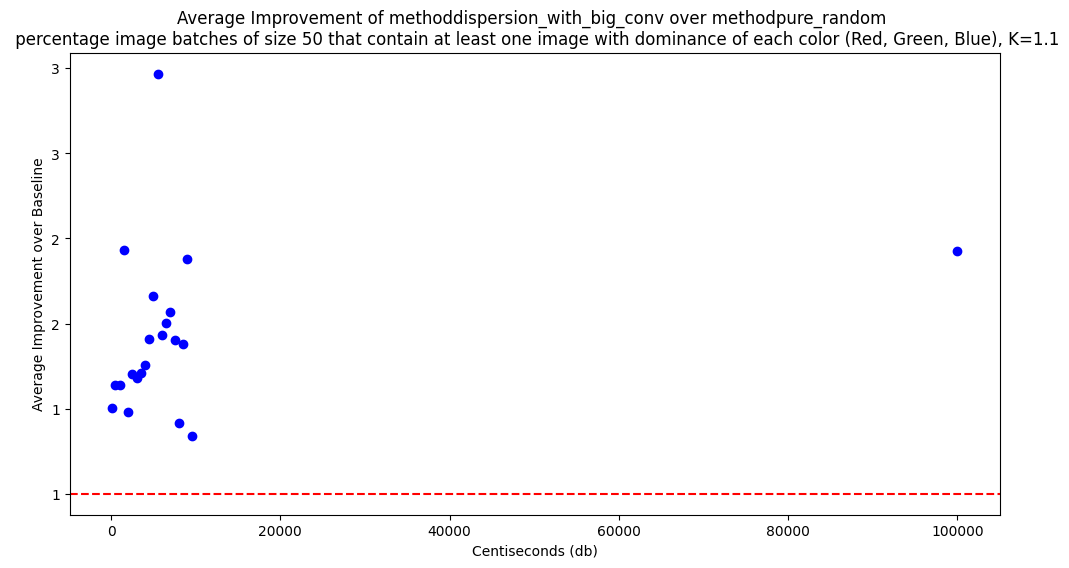

In [169]:
plot_improvement_over_time(prompt_dic_50_K11_again, prompt_dic_50_K11_num_again, 'methoddispersion_with_big_conv', 'methodpure_random', 'percentage image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue), K=1.1' )

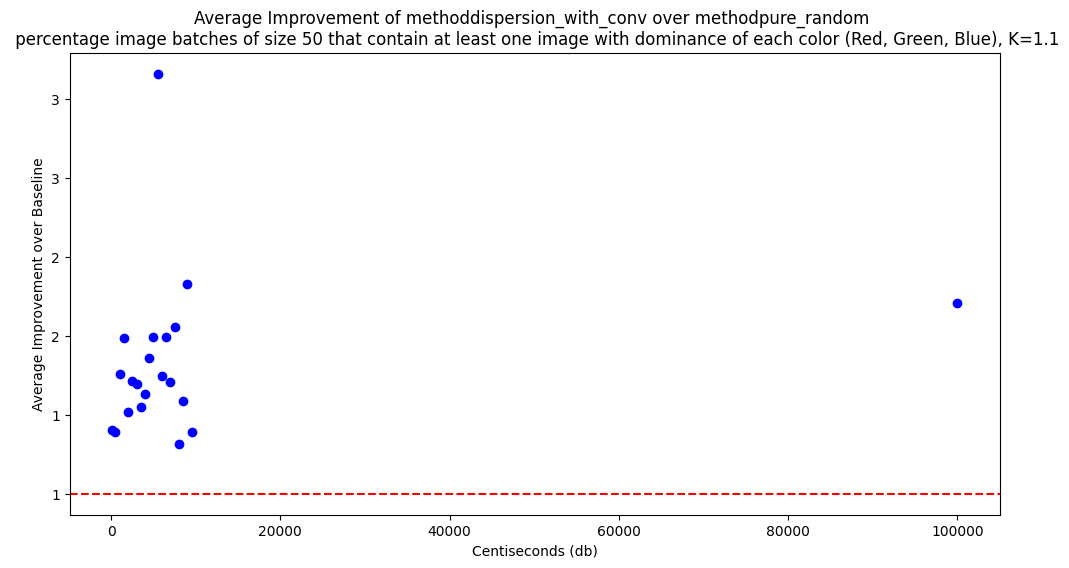

In [170]:
plot_improvement_over_time(prompt_dic_50_K11_again, prompt_dic_50_K11_num_again, 'methoddispersion_with_conv', 'methodpure_random', 'percentage image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue), K=1.1' )

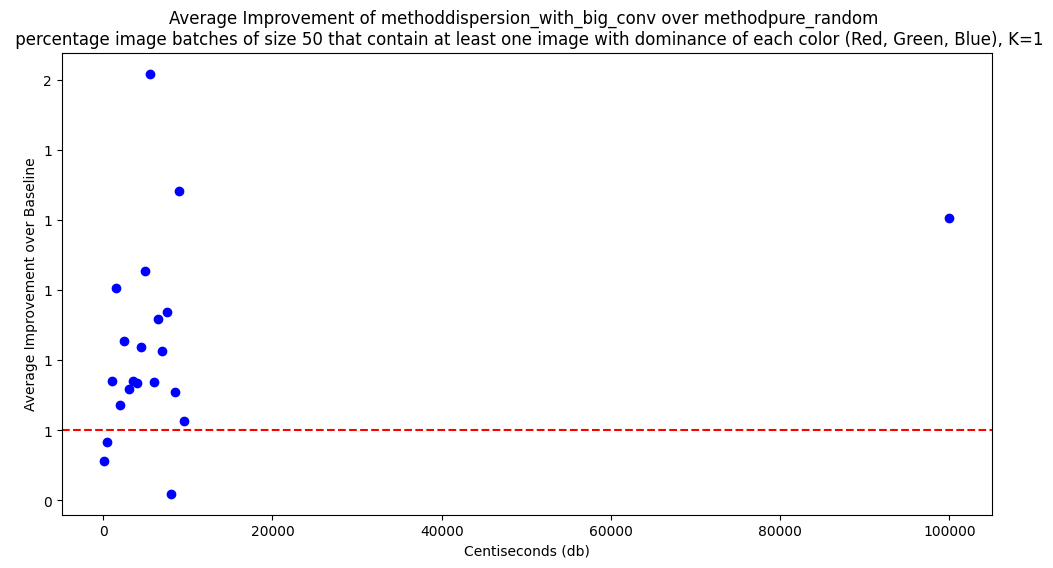

In [171]:
plot_improvement_over_time(prompt_dic_50_again, prompt_dic_50_num_again, 'methoddispersion_with_big_conv', 'methodpure_random', 'percentage image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue), K=1' )

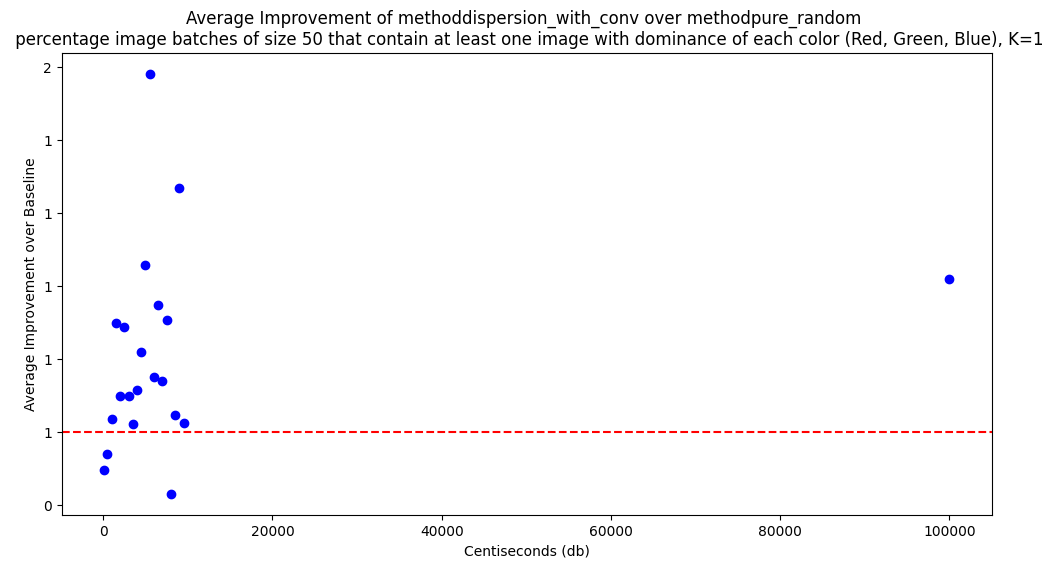

In [172]:
plot_improvement_over_time(prompt_dic_50_again, prompt_dic_50_num_again, 'methoddispersion_with_conv', 'methodpure_random', 'percentage image batches of size 50 that contain at least one image with dominance of each color (Red, Green, Blue), K=1' )

In [173]:
print(prompt_dic_50_again)

{100: {'a photograph of a social worker': {'methoddispersion_with_big_conv': 100.0, 'methodpure_random': 100.0, 'methoddispersion_with_conv': 100.0}, 'rose': {'methoddispersion_with_big_conv': 93.42105263157895, 'methodpure_random': 93.26923076923077, 'methoddispersion_with_conv': 95.79207920792079}, 'bird': {'methoddispersion_with_big_conv': 98.65771812080537, 'methodpure_random': 99.34426229508196, 'methoddispersion_with_conv': 99.6415770609319}, 'a photograph of a president': {'methoddispersion_with_big_conv': 53.75, 'methodpure_random': 41.17647058823529, 'methoddispersion_with_conv': 44.0}, 'a photograph of a computer scientist': {'methoddispersion_with_conv': 98.77750611246944, 'methodpure_random': 91.71974522292994, 'methoddispersion_with_big_conv': 97.61904761904762}, 'cat': {'methoddispersion_with_conv': 80.45112781954887, 'methodpure_random': 86.14864864864865, 'methoddispersion_with_big_conv': 85.51724137931035}, 'horse': {'methoddispersion_with_conv': 94.36619718309859, 'me